In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q flwr[simulation]==1.9.0 torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00


In [ ]:
from collections import OrderedDict, defaultdict, Counter
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import pandas as pd
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave
from skimage.io import imread
import torch.optim as optim
from torchvision import transforms as T
import matplotlib.pyplot as plt
import re

import flwr as fl

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'pylibjpeg'
ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, i

Training on cpu using PyTorch 2.4.1+cu121 and Flower 1.9.0


In [ ]:
data_path = '/content/drive/MyDrive/Federated_Learning_MRI/data/manifest-1717493249030'
boxes_path = r'/content/drive/MyDrive/Federated_Learning_MRI/data/Annotation_Boxes.xlsx'
mapping_path = r'/content/drive/MyDrive/Federated_Learning_MRI/data/Breast-Cancer-MRI-filepath_filename-mapping.xlsx'
target_png_dir = '/content/drive/MyDrive/Federated_Learning_MRI/data/png_out'
if not os.path.exists(target_png_dir):
	os.makedirs(target_png_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Loading bb annotations
boxes_df = pd.read_excel(boxes_path)
display(boxes_df)

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
917,Breast_MRI_918,345,395,338,395,62,85
918,Breast_MRI_919,285,312,369,397,98,109
919,Breast_MRI_920,172,193,337,355,87,101
920,Breast_MRI_921,328,374,404,446,97,121


In [ ]:
# only consider fat-satured "pre" exams
mapping_df = pd.read_excel(mapping_path)
#mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('pre')]

# remove entries from patients that we are not including (we only include patients 1 to 20)
# using a regex pattern
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 26))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def save_dcm_slice(dcm_fname, label, vol_idx):
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    png_path = dcm_fname.split(os.path.sep)[-1].replace('.dcm', '-{}.png'.format(vol_idx))
    label_dir = 'pos' if label == 1 else 'neg'
    png_path = os.path.join(target_png_dir, label_dir, png_path)

    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))

    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist (if you're running this after the first time)

        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split(os.path.sep)
            dcm_fname_end = dcm_fname_split[-1]
            assert dcm_fname_end.split('-')[1][0] == '0'

            dcm_fname_end_split = dcm_fname_end.split('-')
            dcm_fname_end = '-'.join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])

            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = os.path.sep.join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)

        # convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)

        # save final .png
        imsave(png_path, img)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# number of examples for each class
N_class = 10000
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(mapping_df.iterrows(), total=N_class*2):
	# indices start at 1 here
	new_vol_idx = int((row['original_path_and_filename'].split(os.path.sep)[1]).split('_')[-1])
	slice_idx = int(((row['original_path_and_filename'].split(os.path.sep)[-1]).split('_')[-1]).replace('.dcm', ''))

	# new volume: get tumor bounding box
	if new_vol_idx != vol_idx:
		box_row = boxes_df.iloc[[new_vol_idx-1]]
		start_slice = int(box_row['Start Slice'])
		end_slice = int(box_row['End Slice'])
		assert end_slice >= start_slice
	vol_idx = new_vol_idx

	# get DICOM filename
	dcm_fname = str(row['classic_path'])
	dcm_fname = os.path.join(data_path, dcm_fname)

	# determine slice label:
	# (1) if within 3D box, save as positive
	if slice_idx >= start_slice and slice_idx < end_slice:
		if ct_positive >= N_class:
			continue
		# dcm = load_dcm(dcm_fname)
		save_dcm_slice(dcm_fname, 1, vol_idx)
		ct_positive += 1

	# (2) if outside 3D box by >5 slices, save as negative
	elif (slice_idx + 5) <= start_slice or (slice_idx - 5) > end_slice:
		if ct_negative >= N_class:
			continue

		save_dcm_slice(dcm_fname, 0, vol_idx)
		ct_negative += 1

  0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-9-3b822942f8ef>:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  start_slice = int(box_row['Start Slice'])
<ipython-input-9-3b822942f8ef>:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  end_slice = int(box_row['End Slice'])
 98%|█████████▊| 19554/20000 [01:42<00:02, 190.00it/s] 


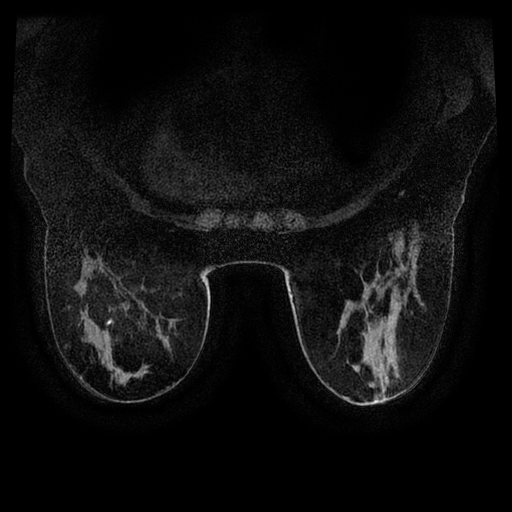

In [ ]:
from IPython.display import Image, display
from random import choice

positive_image_dir = os.path.join(target_png_dir, 'pos')
negative_image_filenames = os.listdir(positive_image_dir)
sample_image_path = os.path.join(positive_image_dir, choice(negative_image_filenames))

display(Image(filename=sample_image_path))

In [ ]:
# directory where our .png data is (created in the previous post)
data_dir = '/content/drive/MyDrive/Federated_Learning_MRI/data/png_out'
# length in pixels of size of image once resized for the network
img_size = 28

In [ ]:
class DBCDataset(Dataset):
    def __init__(self):
        self.data_dir = data_dir
        self.img_size = img_size

        # assign labels to data within this Dataset
        self.labels = None
        self.create_labels()

    def create_labels(self):
        # create and store a label (positive/1 or negative/0 for each image)
        # each label is the tuple: (img filename, label number (0 or 1))
        labels = []
        print('building DBC dataset labels.')
        # iterate over each class
        for target, target_label in enumerate(['neg', 'pos']):
            case_dir = os.path.join(self.data_dir, target_label)
            # iterate over all images in the class/case type
            for fname in os.listdir(case_dir):
                if '.png' in fname:
                    fpath = os.path.join(case_dir, fname)
                    labels.append((fpath, target))

        self.labels = labels


    def normalize(self, img):
        # normalize image pixel values to range [0, 255]
        # img expected to be array

        # convert uint16 -> float
        img = img.astype(float) * 255. / img.max()
        # convert float -> unit8
        img = img.astype(np.uint8)

        return img

    def __getitem__(self, idx):
        # required method for accessing data samples
        # returns data with its label
        fpath, target  = self.labels[idx]

        # load img from file (png or jpg)
        img_arr = imread(fpath, as_gray=True)

        # normalize image
        img_arr = self.normalize(img_arr)

        # convert to tensor (PyTorch matrix)
        data = torch.from_numpy(img_arr)
        data = data.type(torch.FloatTensor)

        # add image channel dimension (to work with neural network)
        data = torch.unsqueeze(data, 0)

        # resize image
        data = transforms.Resize((self.img_size, self.img_size))(data)

        return data, target

    def __len__(self):
        # required method for getting size of dataset
        return len(self.labels)

In [ ]:
dataset = DBCDataset()
print(len(dataset))

building DBC dataset labels.
13461


In [ ]:
train_fraction = 0.8
#validation_fraction = 0.1
test_fraction = 0.2
dataset_size = len(dataset)
[print(dataset_size)]

num_train = int(train_fraction * dataset_size) +1
#num_validation = int(validation_fraction * dataset_size)
num_test = int(test_fraction * dataset_size)
print(num_train, num_test)

train_dataset, test_dataset = torch.utils.data.random_split(
                                 dataset, [num_train, num_test])

13461
10769 2692


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch
import random
from PIL import Image
from collections import Counter

# Custom dataset class to handle loading from directories
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, augment_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.augment_transform = augment_transform
        self.img_labels = []
        self.img_paths = []

        for label in ['pos', 'neg']:
            label_dir = os.path.join(img_dir, label)
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                self.img_paths.append(img_path)
                self.img_labels.append(1 if label == 'pos' else 0)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        label = self.img_labels[idx]

        # Apply augmentation only to the minority class images during oversampling
        if self.augment_transform and label == 1:
            image = self.augment_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define basic transform
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    #transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
])

# Define augment transform
augment_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
])


# Load dataset
dataset = CustomImageDataset(img_dir='/content/drive/MyDrive/Federated_Learning_MRI/data/png_out', transform=transform)
dataset_size = len(dataset)

# Separate indices for pos and neg samples
pos_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]
neg_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]

# Count the number of samples in each class
num_pos = len(pos_indices)
num_neg = len(neg_indices)

# Oversample the minority class to match the majority class size
balanced_indices = []
if num_pos < num_neg:
    oversampled_pos_indices = random.choices(pos_indices, k=num_neg)
    balanced_indices = oversampled_pos_indices + neg_indices
elif num_neg < num_pos:
    oversampled_neg_indices = random.choices(neg_indices, k=num_pos)
    balanced_indices = pos_indices + oversampled_neg_indices
else:
    balanced_indices = pos_indices + neg_indices

"""# Undersample the majority class
if num_pos > num_neg:
    undersampled_pos_indices = random.sample(pos_indices, k=num_neg)
    balanced_indices = undersampled_pos_indices + neg_indices
else:
    undersampled_neg_indices = random.sample(neg_indices, k=num_pos)
    balanced_indices = pos_indices + undersampled_neg_indices"""

# Shuffle the balanced indices
random.shuffle(balanced_indices)

# Split indices into train, validation, and test sets
train_fraction = 0.8
#validation_fraction = 0.1
test_fraction = 0.2

num_train = int(train_fraction * len(balanced_indices))
#num_validation = int(validation_fraction * len(balanced_indices))
num_test = len(balanced_indices) - num_train #- num_validation

train_indices = balanced_indices[:num_train]
#validation_indices = balanced_indices[num_train:num_train +num_validation]
test_indices = balanced_indices[num_train:]

# Create subset datasets
train_dataset = Subset(dataset, train_indices)
#validation_dataset = Subset(dataset, validation_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

print(f"Original dataset size: {dataset_size}")
print(f"Train set: {len(train_dataset)} samples")
#print(f"Validation set: {len(validation_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# Check the balance in each dataset
def check_balance(dataset):
    counter = Counter([label for _, label in dataset])
    return counter

print(f"Train set balance: {check_balance(train_dataset)}")
#print(f"Validation set balance: {check_balance(validation_dataset)}")
print(f"Test set balance: {check_balance(test_dataset)}")

Original dataset size: 13461
Train set: 16025 samples
Test set: 4007 samples
Train set balance: Counter({0: 8046, 1: 7979})
Test set balance: Counter({1: 2037, 0: 1970})


In [ ]:
import torch

# Path to save the datasets
train_data_path = '/content/drive/MyDrive/Federated_Learning_MRI/data/train_dataset.pth'
test_data_path = '/content/drive/MyDrive/Federated_Learning_MRI/data/test_dataset.pth'

# Save the datasets to disk
torch.save(train_dataset, train_data_path)
torch.save(test_dataset, test_data_path)

print(f"Train and test datasets saved to {train_data_path} and {test_data_path}")


Train and test datasets saved to /content/drive/MyDrive/Federated_Learning_MRI/data/train_dataset.pth and /content/drive/MyDrive/Federated_Learning_MRI/data/test_dataset.pth


In [ ]:
import torch

# Path to save the datasets
train_data_path = '/content/drive/MyDrive/Federated_Learning_MRI/data/train_dataset.pth'
test_data_path = '/content/drive/MyDrive/Federated_Learning_MRI/data/test_dataset.pth'

# Load the datasets from disk
train_dataset = torch.load(train_data_path)
test_dataset = torch.load(test_data_path)

print(f"Train and test datasets loaded from {train_data_path} and {test_data_path}")

<ipython-input-16-fc3e093ba523>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(train_data_path)
<ipython-input-16-fc3e093ba523>:9: FutureWarning

Train and test datasets loaded from /content/drive/MyDrive/Federated_Learning_MRI/data/train_dataset.pth and /content/drive/MyDrive/Federated_Learning_MRI/data/test_dataset.pth


In [ ]:
# Check class distribution
from collections import Counter

train_labels = [label for _, label in train_dataset]
train_class_counts = Counter(train_labels)
print(f"Training class distribution: {train_class_counts}")

Training class distribution: Counter({0: 7998, 1: 2771})


In [ ]:
test_labels = [label for _, label in test_dataset]
test_class_counts = Counter(test_labels)
print(f"Test class distribution: {test_class_counts}")

Test class distribution: Counter({0: 2018, 1: 674})


In [ ]:
from torchvision.datasets import VisionDataset

class CustomDataset(VisionDataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# IID split

In [ ]:
import random

NUM_CLIENTS = 20

def load_datasets(num_clients: int):

    #transforms = v2.Compose([
        #T.RandomHorizontalFlip(p=0.5), # flips the given image horizontally with probability p.
        #T.Resize((32, 32)),
        #T.ToTensor(), # Convert image to PyTorch tensor
        #T.RandomRotation(degrees=(-10, 10)),
        #T.Lambda(lambda x: x + 0.05 * torch.randn_like(x)), #Gaussian noise
        #T.RandomAdjustSharpness(sharpness_factor=2, p=0.5), # Contrast Adjustment
        #T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Combination of transformations such as rotation, translation, and scaling.
    #])
    trainset = CustomDataset(train_dataset)
    testset = CustomDataset(test_dataset)

    # Calculate approximate equal partition size
    total_length = len(trainset)
    base_length = total_length // num_clients
    remaining_length = total_length % num_clients

    # Generate lengths with some random variation
    lengths = [base_length + (1 if i < remaining_length else 0) for i in range(num_clients)]
    variations = [random.randint(-base_length//4, base_length//4) for _ in range(num_clients)]

    # Apply variations and adjust to ensure the sum is correct
    lengths = [max(1, l + v) for l, v in zip(lengths, variations)]
    sum_lengths = sum(lengths)

    # Adjust the lengths if there is any discrepancy
    diff = total_length - sum_lengths
    for i in range(abs(diff)):
        lengths[i % num_clients] += 1 if diff > 0 else -1

    print(lengths)  # To check the generated random lengths

    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

[729, 808, 700, 943, 747, 817, 921, 779, 864, 753, 761, 719, 835, 948, 762, 985, 868, 767, 647, 672]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel (grayscale), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)   # Max-pooling with 2x2 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Fully connected layer 1
        self.fc2 = nn.Linear(120, 84)          # Fully connected layer 2
        self.fc3 = nn.Linear(84, 1)            # Output layer: binary classification (1 output)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 4 * 4)  # Flatten the tensor (16 channels, 4x4 feature map)
        x = F.relu(self.fc1(x))      # Fully connected layer 1
        x = F.relu(self.fc2(x))      # Fully connected layer 2
        x = self.fc3(x)              # Output without activation
        return x  # Will apply sigmoid in the loss function (BCEWithLogitsLoss)


In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


In [ ]:
def train(net, trainloader, epochs: int):
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)  # Ensure labels are float for BCE
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs.view(-1), labels)  # Reshape outputs and use float labels
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            predicted_class = torch.sigmoid(outputs).view(-1) > 0.5  # Sigmoid activation for binary output
            total += labels.size(0)
            correct += (predicted_class == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    criterion = nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs.view(-1), labels).item()  # Reshape outputs
            predicted_class = torch.sigmoid(outputs).view(-1) > 0.5  # Sigmoid and threshold at 0.5
            total += labels.size(0)
            correct += (predicted_class == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        if len(self.valloader.dataset) == 0:
            print(f"[Client {self.cid}] Warning: Validation loader is empty. Skipping evaluation.")
            return float('inf'), 0, {"accuracy": 0.0}

        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [ ]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 #
    }
    return config

In [ ]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net()

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [ ]:
import pickle

# Save history after simulation
def save_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history, f)

# Load history from file
def load_history(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

## 20 clients FedAvg

### Adam 0.001

In [ ]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

In [ ]:
# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.4, # Sample 30% of available clients for training
    fraction_evaluate=0.4, # Sample 30% of available clients for evaluation
    min_fit_clients=8, # Never sample less than 3 clients for training
    min_evaluate_clients=8, # Never sample less than 3 clients for evaluation
    min_available_clients=NUM_CLIENTS, # Wait until all NUM_CLIENTS are available
    evaluate_fn=get_evaluate_fn(testloader),
    on_fit_config_fn=fit_config,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


# Start simulation and collect history
history_fedAvg_20c_Adam_IID = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=200),
    strategy=strategy,
    client_resources=client_resources,
)

save_history(history_fedAvg_20c_Adam_IID, "/content/drive/MyDrive/Federated_Learning_MRI/CSDA/breast_cancer_logs/history_fedAvg_20c_Adam_IID.pkl")

INFO :      Starting Flower simulation, config: num_rounds=200, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-11 07:26:43,025	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7986118656.0, 'object_store_memory': 3993059328.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global par

(ClientAppActor pid=3789) [Client 17, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6992, accuracy 0.5138
(ClientAppActor pid=3788) [Client 14, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=3788) Epoch 1: train loss 0.6976, accuracy 0.5301 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6947, accuracy 0.4877
(ClientAppActor pid=3789) [Client 13, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.7050, accuracy 0.5014
(ClientAppActor pid=3789) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6987, accuracy 0.4988
(ClientAppActor pid=3788) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.7105, accuracy 0.4608


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6975, accuracy 0.5068


INFO :      fit progress: (1, 0.69319006706041, {'accuracy': 0.5063638632393311}, 1561.698807239)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6976, accuracy 0.5120
(ClientAppActor pid=3788) [Client 12, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6975, accuracy 0.5053
(ClientAppActor pid=3788) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6975, accuracy 0.4746
(ClientAppActor pid=3789) [Client 18, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6946, accuracy 0.5071
(ClientAppActor pid=3789) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6978, accuracy 0.5086
(ClientAppActor pid=3788) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6982, accuracy 0.4808
(ClientAppActor pid=3789) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6983, accuracy 0.4972


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6962, accuracy 0.5156


INFO :      fit progress: (2, 0.6930645647503081, {'accuracy': 0.5063638632393311}, 3050.0631932990004)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) [Client 14] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6935, accuracy 0.5199
(ClientAppActor pid=3788) [Client 15, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.7058, accuracy 0.5120
(ClientAppActor pid=3789) [Client 18, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6939, accuracy 0.5024
(ClientAppActor pid=3789) [Client 13, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6931, accuracy 0.4986
(ClientAppActor pid=3789) [Client 19, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.7012, accuracy 0.4911
(ClientAppActor pid=3788) [Client 16, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6945, accuracy 0.5247
(ClientAppActor pid=3789) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6965, accuracy 0.4734


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6970, accuracy 0.4825


INFO :      fit progress: (3, 0.6931383250251649, {'accuracy': 0.5063638632393311}, 3758.3713554360006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 8 r

(ClientAppActor pid=3789) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.6977, accuracy 0.4941
(ClientAppActor pid=3788) [Client 19, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6925, accuracy 0.5321
(ClientAppActor pid=3788) [Client 13, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6923, accuracy 0.5158
(ClientAppActor pid=3788) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6947, accuracy 0.5000
(ClientAppActor pid=3788) [Client 17, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6937, accuracy 0.5020
(ClientAppActor pid=3788) [Client 16, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6937, accuracy 0.5192
(ClientAppActor pid=3788) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6929, accuracy 0.5274


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6940, accuracy 0.5154


INFO :      fit progress: (4, 0.692747207861098, {'accuracy': 0.5063638632393311}, 4129.531194859001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6940, accuracy 0.5172
(ClientAppActor pid=3788) [Client 19, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6919, accuracy 0.5158 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6971, accuracy 0.4821 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6994, accuracy 0.5097
(ClientAppActor pid=3788) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6926, accuracy 0.4932


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (5, 0.6928102842399052, {'accuracy': 0.5063638632393311}, 4313.6013753610005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 2] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6950, accuracy 0.4729
(ClientAppActor pid=3788) [Client 7] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6930, accuracy 0.4880
(ClientAppActor pid=3788) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6944, accuracy 0.5142 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6935, accuracy 0.5031 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6931, accuracy 0.5485
(ClientAppActor pid=3789) [Client 19, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6952, accuracy 0.4901


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (6, 0.6927720251537505, {'accuracy': 0.5063638632393311}, 4501.421317577)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6943, accuracy 0.5052


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 14, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.6936, accuracy 0.4928
(ClientAppActor pid=3789) [Client 15, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6946, accuracy 0.5116 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6924, accuracy 0.5156 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6934, accuracy 0.5192
(ClientAppActor pid=3788) [Client 16, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6945, accuracy 0.4775


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (7, 0.6901900777741085, {'accuracy': 0.5098577489393561}, 4689.981272307001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6884, accuracy 0.5345


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6953, accuracy 0.5204
(ClientAppActor pid=3788) [Client 16] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6932, accuracy 0.5393 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6780, accuracy 0.5497 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6913, accuracy 0.5166 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (8, 0.6836806072129143, {'accuracy': 0.5862241078113302}, 4847.508192479001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6903, accuracy 0.5283
(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6767, accuracy 0.5705
(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6911, accuracy 0.5192 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6715, accuracy 0.5411 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6821, accuracy 0.5859


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6822, accuracy 0.5724
(ClientAppActor pid=3789) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}


INFO :      fit progress: (9, 0.6734561579568046, {'accuracy': 0.5959570751185426}, 4994.9420455)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6722, accuracy 0.5884
(ClientAppActor pid=3788) [Client 15] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6915, accuracy 0.5413
(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6818, accuracy 0.5606 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6764, accuracy 0.5725 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6804, accuracy 0.5400 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (10, 0.6693542576025403, {'accuracy': 0.6051909158971799}, 5153.809694257001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6761, accuracy 0.5700


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6480, accuracy 0.6261
(ClientAppActor pid=3789) [Client 14, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6529, accuracy 0.6091 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6442, accuracy 0.6213 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6761, accuracy 0.5520
(ClientAppActor pid=3788) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6482, accuracy 0.6026


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6730, accuracy 0.5853


INFO :      fit progress: (11, 0.6618321736653646, {'accuracy': 0.6029448465185925}, 5569.871680087001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6598, accuracy 0.5991
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6606, accuracy 0.6207 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6693, accuracy 0.5927 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6655, accuracy 0.5917 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (12, 0.6637335774444398, {'accuracy': 0.6129273770900924}, 5723.3078389540005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6745, accuracy 0.5923


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6560, accuracy 0.6027
(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6801, accuracy 0.5721
(ClientAppActor pid=3789) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6842, accuracy 0.5659
(ClientAppActor pid=3788) [Client 19, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6619, accuracy 0.6072
(ClientAppActor pid=3789) [Client 14, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6709, accuracy 0.5366
(ClientAppActor pid=3788) [Client 16, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6647, accuracy 0.5861
(ClientAppActor pid=3789) [Client 8, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6690, accuracy 0.6327


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6671, accuracy 0.5994


INFO :      fit progress: (13, 0.6575150466154492, {'accuracy': 0.6074369852757674}, 5883.890304686001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6645, accuracy 0.6159
(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6458, accuracy 0.6352 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6696, accuracy 0.5884 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6644, accuracy 0.5697
(ClientAppActor pid=3788) [Client 4, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6713, accuracy 0.6150


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (14, 0.6557962757254404, {'accuracy': 0.6179186423758423}, 6049.477956167)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6607, accuracy 0.5874


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6774, accuracy 0.5486
(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6571, accuracy 0.6282
(ClientAppActor pid=3789) [Client 16, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6710, accuracy 0.5508
(ClientAppActor pid=3788) [Client 4, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6540, accuracy 0.6127
(ClientAppActor pid=3789) 
(ClientAppActor pid=3788) Epoch 1: train loss 0.6385, accuracy 0.6270
(ClientAppActor pid=3789) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6672, accuracy 0.5860 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (15, 0.650196803940667, {'accuracy': 0.6174195158472673}, 6213.201993637)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6679, accuracy 0.5816


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=3788) 
(ClientAppActor pid=3789) Epoch 1: train loss 0.6600, accuracy 0.6062
(ClientAppActor pid=3788) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6538, accuracy 0.6230
(ClientAppActor pid=3788) [Client 18, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6512, accuracy 0.6017
(ClientAppActor pid=3789) [Client 16, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6647, accuracy 0.5969
(ClientAppActor pid=3788) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6663, accuracy 0.6144
(ClientAppActor pid=3789) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6402, accuracy 0.6208
(ClientAppActor pid=3788) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6491, accuracy 0.6205


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6605, accuracy 0.6451


INFO :      fit progress: (16, 0.6517452607079158, {'accuracy': 0.6264037933616172}, 6368.794828694001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.6595, accuracy 0.6168
(ClientAppActor pid=3789) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6683, accuracy 0.6029 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6414, accuracy 0.6154 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6584, accuracy 0.5851
(ClientAppActor pid=3789) [Client 15, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6459, accuracy 0.6167


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6589, accuracy 0.6237


INFO :      fit progress: (17, 0.6499162316322327, {'accuracy': 0.6226603443973047}, 6539.374974606)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6518, accuracy 0.6051
(ClientAppActor pid=3788) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6605, accuracy 0.6308
(ClientAppActor pid=3788) Epoch 1: train loss 0.6650, accuracy 0.6067
(ClientAppActor pid=3789) [Client 17, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6385, accuracy 0.6377 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6553, accuracy 0.6193
(ClientAppActor pid=3788) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6498, accuracy 0.6216


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (18, 0.6493137161883097, {'accuracy': 0.6249064137758922}, 6698.208445985001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6386, accuracy 0.6224
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6280, accuracy 0.6533
(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) [Client 19, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6536, accuracy 0.6451 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6606, accuracy 0.6099
(ClientAppActor pid=3788) [Client 12, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6396, accuracy 0.6207


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6758, accuracy 0.5770
(ClientAppActor pid=3788) [Client 7, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6325, accuracy 0.6270


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6523, accuracy 0.6182


INFO :      fit progress: (19, 0.6490134672513084, {'accuracy': 0.6256551035687546}, 6857.520997207001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 3, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6467, accuracy 0.6387
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 10, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6345, accuracy 0.6467 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6590, accuracy 0.6293


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6501, accuracy 0.6176
(ClientAppActor pid=3788) [Client 4, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6548, accuracy 0.5979
(ClientAppActor pid=3789) [Client 19, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6453, accuracy 0.6382


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (20, 0.6472983823882209, {'accuracy': 0.6196655852258548}, 7017.178422453)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6544, accuracy 0.5979
(ClientAppActor pid=3788) [Client 7] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6474, accuracy 0.6227
(ClientAppActor pid=3789) [Client 16, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6671, accuracy 0.5681 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6487, accuracy 0.6237
(ClientAppActor pid=3788) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6624, accuracy 0.5904
(ClientAppActor pid=3789) [Client 12, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6549, accuracy 0.6121
(ClientAppActor pid=3788) [Client 2, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6609, accuracy 0.6028


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6297, accuracy 0.6368


INFO :      fit progress: (21, 0.6420502416671269, {'accuracy': 0.6311454953830796}, 7175.556942251)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6622, accuracy 0.6136
(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 19, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 14, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6553, accuracy 0.6255 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6676, accuracy 0.5754 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6505, accuracy 0.6270 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (22, 0.6446554121517, {'accuracy': 0.6316446219116546}, 7329.539035465001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6581, accuracy 0.6122
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6542, accuracy 0.6256
(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6545, accuracy 0.6125
(ClientAppActor pid=3788) [Client 12, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6370, accuracy 0.6334


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6551, accuracy 0.6181
(ClientAppActor pid=3788) [Client 14, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6553, accuracy 0.6213
(ClientAppActor pid=3789) [Client 8, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6544, accuracy 0.6264 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (23, 0.6442245197674584, {'accuracy': 0.6373845769902671}, 7484.587096257001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6356, accuracy 0.6301


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6474, accuracy 0.6196
(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 18, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6664, accuracy 0.6040 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6580, accuracy 0.6193 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6466, accuracy 0.6199 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6441, accuracy 0.6438


INFO :      fit progress: (24, 0.6385375540407877, {'accuracy': 0.6376341402545546}, 7641.189715500001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6306, accuracy 0.6383
(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) [Client 11, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6324, accuracy 0.6533 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6450, accuracy 0.6272 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6557, accuracy 0.6177
(ClientAppActor pid=3789) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6612, accuracy 0.6258


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (25, 0.636372175954637, {'accuracy': 0.6371350137259796}, 7793.24216541)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6414, accuracy 0.6468
(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6609, accuracy 0.6240
(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6224, accuracy 0.6553 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6337, accuracy 0.6595


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6401, accuracy 0.6414
(ClientAppActor pid=3788) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6493, accuracy 0.6399


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6296, accuracy 0.6517


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6535, accuracy 0.6218


INFO :      fit progress: (26, 0.634227339710508, {'accuracy': 0.6461192912403294}, 7951.631628249001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.6526, accuracy 0.6108
(ClientAppActor pid=3789) [Client 10, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6389, accuracy 0.6228
(ClientAppActor pid=3788) [Client 19, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6216, accuracy 0.6562
(ClientAppActor pid=3789) [Client 7, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6466, accuracy 0.5964
(ClientAppActor pid=3788) [Client 11, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6440, accuracy 0.6228


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6242, accuracy 0.6522
(ClientAppActor pid=3788) [Client 18, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6478, accuracy 0.6379


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6388, accuracy 0.6371


INFO :      fit progress: (27, 0.6323277358970945, {'accuracy': 0.6486149238832044}, 8107.623466562001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5963, accuracy 0.6729
(ClientAppActor pid=3789) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6291, accuracy 0.6453 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6546, accuracy 0.6240 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6423, accuracy 0.6399
(ClientAppActor pid=3789) [Client 13, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6338, accuracy 0.6562


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (28, 0.6350431749745021, {'accuracy': 0.6428749688045919}, 8261.216382958)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6431, accuracy 0.6261


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6154, accuracy 0.6619
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 14, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6336, accuracy 0.6433 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6510, accuracy 0.6075
(ClientAppActor pid=3789) [Client 0, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6454, accuracy 0.6222
(ClientAppActor pid=3788) [Client 3, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6333, accuracy 0.6627 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (29, 0.6241174647732387, {'accuracy': 0.6523583728475169}, 8410.715762400001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6376, accuracy 0.6448


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 1] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6178, accuracy 0.6490
(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6341, accuracy 0.6525
(ClientAppActor pid=3788) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6224, accuracy 0.6510
(ClientAppActor pid=3789) [Client 11, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6225, accuracy 0.6723 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6393, accuracy 0.6477 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (30, 0.6247935973935657, {'accuracy': 0.6551035687546793}, 8559.989000766001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6468, accuracy 0.6336
(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6353, accuracy 0.6231
(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6192, accuracy 0.6538 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6504, accuracy 0.6170


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6209, accuracy 0.6605
(ClientAppActor pid=3788) [Client 8, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6435, accuracy 0.6255
(ClientAppActor pid=3789) [Client 16, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6266, accuracy 0.6506


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (31, 0.6200955306726789, {'accuracy': 0.6633391564761667}, 8712.110149593)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6536, accuracy 0.6210
(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 2, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6205, accuracy 0.6370
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6259, accuracy 0.6544 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6365, accuracy 0.6099 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6448, accuracy 0.6394 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (32, 0.6185198099840254, {'accuracy': 0.6658347891190417}, 8872.169078548)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6424, accuracy 0.6059


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 4, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6174, accuracy 0.6481
(ClientAppActor pid=3788) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) [Client 15, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6526, accuracy 0.5985 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6111, accuracy 0.6648 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6250, accuracy 0.6510 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (33, 0.6127287192004067, {'accuracy': 0.6620913401547293}, 9026.145254706)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6281, accuracy 0.6403


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 16, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6466, accuracy 0.6260
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6219, accuracy 0.6403
(ClientAppActor pid=3789) [Client 7, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6315, accuracy 0.6385


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6091, accuracy 0.6627 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 18, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6262, accuracy 0.6206 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


INFO :      fit progress: (34, 0.6131786280681216, {'accuracy': 0.6603443973047167}, 9182.477765481)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6452, accuracy 0.6072


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6240, accuracy 0.6565
(ClientAppActor pid=3788) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6104, accuracy 0.6610 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5965, accuracy 0.6723 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6179, accuracy 0.6581 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (35, 0.6129852679986802, {'accuracy': 0.6613426503618667}, 9334.095119521)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6126, accuracy 0.6662
(ClientAppActor pid=3789) 


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6176, accuracy 0.6541
(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6021, accuracy 0.6691
(ClientAppActor pid=3788) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6154, accuracy 0.6648
(ClientAppActor pid=3789) [Client 14, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6183, accuracy 0.6564
(ClientAppActor pid=3788) [Client 2, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6040, accuracy 0.6570
(ClientAppActor pid=3789) [Client 1, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6049, accuracy 0.6781
(ClientAppActor pid=3788) [Client 15, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6220, accuracy 0.6505


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6135, accuracy 0.6734


INFO :      fit progress: (36, 0.6125124219864134, {'accuracy': 0.6663339156476167}, 9489.475342618001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 12, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6144, accuracy 0.6693
(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6323, accuracy 0.6240


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6160, accuracy 0.6627
(ClientAppActor pid=3789) [Client 2, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6051, accuracy 0.6538 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6128, accuracy 0.6490 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (37, 0.6052404083902874, {'accuracy': 0.6723234339905166}, 9646.361916453001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6318, accuracy 0.6258


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6024, accuracy 0.6816
(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 5, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6218, accuracy 0.6527 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6283, accuracy 0.6433 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6326, accuracy 0.6215 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (38, 0.6077355337994439, {'accuracy': 0.6668330421761917}, 9801.578119659001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6312, accuracy 0.6323


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6307, accuracy 0.6401
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) [Client 8, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5926, accuracy 0.6795 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6092, accuracy 0.6613 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5870, accuracy 0.6785 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (39, 0.6066590672920621, {'accuracy': 0.6748190666333915}, 9960.283016533002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6257, accuracy 0.6568


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6199, accuracy 0.6307
(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 12, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6156, accuracy 0.6577 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5971, accuracy 0.6873 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6155, accuracy 0.6519
(ClientAppActor pid=3788) [Client 6, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6204, accuracy 0.6485


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (40, 0.5974869370933563, {'accuracy': 0.683553780883454}, 10119.606698688001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6129, accuracy 0.6613


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6060, accuracy 0.6648
(ClientAppActor pid=3789) [Client 11] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 17, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 5, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6273, accuracy 0.6338 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6279, accuracy 0.6490 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6035, accuracy 0.6544
(ClientAppActor pid=3789) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6063, accuracy 0.6619


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (41, 0.5976320665980143, {'accuracy': 0.681058148240579}, 10277.620730454)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5925, accuracy 0.6624


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 12, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5792, accuracy 0.7004
(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6162, accuracy 0.6675


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6405, accuracy 0.6538
(ClientAppActor pid=3788) [Client 17, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6044, accuracy 0.6762


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6259, accuracy 0.6418
(ClientAppActor pid=3788) [Client 9, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6058, accuracy 0.6856
(ClientAppActor pid=3789) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6152, accuracy 0.6756


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (42, 0.5917680786242561, {'accuracy': 0.6803094584477165}, 10439.280468837002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5880, accuracy 0.6946
(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6228, accuracy 0.6364
(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 17, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6087, accuracy 0.6710 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5915, accuracy 0.6729 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6264, accuracy 0.6298
(ClientAppActor pid=3789) [Client 15, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6354, accuracy 0.6173


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6136, accuracy 0.6651


INFO :      fit progress: (43, 0.5954022563639141, {'accuracy': 0.6833042176191665}, 10604.594103471001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6047, accuracy 0.6698
(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6019, accuracy 0.6690
(ClientAppActor pid=3788) [Client 13, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6096, accuracy 0.6708
(ClientAppActor pid=3789) [Client 19, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5984, accuracy 0.6891
(ClientAppActor pid=3788) [Client 0, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6095, accuracy 0.6472
(ClientAppActor pid=3789) [Client 5, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6110, accuracy 0.6597
(ClientAppActor pid=3788) [Client 4, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6138, accuracy 0.6564


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (44, 0.5909235815680216, {'accuracy': 0.683054654354879}, 10761.731351298)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5808, accuracy 0.6989


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 13] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5998, accuracy 0.6592
(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) [Client 13, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 14, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5965, accuracy 0.6833 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 12, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6055, accuracy 0.6627
(ClientAppActor pid=3788) [Client 4, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6036, accuracy 0.6627
(ClientAppActor pid=3789) [Client 18, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6028, accuracy 0.6853
(ClientAppActor pid=3788) [Client 19, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6165, accuracy 0.6525


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (45, 0.5962142719635888, {'accuracy': 0.6845520339406039}, 10925.884056879)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6086, accuracy 0.6457
(ClientAppActor pid=3788) [Client 15] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6106, accuracy 0.6651
(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) [Client 7, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6083, accuracy 0.6745 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5910, accuracy 0.6815 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5830, accuracy 0.7034 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.6010, accuracy 0.6800


INFO :      fit progress: (46, 0.5933300417567057, {'accuracy': 0.678063389069129}, 11085.475325272)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.6290, accuracy 0.6548
(ClientAppActor pid=3788) [Client 9, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5983, accuracy 0.6767
(ClientAppActor pid=3788) [Client 1, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5885, accuracy 0.6922
(ClientAppActor pid=3789) [Client 16, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5919, accuracy 0.6876
(ClientAppActor pid=3788) [Client 14, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6057, accuracy 0.6611


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5978, accuracy 0.6662
(ClientAppActor pid=3788) [Client 3, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6131, accuracy 0.6726


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.6039, accuracy 0.6661


INFO :      fit progress: (47, 0.5927083757188585, {'accuracy': 0.677065136011979}, 11245.914637398)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 9] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5962, accuracy 0.6620
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 7, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5968, accuracy 0.6705 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 10, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6281, accuracy 0.6354 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 17, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5928, accuracy 0.6705
(ClientAppActor pid=3788) [Client 5, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6123, accuracy 0.6511


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (48, 0.5842645333872901, {'accuracy': 0.6892937359620663}, 11409.095366416)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6130, accuracy 0.6564


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 14, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5825, accuracy 0.6794
(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) [Client 4, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5859, accuracy 0.6866 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5720, accuracy 0.6848
(ClientAppActor pid=3789) [Client 7, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6059, accuracy 0.6742
(ClientAppActor pid=3788) [Client 16, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6075, accuracy 0.6729


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6146, accuracy 0.6528


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5937, accuracy 0.6816


INFO :      fit progress: (49, 0.5809728995202079, {'accuracy': 0.6950336910406788}, 11564.4186193)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6183, accuracy 0.6709
(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5858, accuracy 0.7049 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5887, accuracy 0.6833
(ClientAppActor pid=3789) [Client 3, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5919, accuracy 0.6933
(ClientAppActor pid=3788) [Client 10, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6037, accuracy 0.6754 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (50, 0.5755640940060691, {'accuracy': 0.6970301971549788}, 11718.558486625001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6048, accuracy 0.6662
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6069, accuracy 0.6671
(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 12, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5598, accuracy 0.7151 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6362, accuracy 0.6308 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 7, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5753, accuracy 0.6910
(ClientAppActor pid=3789) Epoch 1: train loss 0.5937, accuracy 0.6620
(ClientAppActor pid=3788) [Client 1, round 51] fit, config: {'server_round': 51, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (51, 0.5847352319766604, {'accuracy': 0.6855502869977539}, 11879.764465265001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5996, accuracy 0.6676


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 8, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5840, accuracy 0.6761
(ClientAppActor pid=3788) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 15, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5875, accuracy 0.6756 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5644, accuracy 0.7019
(ClientAppActor pid=3788) Epoch 1: train loss 0.6018, accuracy 0.6895
(ClientAppActor pid=3789) [Client 4, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5708, accuracy 0.6939


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10, round 52] fit, config: {'server_round': 52, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6202, accuracy 0.6530


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (52, 0.5771904978014174, {'accuracy': 0.6932867481906664}, 12041.11440656)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6184, accuracy 0.6508
(ClientAppActor pid=3788) [Client 4] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6234, accuracy 0.6627
(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 15, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6111, accuracy 0.6828
(ClientAppActor pid=3788) [Client 2, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6055, accuracy 0.6726
(ClientAppActor pid=3789) [Client 8, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5938, accuracy 0.6823
(ClientAppActor pid=3788) [Client 14, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5974, accuracy 0.6619


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5926, accuracy 0.6570
(ClientAppActor pid=3788) [Client 13, round 53] fit, config: {'server_round': 53, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6289, accuracy 0.6400


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5664, accuracy 0.7106


INFO :      fit progress: (53, 0.5771253839844749, {'accuracy': 0.6900424257549289}, 12198.940616221)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 19, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6169, accuracy 0.6398
(ClientAppActor pid=3788) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) [Client 13, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5983, accuracy 0.6694 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6026, accuracy 0.6605 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5852, accuracy 0.7106 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 54] fit, config: {'server_round': 54, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (54, 0.5772490617301729, {'accuracy': 0.6960319440978288}, 12357.254877207)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5910, accuracy 0.6898
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) [Client 11, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.5769, accuracy 0.6801
(ClientAppActor pid=3788) [Client 13, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5773, accuracy 0.7162 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6109, accuracy 0.6663
(ClientAppActor pid=3789) [Client 8, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5966, accuracy 0.6827
(ClientAppActor pid=3788) [Client 4, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5914, accuracy 0.6705 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 55] fit, config: {'server_round': 55, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (55, 0.5825582141914065, {'accuracy': 0.6937858747192414}, 12518.826284964001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5687, accuracy 0.7001


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6006, accuracy 0.6738
(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5886, accuracy 0.6856 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5877, accuracy 0.6899


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5946, accuracy 0.6886
(ClientAppActor pid=3788) [Client 18, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5776, accuracy 0.6726


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12, round 56] fit, config: {'server_round': 56, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5816, accuracy 0.6868


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (56, 0.5717841112424457, {'accuracy': 0.7010232093835788}, 12679.507084673001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6004, accuracy 0.6780
(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5993, accuracy 0.6895
(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) [Client 16, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.6167, accuracy 0.6627
(ClientAppActor pid=3789) [Client 17, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5993, accuracy 0.6769
(ClientAppActor pid=3788) [Client 1, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6017, accuracy 0.6631
(ClientAppActor pid=3789) [Client 14, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5789, accuracy 0.7061
(ClientAppActor pid=3788) [Client 6, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5708, accuracy 0.6912
(ClientAppActor pid=3789) [Client 11, round 57] fit, config: {'server_round': 57, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5949, accuracy 0.6710


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5639, accuracy 0.7156


INFO :      fit progress: (57, 0.5779458409737027, {'accuracy': 0.6930371849263789}, 12837.007457219)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 9, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5925, accuracy 0.6634
(ClientAppActor pid=3788) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) [Client 8, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 1, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5929, accuracy 0.6832


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 11, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5658, accuracy 0.7118


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5916, accuracy 0.6792 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 3, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5533, accuracy 0.7251
(ClientAppActor pid=3788) [Client 14, round 58] fit, config: {'server_round': 58, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5843, accuracy 0.6969


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5859, accuracy 0.6886


INFO :      fit progress: (58, 0.5632439355055491, {'accuracy': 0.7060144746693287}, 12998.734836245001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) [Client 14, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.5830, accuracy 0.7009
(ClientAppActor pid=3789) [Client 2, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 4, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5801, accuracy 0.6853 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5811, accuracy 0.6761 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 16, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5846, accuracy 0.6778
(ClientAppActor pid=3788) [Client 6, round 59] fit, config: {'server_round': 59, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5924, accuracy 0.6945


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (59, 0.5722005790661252, {'accuracy': 0.6972797604192663}, 13165.693208613002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5854, accuracy 0.7050
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5898, accuracy 0.6921
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5988, accuracy 0.6901 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5807, accuracy 0.6903
(ClientAppActor pid=3788) [Client 0, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5949, accuracy 0.6870
(ClientAppActor pid=3788) [Client 12, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5989, accuracy 0.6761 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 60] fit, config: {'server_round': 60, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (60, 0.569686949726135, {'accuracy': 0.7065136011979036}, 13324.194249375001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5870, accuracy 0.6933


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5978, accuracy 0.6747
(ClientAppActor pid=3788) [Client 19, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5987, accuracy 0.6747 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5733, accuracy 0.7009 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6036, accuracy 0.6839 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 61] fit, config: {'server_round': 61, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (61, 0.5606096822118002, {'accuracy': 0.716745695033691}, 13480.052837223002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5665, accuracy 0.7046
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5834, accuracy 0.6776
(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5816, accuracy 0.6982 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5615, accuracy 0.7140 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5711, accuracy 0.6868


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2, round 62] fit, config: {'server_round': 62, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5748, accuracy 0.6976


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5561, accuracy 0.7123


INFO :      fit progress: (62, 0.5604665101993651, {'accuracy': 0.7057649114050412}, 13647.768751911002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5731, accuracy 0.7074
(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 15, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5920, accuracy 0.6864
(ClientAppActor pid=3788) [Client 13, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5935, accuracy 0.6805
(ClientAppActor pid=3788) [Client 10, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.6136, accuracy 0.6662 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5868, accuracy 0.6884 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 63] fit, config: {'server_round': 63, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (63, 0.5624447441290296, {'accuracy': 0.7080109807836287}, 13810.828608775)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5788, accuracy 0.6863


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 15, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5648, accuracy 0.7077
(ClientAppActor pid=3788) [Client 10] evaluate, config: {}
(ClientAppActor pid=3789) [Client 13, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5458, accuracy 0.7273 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5640, accuracy 0.6969 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5872, accuracy 0.6976 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 64] fit, config: {'server_round': 64, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (64, 0.5690556185113059, {'accuracy': 0.7040179685550287}, 13978.358697488)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5856, accuracy 0.6797


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5771, accuracy 0.6935
(ClientAppActor pid=3788) [Client 14] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 3, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 7, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5684, accuracy 0.7199 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5792, accuracy 0.6820 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5913, accuracy 0.6710 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 0, round 65] fit, config: {'server_round': 65, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (65, 0.5611923616083841, {'accuracy': 0.7072622909907662}, 14128.743304736001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6086, accuracy 0.6677
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5946, accuracy 0.6690
(ClientAppActor pid=3788) [Client 4, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5989, accuracy 0.6904 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5899, accuracy 0.6637 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5747, accuracy 0.7021 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 66] fit, config: {'server_round': 66, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5847, accuracy 0.6821


INFO :      fit progress: (66, 0.5671397892255632, {'accuracy': 0.7002745195907163}, 14287.446292519)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5844, accuracy 0.7089
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5829, accuracy 0.6845 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6122, accuracy 0.6645 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5653, accuracy 0.7076


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18, round 67] fit, config: {'server_round': 67, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5435, accuracy 0.7265


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5763, accuracy 0.6974


INFO :      fit progress: (67, 0.5605068199691319, {'accuracy': 0.7075118542550537}, 14446.017347196002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5938, accuracy 0.6937
(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5928, accuracy 0.6933 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5643, accuracy 0.6903
(ClientAppActor pid=3788) [Client 14, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5927, accuracy 0.6840
(ClientAppActor pid=3789) [Client 5, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5786, accuracy 0.7021 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 68] fit, config: {'server_round': 68, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (68, 0.5675900791372571, {'accuracy': 0.7050162216121787}, 14603.674179818)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5903, accuracy 0.6712


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5920, accuracy 0.6966
(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5994, accuracy 0.6823 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5898, accuracy 0.6891 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5887, accuracy 0.6858
(ClientAppActor pid=3789) Epoch 1: train loss 0.6113, accuracy 0.6937
(ClientAppActor pid=3788) [Client 15, round 69] fit, config: {'server_round': 69, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5924, accuracy 0.6935


INFO :      fit progress: (69, 0.553412326981151, {'accuracy': 0.7107561766907912}, 14774.707100878002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 10] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5776, accuracy 0.6996
(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 3, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5858, accuracy 0.6986 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5655, accuracy 0.7009
(ClientAppActor pid=3788) [Client 8, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.6024, accuracy 0.6734
(ClientAppActor pid=3789) [Client 7, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5754, accuracy 0.7074 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 70] fit, config: {'server_round': 70, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5845, accuracy 0.7108


INFO :      fit progress: (70, 0.564450476141203, {'accuracy': 0.7077614175193412}, 14938.543834186)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5473, accuracy 0.7275
(ClientAppActor pid=3788) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5707, accuracy 0.6917 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5646, accuracy 0.7043
(ClientAppActor pid=3789) [Client 17, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5578, accuracy 0.6935
(ClientAppActor pid=3788) [Client 8, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5783, accuracy 0.6818


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5, round 71] fit, config: {'server_round': 71, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5754, accuracy 0.6790


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5682, accuracy 0.7046


INFO :      fit progress: (71, 0.5594629621694959, {'accuracy': 0.7140004991265285}, 15098.579991733002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5734, accuracy 0.7034
(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 13, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.6015, accuracy 0.6600 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5797, accuracy 0.6675 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5997, accuracy 0.6751 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 72] fit, config: {'server_round': 72, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (72, 0.5590469546261287, {'accuracy': 0.7127526828050911}, 15258.755485814001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5608, accuracy 0.7150
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5605, accuracy 0.7030
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 12, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 19, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5781, accuracy 0.6891 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 15, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5799, accuracy 0.6862 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5727, accuracy 0.6960 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 73] fit, config: {'server_round': 73, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (73, 0.5588778262100522, {'accuracy': 0.7087596705764911}, 15419.691411624002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5679, accuracy 0.7004
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5929, accuracy 0.6785
(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5681, accuracy 0.6834 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5618, accuracy 0.7003 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 17, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5850, accuracy 0.6937 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 74] fit, config: {'server_round': 74, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (74, 0.5557411812127583, {'accuracy': 0.7199900174694285}, 15583.900929202)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5876, accuracy 0.7030


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 9, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5756, accuracy 0.6816
(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) [Client 19, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5826, accuracy 0.6886
(ClientAppActor pid=3788) [Client 0, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5817, accuracy 0.6966
(ClientAppActor pid=3789) [Client 15, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5654, accuracy 0.7079 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5917, accuracy 0.6974 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 75] fit, config: {'server_round': 75, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (75, 0.563524812696472, {'accuracy': 0.7057649114050412}, 15742.422084027)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5715, accuracy 0.6937
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) [Client 19, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.5947, accuracy 0.6832
(ClientAppActor pid=3789) [Client 3, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5502, accuracy 0.7116 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 10, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6020, accuracy 0.6708 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5682, accuracy 0.7037 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 76] fit, config: {'server_round': 76, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (76, 0.5534172715648772, {'accuracy': 0.713750935862241}, 15900.233272835)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5701, accuracy 0.7027


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 17, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5816, accuracy 0.6876
(ClientAppActor pid=3789) [Client 19, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5855, accuracy 0.6785 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 18, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 7, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5663, accuracy 0.6998
(ClientAppActor pid=3788) [Client 9, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5652, accuracy 0.7152
(ClientAppActor pid=3789) [Client 0, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5900, accuracy 0.6950
(ClientAppActor pid=3788) [Client 11, round 77] fit, config: {'server_round': 77, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5815, accuracy 0.7014


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5664, accuracy 0.7156


INFO :      fit progress: (77, 0.5588470451415531, {'accuracy': 0.7154978787122536}, 16059.730720821002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 0, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5811, accuracy 0.7014
(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) [Client 10, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5836, accuracy 0.7003 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5777, accuracy 0.6912 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5876, accuracy 0.6910 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 78] fit, config: {'server_round': 78, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (78, 0.5455806685818566, {'accuracy': 0.728225605190916}, 16212.740879635001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5719, accuracy 0.7006


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5771, accuracy 0.6876
(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5758, accuracy 0.7026
(ClientAppActor pid=3788) [Client 1, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5658, accuracy 0.6903


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5934, accuracy 0.7125 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5754, accuracy 0.6963 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 79] fit, config: {'server_round': 79, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (79, 0.5551562813066301, {'accuracy': 0.7057649114050412}, 16381.067087148002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5813, accuracy 0.6854


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5762, accuracy 0.6917
(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) [Client 0, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6098, accuracy 0.6726 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5840, accuracy 0.7164 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5961, accuracy 0.6584


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15, round 80] fit, config: {'server_round': 80, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5735, accuracy 0.6785


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5864, accuracy 0.6959


INFO :      fit progress: (80, 0.5503884977291501, {'accuracy': 0.722236086848016}, 16545.110810832997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 6, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5801, accuracy 0.6969
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 17, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5567, accuracy 0.7094 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5354, accuracy 0.7275


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5659, accuracy 0.7187
(ClientAppActor pid=3788) [Client 9, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5812, accuracy 0.6845 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 81] fit, config: {'server_round': 81, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5774, accuracy 0.6950


INFO :      fit progress: (81, 0.5549336872876637, {'accuracy': 0.7080109807836287}, 16703.728203995997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 19] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.6031, accuracy 0.6565
(ClientAppActor pid=3788) [Client 4, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5614, accuracy 0.7045 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5680, accuracy 0.7178 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5727, accuracy 0.7058 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 82] fit, config: {'server_round': 82, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (82, 0.5498624228768878, {'accuracy': 0.7149987521836786}, 16861.373501905)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5619, accuracy 0.7123
(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5781, accuracy 0.7099
(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5533, accuracy 0.7162
(ClientAppActor pid=3788) [Client 13, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5693, accuracy 0.7074


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5584, accuracy 0.7136 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5722, accuracy 0.6996 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 83] fit, config: {'server_round': 83, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (83, 0.5545914284293614, {'accuracy': 0.7122535562765161}, 17020.822052082)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5678, accuracy 0.6938
(ClientAppActor pid=3788) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5573, accuracy 0.7001
(ClientAppActor pid=3789) [Client 10] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 7, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5752, accuracy 0.7058 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5601, accuracy 0.7151 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5646, accuracy 0.7078 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 84] fit, config: {'server_round': 84, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (84, 0.5486743260943701, {'accuracy': 0.715747441976541}, 17181.826941031)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5944, accuracy 0.6935
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5661, accuracy 0.7020
(ClientAppActor pid=3788) [Client 10] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5689, accuracy 0.7123 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5523, accuracy 0.7247 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 1, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5983, accuracy 0.6870 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 85] fit, config: {'server_round': 85, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (85, 0.5406490559615786, {'accuracy': 0.724731719490891}, 17337.765191094997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5723, accuracy 0.7058
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 8, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5626, accuracy 0.6847
(ClientAppActor pid=3788) [Client 15] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 4, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5624, accuracy 0.6996 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5622, accuracy 0.7072 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5731, accuracy 0.6776 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 86] fit, config: {'server_round': 86, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5485, accuracy 0.7166


INFO :      fit progress: (86, 0.5445374169993022, {'accuracy': 0.715747441976541}, 17494.905888179997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5874, accuracy 0.6778
(ClientAppActor pid=3789) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 16, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5862, accuracy 0.6807 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5939, accuracy 0.6754 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5797, accuracy 0.6994


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9, round 87] fit, config: {'server_round': 87, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5794, accuracy 0.6712


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5869, accuracy 0.6994


INFO :      fit progress: (87, 0.5536455675250008, {'accuracy': 0.7082605440479162}, 17652.652530105)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 16, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5564, accuracy 0.7078
(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) [Client 15, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5646, accuracy 0.7101


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5521, accuracy 0.7188
(ClientAppActor pid=3788) [Client 3, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5768, accuracy 0.6964
(ClientAppActor pid=3789) [Client 0, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5749, accuracy 0.6866


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 7, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5863, accuracy 0.7014
(ClientAppActor pid=3789) [Client 13, round 88] fit, config: {'server_round': 88, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5943, accuracy 0.6761


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5798, accuracy 0.6934


INFO :      fit progress: (88, 0.5463382767306434, {'accuracy': 0.715747441976541}, 17803.221810242998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5484, accuracy 0.7295
(ClientAppActor pid=3789) [Client 18] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5988, accuracy 0.6708 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 9, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5662, accuracy 0.7015 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5711, accuracy 0.6921 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 89] fit, config: {'server_round': 89, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (89, 0.5448454448154995, {'accuracy': 0.720239580733716}, 17958.732267125997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5542, accuracy 0.7200


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 4, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5439, accuracy 0.7033
(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3789) [Client 1, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5785, accuracy 0.6846 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5441, accuracy 0.7202 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 17, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5854, accuracy 0.6969 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 90] fit, config: {'server_round': 90, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (90, 0.5449101806633057, {'accuracy': 0.721237833790866}, 18105.634389079998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5885, accuracy 0.6711


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5564, accuracy 0.7040
(ClientAppActor pid=3788) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 15, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5646, accuracy 0.7077 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5601, accuracy 0.7196 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5526, accuracy 0.7136 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 91] fit, config: {'server_round': 91, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5291, accuracy 0.7321


INFO :      fit progress: (91, 0.5439298387084689, {'accuracy': 0.7204891439980035}, 18266.624123601)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 2] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5303, accuracy 0.7264
(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 11, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5560, accuracy 0.7140 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5759, accuracy 0.6832


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 0, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5761, accuracy 0.6792
(ClientAppActor pid=3789) [Client 15, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5789, accuracy 0.7047
(ClientAppActor pid=3788) [Client 10, round 92] fit, config: {'server_round': 92, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5846, accuracy 0.6994


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (92, 0.5391736312044991, {'accuracy': 0.7279760419266283}, 18430.501143121997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.6053, accuracy 0.6631


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5622, accuracy 0.7002
(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5493, accuracy 0.7069
(ClientAppActor pid=3788) [Client 1, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5573, accuracy 0.7042
(ClientAppActor pid=3789) [Client 14, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5260, accuracy 0.7133
(ClientAppActor pid=3788) [Client 16, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5560, accuracy 0.7083


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5767, accuracy 0.6778 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 93] fit, config: {'server_round': 93, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (93, 0.5457670636593349, {'accuracy': 0.7125031195408036}, 18588.642840602)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5602, accuracy 0.7241


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5481, accuracy 0.7275
(ClientAppActor pid=3788) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5613, accuracy 0.7123
(ClientAppActor pid=3789) [Client 7, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5483, accuracy 0.7133


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 5, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5875, accuracy 0.6985 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5678, accuracy 0.7101 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 94] fit, config: {'server_round': 94, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (94, 0.5409197982341524, {'accuracy': 0.7239830296980284}, 18759.452451873)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5616, accuracy 0.6977


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5749, accuracy 0.6982
(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5535, accuracy 0.7262 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5282, accuracy 0.7222
(ClientAppActor pid=3788) [Client 6, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5625, accuracy 0.7207
(ClientAppActor pid=3789) [Client 11, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5304, accuracy 0.7326 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 95] fit, config: {'server_round': 95, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (95, 0.5400287123426558, {'accuracy': 0.719740454205141}, 18916.955897712)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5582, accuracy 0.6876
(ClientAppActor pid=3788) [Client 10] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5654, accuracy 0.7105
(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 14, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 2, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5592, accuracy 0.7083
(ClientAppActor pid=3788) [Client 16, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5697, accuracy 0.7066


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5733, accuracy 0.7084 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 15, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5957, accuracy 0.6726 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 96] fit, config: {'server_round': 96, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (96, 0.5392921451065276, {'accuracy': 0.722735213376591}, 19075.185069752)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5575, accuracy 0.7041
(ClientAppActor pid=3788) [Client 4] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5540, accuracy 0.7131
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5793, accuracy 0.7077
(ClientAppActor pid=3789) [Client 18, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5546, accuracy 0.7175
(ClientAppActor pid=3788) [Client 4, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5507, accuracy 0.7258
(ClientAppActor pid=3789) [Client 11, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5324, accuracy 0.7311
(ClientAppActor pid=3788) [Client 16, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5455, accuracy 0.7280
(ClientAppActor pid=3789) [Client 9, round 97] fit, config: {'server_round': 97, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5710, accuracy 0.7078


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5613, accuracy 0.6950


INFO :      fit progress: (97, 0.5416660200035761, {'accuracy': 0.7224856501123035}, 19239.079042818998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 18, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.5697, accuracy 0.7076
(ClientAppActor pid=3788) [Client 4, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5741, accuracy 0.6902 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 0, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5384, accuracy 0.7344 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 1, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5288, accuracy 0.7347
(ClientAppActor pid=3788) [Client 11, round 98] fit, config: {'server_round': 98, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5767, accuracy 0.6953


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (98, 0.5317812294714035, {'accuracy': 0.7234839031694534}, 19395.436419753998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5239, accuracy 0.7465


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 11, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5701, accuracy 0.6934
(ClientAppActor pid=3788) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 0, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5490, accuracy 0.7322 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5428, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 17, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5646, accuracy 0.7084
(ClientAppActor pid=3789) [Client 6, round 99] fit, config: {'server_round': 99, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5477, accuracy 0.7167


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (99, 0.5440874485269426, {'accuracy': 0.719241327676566}, 19551.660717536)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5718, accuracy 0.6710


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5575, accuracy 0.7025
(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5771, accuracy 0.7034 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 4, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5634, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5635, accuracy 0.7018
(ClientAppActor pid=3788) [Client 2, round 100] fit, config: {'server_round': 100, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5687, accuracy 0.7006


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (100, 0.531075668003824, {'accuracy': 0.7267282256051909}, 19706.323281511)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5444, accuracy 0.7151
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5609, accuracy 0.7074
(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5386, accuracy 0.7192 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5513, accuracy 0.6950


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5644, accuracy 0.7060
(ClientAppActor pid=3788) [Client 17, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5343, accuracy 0.7195


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10, round 101] fit, config: {'server_round': 101, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5495, accuracy 0.7031


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (101, 0.5330739723784583, {'accuracy': 0.7302221113052159}, 19860.487338442)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5801, accuracy 0.6985


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5759, accuracy 0.6923
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 5, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5455, accuracy 0.7085 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5829, accuracy 0.7058 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5448, accuracy 0.7436 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 102] fit, config: {'server_round': 102, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (102, 0.5222069100728111, {'accuracy': 0.7412028949338657}, 20024.486249823)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5608, accuracy 0.7031


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5395, accuracy 0.7165
(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5525, accuracy 0.7021


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5541, accuracy 0.6903
(ClientAppActor pid=3788) [Client 3, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5661, accuracy 0.6969 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5583, accuracy 0.7145 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 103] fit, config: {'server_round': 103, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (103, 0.5294699903045382, {'accuracy': 0.7339655602695283}, 20177.271742105)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5429, accuracy 0.7083
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5787, accuracy 0.6831
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) [Client 10, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 14, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5419, accuracy 0.7222
(ClientAppActor pid=3788) [Client 15, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5685, accuracy 0.6899


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5629, accuracy 0.7160
(ClientAppActor pid=3788) [Client 16, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5535, accuracy 0.6912
(ClientAppActor pid=3788) [Client 11, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5654, accuracy 0.7141 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 104] fit, config: {'server_round': 104, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (104, 0.5340091825004608, {'accuracy': 0.7289742949837784}, 20334.923733072)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5460, accuracy 0.7250


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 6, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5574, accuracy 0.7002
(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) [Client 5, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5595, accuracy 0.7145
(ClientAppActor pid=3789) [Client 10, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5189, accuracy 0.7446
(ClientAppActor pid=3788) [Client 8, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5886, accuracy 0.6769


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5672, accuracy 0.6889
(ClientAppActor pid=3788) [Client 4, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5495, accuracy 0.7148
(ClientAppActor pid=3789) [Client 2, round 105] fit, config: {'server_round': 105, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5413, accuracy 0.7249


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5347, accuracy 0.7293


INFO :      fit progress: (105, 0.5326876574092441, {'accuracy': 0.7289742949837784}, 20491.589112537)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 11, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5601, accuracy 0.7110
(ClientAppActor pid=3789) [Client 14, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5493, accuracy 0.7261 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5527, accuracy 0.7101 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5465, accuracy 0.7199 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 106] fit, config: {'server_round': 106, 'local_epochs': 1}


INFO :      fit progress: (106, 0.5300386186156955, {'accuracy': 0.7272273521337659}, 20649.992171142)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5577, accuracy 0.7164


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) [Client 4, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.5558, accuracy 0.7031
(ClientAppActor pid=3788) [Client 17, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5582, accuracy 0.6790 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5687, accuracy 0.7025 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5590, accuracy 0.7030 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 107] fit, config: {'server_round': 107, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (107, 0.5334425010378399, {'accuracy': 0.7392063888195658}, 20811.847481569)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5456, accuracy 0.7199


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 8, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5487, accuracy 0.7372
(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) [Client 15, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5188, accuracy 0.7350 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5627, accuracy 0.7175
(ClientAppActor pid=3789) [Client 16, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5420, accuracy 0.7307
(ClientAppActor pid=3788) [Client 3, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5504, accuracy 0.7062
(ClientAppActor pid=3788) Epoch 1: train loss 0.5357, accuracy 0.7380
(ClientAppActor pid=3789) [Client 0, round 108] fit, config: {'server_round': 108, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (108, 0.5324042510418665, {'accuracy': 0.7259795358123284}, 20965.880250208)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5759, accuracy 0.6838


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5243, accuracy 0.7372
(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5582, accuracy 0.7086
(ClientAppActor pid=3788) [Client 13, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5577, accuracy 0.7092
(ClientAppActor pid=3789) [Client 19, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5293, accuracy 0.7235
(ClientAppActor pid=3788) [Client 8, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5688, accuracy 0.6831
(ClientAppActor pid=3789) [Client 5, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5536, accuracy 0.7003
(ClientAppActor pid=3788) [Client 1, round 109] fit, config: {'server_round': 109, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5431, accuracy 0.7182


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (109, 0.5311649945520219, {'accuracy': 0.7242325929623159}, 21119.190936125)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5431, accuracy 0.7175


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 6, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5770, accuracy 0.6953
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 2, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 13, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5496, accuracy 0.7235 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5525, accuracy 0.7145 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5522, accuracy 0.7214 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 110] fit, config: {'server_round': 110, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (110, 0.5326771598959726, {'accuracy': 0.7249812827551785}, 21269.336745934997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5338, accuracy 0.7201
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 0, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.5702, accuracy 0.7079
(ClientAppActor pid=3788) [Client 10, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5361, accuracy 0.7265 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5482, accuracy 0.7037
(ClientAppActor pid=3788) [Client 7, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5490, accuracy 0.7070
(ClientAppActor pid=3789) [Client 8, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5463, accuracy 0.7136
(ClientAppActor pid=3788) [Client 1, round 111] fit, config: {'server_round': 111, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5514, accuracy 0.7116


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (111, 0.5314919775913632, {'accuracy': 0.7352133765909659}, 21421.025906617)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5251, accuracy 0.7332
(ClientAppActor pid=3788) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5542, accuracy 0.7127
(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5357, accuracy 0.7167 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5247, accuracy 0.7450 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5421, accuracy 0.7261 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 112] fit, config: {'server_round': 112, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (112, 0.5228885629820446, {'accuracy': 0.7394559520838533}, 21568.781068949)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5629, accuracy 0.6991


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 9, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5700, accuracy 0.7079
(ClientAppActor pid=3788) [Client 8] evaluate, config: {}
(ClientAppActor pid=3789) [Client 0, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5320, accuracy 0.7241
(ClientAppActor pid=3788) [Client 3, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5644, accuracy 0.6969


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5593, accuracy 0.7346
(ClientAppActor pid=3788) [Client 8, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5214, accuracy 0.7375
(ClientAppActor pid=3789) [Client 17, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5578, accuracy 0.7116
(ClientAppActor pid=3788) [Client 7, round 113] fit, config: {'server_round': 113, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5680, accuracy 0.6897


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (113, 0.5221088878692143, {'accuracy': 0.7446967806338907}, 21723.782625105)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 2] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5552, accuracy 0.7167
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5270, accuracy 0.7332
(ClientAppActor pid=3789) [Client 10] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5566, accuracy 0.6974
(ClientAppActor pid=3789) [Client 17, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5276, accuracy 0.7385
(ClientAppActor pid=3788) [Client 8, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5680, accuracy 0.7060 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5529, accuracy 0.7091
(ClientAppActor pid=3789) [Client 0, round 114] fit, config: {'server_round': 114, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5417, accuracy 0.7096


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (114, 0.5275559964634123, {'accuracy': 0.7254804092837535}, 21880.29969496)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5533, accuracy 0.7159


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5427, accuracy 0.7293
(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5499, accuracy 0.7113 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 1, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5269, accuracy 0.7347 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5433, accuracy 0.7147 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 115] fit, config: {'server_round': 115, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (115, 0.5214174172234913, {'accuracy': 0.7374594459695533}, 22032.037114814997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5182, accuracy 0.7329


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5717, accuracy 0.7083
(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5451, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5823, accuracy 0.6952 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5376, accuracy 0.7131 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 116] fit, config: {'server_round': 116, 'local_epochs': 1}


INFO :      fit progress: (116, 0.523249191897256, {'accuracy': 0.7347142500623908}, 22183.707654069)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5480, accuracy 0.7195


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5828, accuracy 0.7030
(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5634, accuracy 0.6904 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 10, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5227, accuracy 0.7419
(ClientAppActor pid=3788) [Client 1, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5462, accuracy 0.7262
(ClientAppActor pid=3789) [Client 12, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5373, accuracy 0.7076
(ClientAppActor pid=3788) [Client 9, round 117] fit, config: {'server_round': 117, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5407, accuracy 0.7121


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5653, accuracy 0.7091


INFO :      fit progress: (117, 0.5299551827566964, {'accuracy': 0.7309708010980783}, 22337.815858462)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 6, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5173, accuracy 0.7520
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) [Client 4, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5213, accuracy 0.7361


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5462, accuracy 0.7109
(ClientAppActor pid=3788) [Client 7, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5559, accuracy 0.7132


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5529, accuracy 0.7167
(ClientAppActor pid=3788) [Client 17, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5382, accuracy 0.7233
(ClientAppActor pid=3789) [Client 0, round 118] fit, config: {'server_round': 118, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5731, accuracy 0.6831


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (118, 0.5212061102428134, {'accuracy': 0.7469428500124782}, 22497.740625743998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5915, accuracy 0.6693
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 5, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5414, accuracy 0.7219
(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5612, accuracy 0.7140 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 17, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5703, accuracy 0.7230 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 4, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5561, accuracy 0.7123
(ClientAppActor pid=3788) [Client 12, round 119] fit, config: {'server_round': 119, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5104, accuracy 0.7423


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5428, accuracy 0.7051


INFO :      fit progress: (119, 0.5295422429603244, {'accuracy': 0.7329673072123783}, 22677.535440918)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 5] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5701, accuracy 0.7108
(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5497, accuracy 0.7179 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4946, accuracy 0.7621
(ClientAppActor pid=3788) [Client 15, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5180, accuracy 0.7403


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5676, accuracy 0.7207
(ClientAppActor pid=3788) [Client 4, round 120] fit, config: {'server_round': 120, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5417, accuracy 0.7274


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5337, accuracy 0.7410


INFO :      fit progress: (120, 0.5281871954600016, {'accuracy': 0.7312203643623658}, 22838.434686955)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 11] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5108, accuracy 0.7419
(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 17, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5187, accuracy 0.7250
(ClientAppActor pid=3788) [Client 14, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5378, accuracy 0.7137
(ClientAppActor pid=3789) [Client 8, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5407, accuracy 0.7043
(ClientAppActor pid=3788) [Client 5, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5380, accuracy 0.7230


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5546, accuracy 0.7009
(ClientAppActor pid=3788) [Client 6, round 121] fit, config: {'server_round': 121, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5277, accuracy 0.7423


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (121, 0.5187776282666221, {'accuracy': 0.7394559520838533}, 22999.41734856)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5526, accuracy 0.7196


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5273, accuracy 0.7375
(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) [Client 1, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 6, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5629, accuracy 0.6985 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 19, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5412, accuracy 0.7085 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5176, accuracy 0.7372
(ClientAppActor pid=3788) [Client 13, round 122] fit, config: {'server_round': 122, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5405, accuracy 0.7342


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5290, accuracy 0.7350


INFO :      fit progress: (122, 0.5229533733356566, {'accuracy': 0.7339655602695283}, 23151.548047562)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 13] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5440, accuracy 0.7259
(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 19, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5447, accuracy 0.7235 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5444, accuracy 0.7198
(ClientAppActor pid=3788) [Client 1, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5323, accuracy 0.7393
(ClientAppActor pid=3789) [Client 6, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5463, accuracy 0.7033
(ClientAppActor pid=3788) [Client 4, round 123] fit, config: {'server_round': 123, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5383, accuracy 0.7374


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5438, accuracy 0.7150


INFO :      fit progress: (123, 0.52373121560566, {'accuracy': 0.7332168704766658}, 23308.265183739)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 16] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5274, accuracy 0.7230
(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 5, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5260, accuracy 0.7293
(ClientAppActor pid=3788) [Client 14, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5699, accuracy 0.6918
(ClientAppActor pid=3789) [Client 17, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5315, accuracy 0.7267
(ClientAppActor pid=3788) [Client 9, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5403, accuracy 0.7297
(ClientAppActor pid=3789) [Client 18, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5323, accuracy 0.7252


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 16, round 124] fit, config: {'server_round': 124, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5055, accuracy 0.7470


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (124, 0.5151871762105397, {'accuracy': 0.7444472173696032}, 23464.72302542)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 10] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5549, accuracy 0.7229
(ClientAppActor pid=3788) [Client 11] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5529, accuracy 0.7200
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5578, accuracy 0.7030
(ClientAppActor pid=3789) [Client 19, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5303, accuracy 0.7529
(ClientAppActor pid=3788) [Client 8, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5344, accuracy 0.7369
(ClientAppActor pid=3789) [Client 1, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5560, accuracy 0.6989


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 18, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5247, accuracy 0.7504
(ClientAppActor pid=3789) [Client 14, round 125] fit, config: {'server_round': 125, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5360, accuracy 0.7080


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (125, 0.5180712503100199, {'accuracy': 0.7367107561766908}, 23618.734326940998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5435, accuracy 0.7280


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 16, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5553, accuracy 0.7262
(ClientAppActor pid=3788) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5413, accuracy 0.7336 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5317, accuracy 0.7369 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5388, accuracy 0.7227 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 126] fit, config: {'server_round': 126, 'local_epochs': 1}


INFO :      fit progress: (126, 0.5221539953398326, {'accuracy': 0.7334664337409533}, 23773.992990491)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5643, accuracy 0.7244


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5739, accuracy 0.6918
(ClientAppActor pid=3788) [Client 5] evaluate, config: {}
(ClientAppActor pid=3789) [Client 0, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5321, accuracy 0.7336 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5369, accuracy 0.7466 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5230, accuracy 0.7496 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 127] fit, config: {'server_round': 127, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (127, 0.5228168344686902, {'accuracy': 0.7377090092338408}, 23921.341463274)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5659, accuracy 0.7277


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5126, accuracy 0.7226
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 18, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 19, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5400, accuracy 0.7163
(ClientAppActor pid=3788) [Client 0, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5153, accuracy 0.7429
(ClientAppActor pid=3789) [Client 2, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5615, accuracy 0.7111
(ClientAppActor pid=3788) [Client 14, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5261, accuracy 0.7279
(ClientAppActor pid=3789) [Client 12, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5157, accuracy 0.7175
(ClientAppActor pid=3788) [Client 15, round 128] fit, config: {'server_round': 128, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5443, accuracy 0.7321


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5634, accuracy 0.7195


INFO :      fit progress: (128, 0.5213183990073582, {'accuracy': 0.7342151235338158}, 24082.011340171)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 4, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5491, accuracy 0.7012
(ClientAppActor pid=3788) [Client 18] evaluate, config: {}
(ClientAppActor pid=3789) [Client 16, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5100, accuracy 0.7460
(ClientAppActor pid=3788) [Client 8, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5134, accuracy 0.7439


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 10, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5459, accuracy 0.7060


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 7, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5546, accuracy 0.6969
(ClientAppActor pid=3789) [Client 2, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5463, accuracy 0.7246
(ClientAppActor pid=3788) [Client 12, round 129] fit, config: {'server_round': 129, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4942, accuracy 0.7707


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5166, accuracy 0.7321


INFO :      fit progress: (129, 0.513630236425097, {'accuracy': 0.7394559520838533}, 24247.916344366)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5308, accuracy 0.7329
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 16, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5579, accuracy 0.7027 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 7, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 1, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4984, accuracy 0.7546 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5446, accuracy 0.7154 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 130] fit, config: {'server_round': 130, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (130, 0.5157492740286721, {'accuracy': 0.7324681806838034}, 24400.881847172997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5510, accuracy 0.7159


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 10, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5521, accuracy 0.7138
(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) [Client 18, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5349, accuracy 0.7187
(ClientAppActor pid=3788) Epoch 1: train loss 0.5086, accuracy 0.7496
(ClientAppActor pid=3789) [Client 15, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5317, accuracy 0.7432


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5277, accuracy 0.7385
(ClientAppActor pid=3788) [Client 9, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5168, accuracy 0.7496
(ClientAppActor pid=3789) [Client 3, round 131] fit, config: {'server_round': 131, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5173, accuracy 0.7500


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (131, 0.5130652674133815, {'accuracy': 0.7511854255053656}, 24557.427156973998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5246, accuracy 0.7241


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5217, accuracy 0.7450
(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5366, accuracy 0.7391 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5087, accuracy 0.7565
(ClientAppActor pid=3789) [Client 9, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5441, accuracy 0.7229
(ClientAppActor pid=3788) [Client 4, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5320, accuracy 0.7306


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 132] fit, config: {'server_round': 132, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5276, accuracy 0.7299


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5247, accuracy 0.7293


INFO :      fit progress: (132, 0.5105657277126161, {'accuracy': 0.7377090092338408}, 24715.672918494998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5349, accuracy 0.7261
(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 14, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 12, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5299, accuracy 0.7239 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5281, accuracy 0.7310 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5251, accuracy 0.7273
(ClientAppActor pid=3788) [Client 18, round 133] fit, config: {'server_round': 133, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5142, accuracy 0.7388


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5088, accuracy 0.7388


INFO :      fit progress: (133, 0.5041451073355145, {'accuracy': 0.7569253805839781}, 24881.576213448)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 17] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4997, accuracy 0.7517
(ClientAppActor pid=3788) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) [Client 3, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5333, accuracy 0.7374 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 0, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5775, accuracy 0.6982 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 14, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5486, accuracy 0.7188
(ClientAppActor pid=3788) [Client 15, round 134] fit, config: {'server_round': 134, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5303, accuracy 0.7175


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5549, accuracy 0.7160


INFO :      fit progress: (134, 0.5127241147889031, {'accuracy': 0.7474419765410532}, 25041.467566240997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 13] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 5, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5195, accuracy 0.7392
(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) [Client 9, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5187, accuracy 0.7435 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5090, accuracy 0.7650 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5218, accuracy 0.7423
(ClientAppActor pid=3788) [Client 11, round 135] fit, config: {'server_round': 135, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5472, accuracy 0.7261


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (135, 0.5134533515998295, {'accuracy': 0.7489393561267781}, 25201.806586676998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5315, accuracy 0.7326


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5403, accuracy 0.7147
(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 6, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5625, accuracy 0.6964 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5077, accuracy 0.7379 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5371, accuracy 0.7004 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 136] fit, config: {'server_round': 136, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (136, 0.5176410601725654, {'accuracy': 0.7379585724981282}, 25357.525187167998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5307, accuracy 0.7403
(ClientAppActor pid=3788) [Client 11] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5393, accuracy 0.7262
(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 16, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5528, accuracy 0.7095 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5440, accuracy 0.7159 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 4, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5156, accuracy 0.7410
(ClientAppActor pid=3789) [Client 7, round 137] fit, config: {'server_round': 137, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5305, accuracy 0.7332


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (137, 0.5055896114735376, {'accuracy': 0.7444472173696032}, 25514.187054541)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5528, accuracy 0.6964


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 13, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5128, accuracy 0.7393
(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) [Client 15, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5480, accuracy 0.7207
(ClientAppActor pid=3789) [Client 19, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5724, accuracy 0.7063


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 14, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5257, accuracy 0.7235


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5459, accuracy 0.7280
(ClientAppActor pid=3788) [Client 4, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5263, accuracy 0.7371
(ClientAppActor pid=3789) [Client 7, round 138] fit, config: {'server_round': 138, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5170, accuracy 0.7224


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (138, 0.5120326278228609, {'accuracy': 0.7431994010481657}, 25669.943636504)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5437, accuracy 0.7355


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 12, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5178, accuracy 0.7431
(ClientAppActor pid=3788) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5181, accuracy 0.7321
(ClientAppActor pid=3789) [Client 13, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5401, accuracy 0.7162
(ClientAppActor pid=3788) [Client 9, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5289, accuracy 0.7379 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5425, accuracy 0.7293 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 139] fit, config: {'server_round': 139, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (139, 0.5108860941633345, {'accuracy': 0.7434489643124532}, 25824.295442725)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5273, accuracy 0.7388


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 13, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5102, accuracy 0.7579
(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 15, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 1, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5360, accuracy 0.7302
(ClientAppActor pid=3788) [Client 6, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5204, accuracy 0.7261
(ClientAppActor pid=3789) [Client 18, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5069, accuracy 0.7518 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5374, accuracy 0.7195 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 140] fit, config: {'server_round': 140, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (140, 0.5063909848058035, {'accuracy': 0.7429498377838782}, 25983.615372113)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5423, accuracy 0.7268
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) [Client 10, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3789) Epoch 1: train loss 0.5322, accuracy 0.7323
(ClientAppActor pid=3788) [Client 13, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 14, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5467, accuracy 0.7043 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5337, accuracy 0.7310 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5442, accuracy 0.7243
(ClientAppActor pid=3788) [Client 4, round 141] fit, config: {'server_round': 141, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5484, accuracy 0.7104


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5273, accuracy 0.7162


INFO :      fit progress: (141, 0.5135113587455143, {'accuracy': 0.7404542051410032}, 26149.616731721)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5104, accuracy 0.7497
(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 9, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5068, accuracy 0.7521 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 17, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5308, accuracy 0.7329 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 15, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5240, accuracy 0.7385 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 142] fit, config: {'server_round': 142, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (142, 0.506957396864891, {'accuracy': 0.7444472173696032}, 26309.998717845)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5247, accuracy 0.7379


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 6, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5073, accuracy 0.7488
(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) [Client 14, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5398, accuracy 0.7183 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 13, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5353, accuracy 0.7311
(ClientAppActor pid=3788) Epoch 1: train loss 0.5136, accuracy 0.7436
(ClientAppActor pid=3789) [Client 12, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5268, accuracy 0.7297


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2, round 143] fit, config: {'server_round': 143, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5549, accuracy 0.7207


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5406, accuracy 0.7236


INFO :      fit progress: (143, 0.510076535363046, {'accuracy': 0.7392063888195658}, 26463.961456093)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5057, accuracy 0.7485
(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 9, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 18, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5421, accuracy 0.7231 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4919, accuracy 0.7650 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 7, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5268, accuracy 0.7321


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6, round 144] fit, config: {'server_round': 144, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5300, accuracy 0.7465


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (144, 0.5051589620018763, {'accuracy': 0.7496880459196407}, 26624.782678673)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5421, accuracy 0.7196
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5523, accuracy 0.6945
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5260, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5392, accuracy 0.7209 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5129, accuracy 0.7450


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18, round 145] fit, config: {'server_round': 145, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5058, accuracy 0.7375


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5066, accuracy 0.7494


INFO :      fit progress: (145, 0.5101860212901282, {'accuracy': 0.7474419765410532}, 26779.469269983998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) [Client 11] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5360, accuracy 0.7421
(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5135, accuracy 0.7339 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5198, accuracy 0.7435
(ClientAppActor pid=3789) [Client 1, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5334, accuracy 0.7465
(ClientAppActor pid=3788) [Client 3, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5278, accuracy 0.7261


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12, round 146] fit, config: {'server_round': 146, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5105, accuracy 0.7603


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5209, accuracy 0.7203


INFO :      fit progress: (146, 0.5054892892875369, {'accuracy': 0.7529323683553781}, 26937.151234483998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5221, accuracy 0.7335
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 13, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5138, accuracy 0.7311 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5370, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5425, accuracy 0.7246 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 17, round 147] fit, config: {'server_round': 147, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (147, 0.5017967318731641, {'accuracy': 0.7519341152982281}, 27090.923874758)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5677, accuracy 0.7084
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 8, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5514, accuracy 0.7140
(ClientAppActor pid=3789) [Client 3, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5067, accuracy 0.7421 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5149, accuracy 0.7450 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5278, accuracy 0.7362 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 148] fit, config: {'server_round': 148, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (148, 0.5044461280580551, {'accuracy': 0.7496880459196407}, 27238.065471276)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5312, accuracy 0.7235


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5435, accuracy 0.7323
(ClientAppActor pid=3788) [Client 7, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5577, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5189, accuracy 0.7479 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5007, accuracy 0.7485


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17, round 149] fit, config: {'server_round': 149, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5128, accuracy 0.7380


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5406, accuracy 0.7443


INFO :      fit progress: (149, 0.5058468920843942, {'accuracy': 0.7479411030696281}, 27390.17851232)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5383, accuracy 0.7500
(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5419, accuracy 0.7145 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5353, accuracy 0.7362 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5214, accuracy 0.7404 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 150] fit, config: {'server_round': 150, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (150, 0.5097330933998502, {'accuracy': 0.7389568255552783}, 27544.910599890998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5286, accuracy 0.7326


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5232, accuracy 0.7391
(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) [Client 12, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 19, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5044, accuracy 0.7504 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5109, accuracy 0.7393 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 5, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 4, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5253, accuracy 0.7460 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 151] fit, config: {'server_round': 151, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (151, 0.49997291725779336, {'accuracy': 0.7484402295982031}, 27708.888829785)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5323, accuracy 0.7306
(ClientAppActor pid=3788) [Client 10] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 16, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5300, accuracy 0.7279
(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 11, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5199, accuracy 0.7512 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 13, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5031, accuracy 0.7421 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5009, accuracy 0.7707 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 152] fit, config: {'server_round': 152, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5327, accuracy 0.7328


INFO :      fit progress: (152, 0.5028779565814941, {'accuracy': 0.7451959071624656}, 27865.179497519)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 16, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5663, accuracy 0.7262
(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 19, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4973, accuracy 0.7593 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 13, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5196, accuracy 0.7356
(ClientAppActor pid=3788) [Client 17, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4919, accuracy 0.7607
(ClientAppActor pid=3789) [Client 9, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5415, accuracy 0.7150
(ClientAppActor pid=3788) [Client 2, round 153] fit, config: {'server_round': 153, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5130, accuracy 0.7392


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (153, 0.5039641580411366, {'accuracy': 0.7454454704267531}, 28031.712074091)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5062, accuracy 0.7464
(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5078, accuracy 0.7682
(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 6, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4801, accuracy 0.7709 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5230, accuracy 0.7392
(ClientAppActor pid=3789) [Client 1, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5385, accuracy 0.7104
(ClientAppActor pid=3789) [Client 0, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5538, accuracy 0.7303 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 154] fit, config: {'server_round': 154, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (154, 0.5005159340207539, {'accuracy': 0.7481906663339156}, 28195.822692951)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5223, accuracy 0.7292


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5448, accuracy 0.7358
(ClientAppActor pid=3788) [Client 8] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5030, accuracy 0.7449 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4976, accuracy 0.7399
(ClientAppActor pid=3789) [Client 18, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5390, accuracy 0.7431
(ClientAppActor pid=3788) [Client 13, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5087, accuracy 0.7589
(ClientAppActor pid=3789) [Client 11, round 155] fit, config: {'server_round': 155, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5192, accuracy 0.7350


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (155, 0.5082409819440236, {'accuracy': 0.7446967806338907}, 28349.404887087)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5030, accuracy 0.7496


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5722, accuracy 0.6892
(ClientAppActor pid=3788) [Client 15] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5164, accuracy 0.7321 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 2, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5379, accuracy 0.7338


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5296, accuracy 0.7251


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 14, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4918, accuracy 0.7589


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5513, accuracy 0.7229
(ClientAppActor pid=3789) [Client 16, round 156] fit, config: {'server_round': 156, 'local_epochs': 1}


INFO :      fit progress: (156, 0.5007897726600132, {'accuracy': 0.7484402295982031}, 28502.817944985)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5204, accuracy 0.7254


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5552, accuracy 0.7046
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) [Client 13, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5157, accuracy 0.7346 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5402, accuracy 0.7191 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5125, accuracy 0.7456 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 14, round 157] fit, config: {'server_round': 157, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (157, 0.5009305597770781, {'accuracy': 0.7491889193910657}, 28655.03663023)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5054, accuracy 0.7490


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 7, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5372, accuracy 0.7277
(ClientAppActor pid=3789) [Client 17] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5143, accuracy 0.7407 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5125, accuracy 0.7465 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5214, accuracy 0.7306 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 158] fit, config: {'server_round': 158, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (158, 0.5056181443589074, {'accuracy': 0.7459445969553282}, 28805.785104158)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5362, accuracy 0.7046


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 19, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5054, accuracy 0.7444
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 13, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5202, accuracy 0.7432 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5267, accuracy 0.7396 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5150, accuracy 0.7414
(ClientAppActor pid=3788) [Client 6, round 159] fit, config: {'server_round': 159, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5236, accuracy 0.7246


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (159, 0.5010095508325667, {'accuracy': 0.7531819316196656}, 28963.175049248)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5247, accuracy 0.7358


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 12, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5321, accuracy 0.7315
(ClientAppActor pid=3789) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4901, accuracy 0.7713 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5147, accuracy 0.7384
(ClientAppActor pid=3789) [Client 15, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5192, accuracy 0.7293
(ClientAppActor pid=3788) [Client 10, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5276, accuracy 0.7337
(ClientAppActor pid=3789) [Client 0, round 160] fit, config: {'server_round': 160, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5546, accuracy 0.7246


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5570, accuracy 0.7095


INFO :      fit progress: (160, 0.5016084400907396, {'accuracy': 0.7464437234839032}, 29117.727883080996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 14] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5408, accuracy 0.7214
(ClientAppActor pid=3789) [Client 18] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 7, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5515, accuracy 0.7123 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5109, accuracy 0.7564 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 1, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5017, accuracy 0.7532 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 161] fit, config: {'server_round': 161, 'local_epochs': 1}


INFO :      fit progress: (161, 0.49892157931176445, {'accuracy': 0.7461941602196157}, 29272.528940874)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5246, accuracy 0.7439


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 18] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5090, accuracy 0.7311
(ClientAppActor pid=3789) [Client 11] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4982, accuracy 0.7354 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5100, accuracy 0.7338
(ClientAppActor pid=3788) [Client 4, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5087, accuracy 0.7503
(ClientAppActor pid=3789) [Client 10, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5004, accuracy 0.7497
(ClientAppActor pid=3788) [Client 12, round 162] fit, config: {'server_round': 162, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5548, accuracy 0.7231


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5185, accuracy 0.7485


INFO :      fit progress: (162, 0.49465006802763256, {'accuracy': 0.7544297479411031}, 29435.940861176998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 8] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 9, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5454, accuracy 0.7115
(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) [Client 19, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5234, accuracy 0.7360
(ClientAppActor pid=3789) [Client 15, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5325, accuracy 0.7249
(ClientAppActor pid=3788) [Client 12, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5170, accuracy 0.7550
(ClientAppActor pid=3789) [Client 3, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4878, accuracy 0.7544
(ClientAppActor pid=3788) [Client 6, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5161, accuracy 0.7715 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 163] fit, config: {'server_round': 163, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (163, 0.4970676274526687, {'accuracy': 0.7576740703768405}, 29601.832901677)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5034, accuracy 0.7481


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 4, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5249, accuracy 0.7460
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 18, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5288, accuracy 0.7492 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 15, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 1, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5387, accuracy 0.7254
(ClientAppActor pid=3788) [Client 14, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5010, accuracy 0.7532
(ClientAppActor pid=3789) [Client 9, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5276, accuracy 0.7372
(ClientAppActor pid=3788) [Client 2, round 164] fit, config: {'server_round': 164, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5299, accuracy 0.7425


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (164, 0.49448839019215296, {'accuracy': 0.7519341152982281}, 29765.757584847)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4838, accuracy 0.7721


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5520, accuracy 0.7044
(ClientAppActor pid=3788) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5634, accuracy 0.7223 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 12, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5070, accuracy 0.7564 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 14, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5155, accuracy 0.7385 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 10, round 165] fit, config: {'server_round': 165, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (165, 0.49002781983405824, {'accuracy': 0.755927127526828}, 29923.345343415996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5186, accuracy 0.7398


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 3] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5444, accuracy 0.7231
(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3789) [Client 10, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 5, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5183, accuracy 0.7376
(ClientAppActor pid=3788) [Client 7, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5155, accuracy 0.7491


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5364, accuracy 0.7280 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 19, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5263, accuracy 0.7337 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 166] fit, config: {'server_round': 166, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (166, 0.48872020060107824, {'accuracy': 0.755927127526828}, 30079.35884113)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5157, accuracy 0.7472


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 11, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4915, accuracy 0.7635
(ClientAppActor pid=3788) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5201, accuracy 0.7551 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4915, accuracy 0.7660 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 13, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5179, accuracy 0.7249 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 12, round 167] fit, config: {'server_round': 167, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (167, 0.49969140097262366, {'accuracy': 0.7491889193910657}, 30238.253046901)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5053, accuracy 0.7568


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 6, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5435, accuracy 0.7326
(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3789) [Client 13, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5366, accuracy 0.7095 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 0, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5107, accuracy 0.7435
(ClientAppActor pid=3788) [Client 11, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5236, accuracy 0.7363


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4986, accuracy 0.7388
(ClientAppActor pid=3788) [Client 16, round 168] fit, config: {'server_round': 168, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5073, accuracy 0.7415


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (168, 0.5070758383898508, {'accuracy': 0.7461941602196157}, 30391.055834851002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5245, accuracy 0.7529


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 0, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5097, accuracy 0.7483
(ClientAppActor pid=3788) [Client 12] evaluate, config: {}
(ClientAppActor pid=3789) [Client 3, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5173, accuracy 0.7423 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 7, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5140, accuracy 0.7449 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 18, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4939, accuracy 0.7423


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1, round 169] fit, config: {'server_round': 169, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5329, accuracy 0.7257


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (169, 0.5024701210241469, {'accuracy': 0.7494384826553532}, 30547.159414003996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5249, accuracy 0.7318


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 15, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5137, accuracy 0.7361
(ClientAppActor pid=3788) [Client 7] evaluate, config: {}
(ClientAppActor pid=3789) [Client 1, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5118, accuracy 0.7456
(ClientAppActor pid=3788) [Client 12, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5299, accuracy 0.7215


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5039, accuracy 0.7638
(ClientAppActor pid=3788) [Client 7, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4728, accuracy 0.7979


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5337, accuracy 0.7167
(ClientAppActor pid=3788) [Client 9, round 170] fit, config: {'server_round': 170, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5208, accuracy 0.7462


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5290, accuracy 0.7295


INFO :      fit progress: (170, 0.49892649338358924, {'accuracy': 0.752433241826803}, 30704.186568241)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 5, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5222, accuracy 0.7423
(ClientAppActor pid=3788) [Client 6] evaluate, config: {}
(ClientAppActor pid=3788) [Client 6, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5028, accuracy 0.7577
(ClientAppActor pid=3789) [Client 15, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5204, accuracy 0.7363
(ClientAppActor pid=3788) [Client 18, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5220, accuracy 0.7302
(ClientAppActor pid=3789) [Client 14, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5082, accuracy 0.7541
(ClientAppActor pid=3788) [Client 9, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5287, accuracy 0.7122
(ClientAppActor pid=3789) [Client 19, round 171] fit, config: {'server_round': 171, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5059, accuracy 0.7522


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (171, 0.49435143835014767, {'accuracy': 0.7489393561267781}, 30863.389378834)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5160, accuracy 0.7623
(ClientAppActor pid=3788) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5408, accuracy 0.7244
(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 14, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4947, accuracy 0.7432 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 19, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5080, accuracy 0.7429 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5524, accuracy 0.7138 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 172] fit, config: {'server_round': 172, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (172, 0.4915091960676133, {'accuracy': 0.7526828050910906}, 31015.117255191995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5094, accuracy 0.7435


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5096, accuracy 0.7429
(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) [Client 19, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 9, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5483, accuracy 0.7063 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5095, accuracy 0.7664 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 1, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5169, accuracy 0.7415 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 173] fit, config: {'server_round': 173, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5468, accuracy 0.7215


INFO :      fit progress: (173, 0.5012717914013636, {'accuracy': 0.7476915398053406}, 31174.61870606)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 10, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5274, accuracy 0.7138
(ClientAppActor pid=3788) [Client 19] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 14, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5260, accuracy 0.7454 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 7, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5207, accuracy 0.7456


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5084, accuracy 0.7480


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 13, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4981, accuracy 0.7621
(ClientAppActor pid=3789) [Client 19, round 174] fit, config: {'server_round': 174, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5087, accuracy 0.7536


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (174, 0.4927674231548158, {'accuracy': 0.757923633641128}, 31330.746133401)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4907, accuracy 0.7534
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 17, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5155, accuracy 0.7318
(ClientAppActor pid=3789) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5350, accuracy 0.7520 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 3, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5052, accuracy 0.7637 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5075, accuracy 0.7457
(ClientAppActor pid=3788) [Client 4, round 175] fit, config: {'server_round': 175, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5483, accuracy 0.7338


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5002, accuracy 0.7621


INFO :      fit progress: (175, 0.4898478289445241, {'accuracy': 0.7569253805839781}, 31488.951523247)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 15] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5116, accuracy 0.7606
(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5018, accuracy 0.7329 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 0, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5077, accuracy 0.7523 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5105, accuracy 0.7325


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11, round 176] fit, config: {'server_round': 176, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4992, accuracy 0.7593


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (176, 0.4919171044750819, {'accuracy': 0.7519341152982281}, 31642.322673126997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 8] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5226, accuracy 0.7450
(ClientAppActor pid=3788) [Client 12] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5444, accuracy 0.7342
(ClientAppActor pid=3789) [Client 7] evaluate, config: {}
(ClientAppActor pid=3789) [Client 6, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5065, accuracy 0.7506
(ClientAppActor pid=3788) [Client 13, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5185, accuracy 0.7259
(ClientAppActor pid=3789) [Client 9, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5259, accuracy 0.7235
(ClientAppActor pid=3788) [Client 7, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5237, accuracy 0.7418
(ClientAppActor pid=3788) [Client 12, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5450, accuracy 0.7462 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 177] fit, config: {'server_round': 177, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (177, 0.48588205140734475, {'accuracy': 0.7586723234339905}, 31802.117407849)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5125, accuracy 0.7521


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5521, accuracy 0.7028
(ClientAppActor pid=3788) [Client 16, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4775, accuracy 0.7754
(ClientAppActor pid=3789) [Client 19, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5253, accuracy 0.7372
(ClientAppActor pid=3788) [Client 11, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5194, accuracy 0.7339
(ClientAppActor pid=3789) [Client 1, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5145, accuracy 0.7342
(ClientAppActor pid=3788) [Client 6, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5050, accuracy 0.7389


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 7, round 178] fit, config: {'server_round': 178, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5068, accuracy 0.7520


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5264, accuracy 0.7355


INFO :      fit progress: (178, 0.49783894348712193, {'accuracy': 0.757424507112553}, 31956.748077591)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4964, accuracy 0.7504
(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 16, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4909, accuracy 0.7459
(ClientAppActor pid=3789) Epoch 1: train loss 0.5207, accuracy 0.7295
(ClientAppActor pid=3788) [Client 6, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5347, accuracy 0.7229
(ClientAppActor pid=3788) [Client 8, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5094, accuracy 0.7385
(ClientAppActor pid=3789) [Client 3, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5077, accuracy 0.7500
(ClientAppActor pid=3788) [Client 19, round 179] fit, config: {'server_round': 179, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4941, accuracy 0.7637


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5150, accuracy 0.7578


INFO :      fit progress: (179, 0.4917824476484268, {'accuracy': 0.7529323683553781}, 32108.363193486002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 15, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5162, accuracy 0.7377
(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 17, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5065, accuracy 0.7569 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 11, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5115, accuracy 0.7635 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5305, accuracy 0.7095 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 16, round 180] fit, config: {'server_round': 180, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (180, 0.4909283679629129, {'accuracy': 0.7499376091839282}, 32264.547141841)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5034, accuracy 0.7424


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 12] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5153, accuracy 0.7312
(ClientAppActor pid=3788) [Client 3] evaluate, config: {}
(ClientAppActor pid=3788) [Client 7, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5380, accuracy 0.7271 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5315, accuracy 0.7328
(ClientAppActor pid=3789) [Client 4, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5160, accuracy 0.7550
(ClientAppActor pid=3788) [Client 10, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4982, accuracy 0.7596
(ClientAppActor pid=3789) [Client 18, round 181] fit, config: {'server_round': 181, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5434, accuracy 0.7185


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.4934, accuracy 0.7553


INFO :      fit progress: (181, 0.4998114530056242, {'accuracy': 0.7591714499625655}, 32422.031099537002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 18, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5327, accuracy 0.7226
(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) [Client 3, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4914, accuracy 0.7577
(ClientAppActor pid=3789) [Client 7, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4939, accuracy 0.7447
(ClientAppActor pid=3788) [Client 5, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5287, accuracy 0.7277
(ClientAppActor pid=3788) Epoch 1: train loss 0.4950, accuracy 0.7726
(ClientAppActor pid=3789) [Client 19, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 6, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5135, accuracy 0.7488 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 8, round 182] fit, config: {'server_round': 182, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (182, 0.4920631739355269, {'accuracy': 0.755428000998253}, 32576.741928571)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5211, accuracy 0.7230
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5391, accuracy 0.7246
(ClientAppActor pid=3789) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 10, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 16, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5258, accuracy 0.7329 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5118, accuracy 0.7364
(ClientAppActor pid=3788) Epoch 1: train loss 0.5039, accuracy 0.7403
(ClientAppActor pid=3789) [Client 18, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5065, accuracy 0.7435


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 183] fit, config: {'server_round': 183, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5117, accuracy 0.7485


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (183, 0.4837811068883018, {'accuracy': 0.7561766907911156}, 32732.885683166)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 15] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5056, accuracy 0.7490
(ClientAppActor pid=3788) [Client 9] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 14, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4814, accuracy 0.7451
(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 18, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5172, accuracy 0.7367 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 2, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 6, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4971, accuracy 0.7666 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5043, accuracy 0.7462 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 184] fit, config: {'server_round': 184, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5075, accuracy 0.7317


INFO :      fit progress: (184, 0.48927650328666444, {'accuracy': 0.7581731969054155}, 32892.304415702)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 14] evaluate, config: {}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 3, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5158, accuracy 0.7586
(ClientAppActor pid=3789) [Client 19] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 15, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 18, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5120, accuracy 0.7432
(ClientAppActor pid=3788) [Client 6, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4876, accuracy 0.7530


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4975, accuracy 0.7504 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 11, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5299, accuracy 0.7295
(ClientAppActor pid=3788) [Client 16, round 185] fit, config: {'server_round': 185, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4872, accuracy 0.7512


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (185, 0.4892769191000197, {'accuracy': 0.757424507112553}, 33047.555943839)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5226, accuracy 0.7462


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 5, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5264, accuracy 0.7227
(ClientAppActor pid=3789) [Client 15] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 14, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5216, accuracy 0.7432 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 12, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 11, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5121, accuracy 0.7450


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 1, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5139, accuracy 0.7419
(ClientAppActor pid=3788) [Client 7, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4996, accuracy 0.7518
(ClientAppActor pid=3789) [Client 10, round 186] fit, config: {'server_round': 186, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5093, accuracy 0.7574


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5380, accuracy 0.7231


INFO :      fit progress: (186, 0.48774706063762546, {'accuracy': 0.7596705764911406}, 33201.447583791)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 10, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5335, accuracy 0.7415
(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 8, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 7, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4974, accuracy 0.7517 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 3, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 13, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4972, accuracy 0.7636 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 18, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5116, accuracy 0.7435


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 11, round 187] fit, config: {'server_round': 187, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4887, accuracy 0.7624


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (187, 0.49221963636458865, {'accuracy': 0.7561766907911156}, 33357.301725633)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 4] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5111, accuracy 0.7635


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 13] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 19, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4915, accuracy 0.7504
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3789) [Client 12, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 8, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5009, accuracy 0.7403
(ClientAppActor pid=3789) [Client 15, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5266, accuracy 0.7472
(ClientAppActor pid=3788) [Client 14, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5388, accuracy 0.7219


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 6, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5387, accuracy 0.7162
(ClientAppActor pid=3788) [Client 2, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5154, accuracy 0.7407
(ClientAppActor pid=3789) [Client 4, round 188] fit, config: {'server_round': 188, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4927, accuracy 0.7635


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.5048, accuracy 0.7571


INFO :      fit progress: (188, 0.4929927277659613, {'accuracy': 0.757923633641128}, 33519.193905741)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) [Client 11] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 8, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4858, accuracy 0.7774
(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) [Client 11, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 12, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5127, accuracy 0.7472 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 6, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5107, accuracy 0.7568
(ClientAppActor pid=3788) Epoch 1: train loss 0.4855, accuracy 0.7578
(ClientAppActor pid=3788) [Client 2, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5190, accuracy 0.7362 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 16, round 189] fit, config: {'server_round': 189, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (189, 0.4925294738440287, {'accuracy': 0.7566758173196906}, 33676.510714038)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 1] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5287, accuracy 0.7403


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 16, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5226, accuracy 0.7346
(ClientAppActor pid=3788) [Client 14] evaluate, config: {}
(ClientAppActor pid=3788) [Client 4, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 19, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4819, accuracy 0.7708
(ClientAppActor pid=3788) [Client 8, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5065, accuracy 0.7534
(ClientAppActor pid=3789) [Client 7, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5176, accuracy 0.7344
(ClientAppActor pid=3788) [Client 15, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5239, accuracy 0.7340
(ClientAppActor pid=3789) [Client 0, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5252, accuracy 0.7444
(ClientAppActor pid=3788) [Client 13, round 190] fit, config: {'server_round': 190, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5460, accuracy 0.7111


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3788) Epoch 1: train loss 0.5167, accuracy 0.7264


INFO :      fit progress: (190, 0.49227527115080094, {'accuracy': 0.7546793112053906}, 33831.102440196)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 17] evaluate, config: {}
(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 5, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5464, accuracy 0.7223
(ClientAppActor pid=3789) [Client 0, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 12, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4967, accuracy 0.7626 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5307, accuracy 0.7326 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 6, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5315, accuracy 0.7346 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 2, round 191] fit, config: {'server_round': 191, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (191, 0.4939362435113816, {'accuracy': 0.7519341152982281}, 33985.592220305)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 6] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5071, accuracy 0.7678


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 19, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5021, accuracy 0.7489
(ClientAppActor pid=3788) [Client 13] evaluate, config: {}
(ClientAppActor pid=3788) [Client 8, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 9, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5160, accuracy 0.7261 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 7, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5100, accuracy 0.7392
(ClientAppActor pid=3789) [Client 14, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5019, accuracy 0.7551
(ClientAppActor pid=3788) [Client 0, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4911, accuracy 0.7503
(ClientAppActor pid=3789) [Client 2, round 192] fit, config: {'server_round': 192, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5397, accuracy 0.7303


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.4924, accuracy 0.7407


INFO :      fit progress: (192, 0.4870490921395166, {'accuracy': 0.759421013226853}, 34141.19892183)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 3] evaluate, config: {}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 14] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4944, accuracy 0.7692
(ClientAppActor pid=3788) [Client 19] evaluate, config: {}
(ClientAppActor pid=3789) [Client 2, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5229, accuracy 0.7352 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 1, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4938, accuracy 0.7632 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 4, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) [Client 9, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5016, accuracy 0.7584
(ClientAppActor pid=3788) [Client 16, round 193] fit, config: {'server_round': 193, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5083, accuracy 0.7462


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (193, 0.4816841622666707, {'accuracy': 0.7654105315697529}, 34297.542625828)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 18] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5244, accuracy 0.7241


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 16] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 13, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.5417, accuracy 0.7303
(ClientAppActor pid=3788) [Client 0, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 9, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5219, accuracy 0.7517 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 3, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 2, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5116, accuracy 0.7371
(ClientAppActor pid=3788) [Client 5, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4803, accuracy 0.7735
(ClientAppActor pid=3789) [Client 17, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4985, accuracy 0.7565
(ClientAppActor pid=3788) [Client 10, round 194] fit, config: {'server_round': 194, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5430, accuracy 0.7111


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (194, 0.49057670907368733, {'accuracy': 0.757424507112553}, 34453.74241306)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 0] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5131, accuracy 0.7354
(ClientAppActor pid=3788) [Client 18] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 16, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5300, accuracy 0.7212
(ClientAppActor pid=3789) [Client 7, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 9, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}
(ClientAppActor pid=3789) 


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4930, accuracy 0.7693 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 13, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 15, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5081, accuracy 0.7491 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 8, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5371, accuracy 0.7111 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 0, round 195] fit, config: {'server_round': 195, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (195, 0.49060826878699043, {'accuracy': 0.7536810581482406}, 34613.835968975)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 0] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4908, accuracy 0.7614


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 0, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5296, accuracy 0.7416
(ClientAppActor pid=3789) [Client 9] evaluate, config: {}
(ClientAppActor pid=3788) [Client 1, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 5, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5096, accuracy 0.7666 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 11, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 3, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.4848, accuracy 0.7808 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 15, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5177, accuracy 0.7337
(ClientAppActor pid=3789) [Client 7, round 196] fit, config: {'server_round': 196, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4981, accuracy 0.7550


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (196, 0.48427975461596534, {'accuracy': 0.7494384826553532}, 34769.364081497)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4961, accuracy 0.7559
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3789) [Client 1, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4728, accuracy 0.7703
(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) [Client 4, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=3789) [Client 11, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4915, accuracy 0.7465 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 5, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 0, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5017, accuracy 0.7565
(ClientAppActor pid=3788) [Client 13, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5332, accuracy 0.7239
(ClientAppActor pid=3789) [Client 2, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.4999, accuracy 0.7378
(ClientAppActor pid=3788) [Client 6, round 197] fit, config: {'server_round': 197, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5158, accuracy 0.7578


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (197, 0.4807176443319472, {'accuracy': 0.7606688295482905}, 34920.770755626)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) [Client 12] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5127, accuracy 0.7569
(ClientAppActor pid=3788) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 7, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 17] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5234, accuracy 0.7559
(ClientAppActor pid=3789) [Client 13, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 10, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5209, accuracy 0.7262 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 9, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 0, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5309, accuracy 0.7231


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 14, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5586, accuracy 0.7063
(ClientAppActor pid=3788) [Client 8, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4838, accuracy 0.7582
(ClientAppActor pid=3789) [Client 18, round 198] fit, config: {'server_round': 198, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5032, accuracy 0.7315


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=3789) Epoch 1: train loss 0.4806, accuracy 0.7778


INFO :      fit progress: (198, 0.48243221782502677, {'accuracy': 0.760918392812578}, 35089.583806768)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 5] evaluate, config: {}
(ClientAppActor pid=3788) [Client 14] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 12, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.4808, accuracy 0.7664
(ClientAppActor pid=3789) [Client 2] evaluate, config: {}
(ClientAppActor pid=3789) [Client 5, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 14, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4881, accuracy 0.7582 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 9, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 8, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) Epoch 1: train loss 0.5128, accuracy 0.7381
(ClientAppActor pid=3788) [Client 3, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.4940, accuracy 0.7500


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) [Client 16, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}
(ClientAppActor pid=3789) Epoch 1: train loss 0.5311, accuracy 0.7346 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 10, round 199] fit, config: {'server_round': 199, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (199, 0.4773537017523296, {'accuracy': 0.7641627152483155}, 35252.686988903995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 4] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.5221, accuracy 0.7369
(ClientAppActor pid=3788) [Client 3] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=3789) [Client 5, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3788) Epoch 1: train loss 0.5175, accuracy 0.7563
(ClientAppActor pid=3788) [Client 16, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}
(ClientAppActor pid=3788) [Client 15, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.4858, accuracy 0.7689
(ClientAppActor pid=3789) [Client 2, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3788) Epoch 1: train loss 0.5238, accuracy 0.7396
(ClientAppActor pid=3788) [Client 1, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=3789) Epoch 1: train loss 0.5055, accuracy 0.7399 [repeated 2x across cluster]
(ClientAppActor pid=3789) [Client 19, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}
(ClientAppActor pid=3789) [Client 10, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}


(ClientAppActor pid=3789) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3789) Epoch 1: train loss 0.5064, accuracy 0.7462 [repeated 2x across cluster]
(ClientAppActor pid=3788) [Client 13, round 200] fit, config: {'server_round': 200, 'local_epochs': 1}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (200, 0.48246792408209, {'accuracy': 0.7636635887197405}, 35413.788210676)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=3788) [Client 18] evaluate, config: {}
(ClientAppActor pid=3788) Epoch 1: train loss 0.4923, accuracy 0.7593


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=3788) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=3788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 200 round(s) in 35423.34s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6939009189605713
INFO :      		round 2: 0.6918849175175031
INFO :      		round 3: 0.6940760140617689
INFO :      		round 4: 0.6927480578422547
INFO :      		round 5: 0.6934918786088625
INFO :      		round 6: 0.6922341299057007
INFO :      		round 7: 0.6881706094741822
INFO :      		round 8: 0.6814164817333221
INFO :      		round 9: 0.6693310284614563
INFO :      		round 10: 0.6657337209452754
INFO :      		round 11: 0.6361470174789429
INFO :      		round 12: 0.6549567450647769
INFO :      		round 13: 0.64930

## FedProx

In [ ]:
params = get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedProx(
    fraction_fit=0.4,
    fraction_evaluate=0.4,
    evaluate_fn=get_evaluate_fn(testloader),
    on_fit_config_fn=fit_config,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    proximal_mu = 0.5
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation and collect history
history_fedProx_20c_Adam_IID = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=200),
    strategy=strategy,
    client_resources=client_resources,
)

save_history(history_fedProx_20c_Adam_IID, "/content/drive/MyDrive/Federated_Learning_MRI/CSDA/breast_cancer_logs/history_fedProx_20c_Adam_IID.pkl")

INFO :      Starting Flower simulation, config: num_rounds=200, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-13 09:49:14,917	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 8018517198.0, 'object_store_memory': 4009258598.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global par

(ClientAppActor pid=52075) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(pid=52075) 2024-09-13 09:49:36.144632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(ClientAppActor pid=52075) Epoch 1: train loss 0.0222, accuracy 0.5077
(ClientAppActor pid=52073) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=52075) Epoch 1: train loss 0.0224, accuracy 0.4864 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0228, accuracy 0.5199 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0218, accuracy 0.4760 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (1, 0.021791130564651318, {'accuracy': 0.5954579485899676}, 112.40979790700112)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0223, accuracy 0.4845


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0220, accuracy 0.5000
(ClientAppActor pid=52075) [Client 18, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0225, accuracy 0.5162 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0223, accuracy 0.5116 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0218, accuracy 0.4942 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (2, 0.02177772395236551, {'accuracy': 0.5592712752682805}, 214.98453521600095)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0223, accuracy 0.5310


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0220, accuracy 0.4937
(ClientAppActor pid=52075) [Client 13, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0219, accuracy 0.5342 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0222, accuracy 0.5194 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0221, accuracy 0.5261 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (3, 0.0217524775400821, {'accuracy': 0.5091090591464936}, 316.781811629)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0221, accuracy 0.5186
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0228, accuracy 0.5233
(ClientAppActor pid=52073) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0221, accuracy 0.5259 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0217, accuracy 0.5074 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0221, accuracy 0.5339


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 13, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0223, accuracy 0.5116


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (4, 0.021669646332262163, {'accuracy': 0.59421013226853}, 416.52424795000115)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0219, accuracy 0.5342


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 17, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0218, accuracy 0.5726
(ClientAppActor pid=52075) [Client 13, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0218, accuracy 0.5571 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0220, accuracy 0.5810
(ClientAppActor pid=52073) [Client 10, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0220, accuracy 0.5339
(ClientAppActor pid=52075) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0218, accuracy 0.5416
(ClientAppActor pid=52073) [Client 15, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0217, accuracy 0.5612


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (5, 0.021373402501152196, {'accuracy': 0.6139256301472423}, 517.0369502680005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0214, accuracy 0.6019


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 18, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0215, accuracy 0.6202
(ClientAppActor pid=52075) [Client 13] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0213, accuracy 0.5736 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0220, accuracy 0.6126 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0217, accuracy 0.5881 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (6, 0.02075092446515469, {'accuracy': 0.6511105565260794}, 615.9856397340009)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0216, accuracy 0.5839


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0214, accuracy 0.6200
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0208, accuracy 0.5691 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0204, accuracy 0.6486
(ClientAppActor pid=52073) [Client 11, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0209, accuracy 0.5911
(ClientAppActor pid=52075) [Client 18, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0209, accuracy 0.6216
(ClientAppActor pid=52073) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0212, accuracy 0.6268


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (7, 0.01996472390893394, {'accuracy': 0.6670826054404791}, 714.6252086890017)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0211, accuracy 0.6120


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0208, accuracy 0.6095
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0201, accuracy 0.6428 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0196, accuracy 0.6583 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0204, accuracy 0.6587 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (8, 0.019382712845198973, {'accuracy': 0.6718243074619416}, 817.6125001140008)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0194, accuracy 0.6683
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 15, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0189, accuracy 0.6661
(ClientAppActor pid=52073) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0203, accuracy 0.6250 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0195, accuracy 0.6430 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0200, accuracy 0.6714 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (9, 0.018813076662190217, {'accuracy': 0.6700773646119291}, 922.5626941540013)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0206, accuracy 0.6069


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0193, accuracy 0.6678
(ClientAppActor pid=52073) [Client 17] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) [Client 10, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0192, accuracy 0.6869 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0194, accuracy 0.6711 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0188, accuracy 0.6614 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (10, 0.018639500156911435, {'accuracy': 0.6765660094834041}, 1021.0584651650006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0195, accuracy 0.6701


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 13, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0191, accuracy 0.6828
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0192, accuracy 0.7012 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0192, accuracy 0.6661 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0194, accuracy 0.6787
(ClientAppActor pid=52075) [Client 12, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0188, accuracy 0.6735


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0193, accuracy 0.6644


INFO :      fit progress: (11, 0.018684392800080024, {'accuracy': 0.6828050910905915}, 1119.7592738970015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 19, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0190, accuracy 0.6826
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 8, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0185, accuracy 0.6885 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0194, accuracy 0.6507 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0196, accuracy 0.6718 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (12, 0.018283793351761505, {'accuracy': 0.6843024706763164}, 1218.2861965800003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0193, accuracy 0.6621
(ClientAppActor pid=52075) [Client 15] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 17, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0189, accuracy 0.6631
(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) [Client 10, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0186, accuracy 0.6872 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6696 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0188, accuracy 0.6755 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (13, 0.018175247990641772, {'accuracy': 0.6892937359620663}, 1320.1806959990008)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0187, accuracy 0.6861
(ClientAppActor pid=52075) [Client 2] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0195, accuracy 0.6509
(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52073) [Client 11, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0189, accuracy 0.6978 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0190, accuracy 0.6861
(ClientAppActor pid=52073) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0194, accuracy 0.6690
(ClientAppActor pid=52075) [Client 17, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0195, accuracy 0.6741 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (14, 0.01800972462771449, {'accuracy': 0.6930371849263789}, 1422.9005549620015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0185, accuracy 0.6764


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0196, accuracy 0.6607
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0192, accuracy 0.6701 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0178, accuracy 0.7039 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0183, accuracy 0.6930 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (15, 0.017940367401642843, {'accuracy': 0.6910406788120789}, 1519.9669831210012)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0187, accuracy 0.6750


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0186, accuracy 0.6856
(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 9, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6835 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0201, accuracy 0.6513 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0186, accuracy 0.6667


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 15, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0191, accuracy 0.6861


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (16, 0.017829100739667324, {'accuracy': 0.6942850012478163}, 1620.1790875890001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0179, accuracy 0.6912


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52073) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0190, accuracy 0.6803
(ClientAppActor pid=52073) [Client 2] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 6, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0182, accuracy 0.7099 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0189, accuracy 0.6721
(ClientAppActor pid=52075) [Client 13, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0181, accuracy 0.7023
(ClientAppActor pid=52073) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0183, accuracy 0.6912
(ClientAppActor pid=52075) [Client 11, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0183, accuracy 0.6698


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (17, 0.017682276998995425, {'accuracy': 0.6995258297978537}, 1716.5920175830015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0187, accuracy 0.6948


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 16, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0186, accuracy 0.6901
(ClientAppActor pid=52075) [Client 17, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0182, accuracy 0.6945 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0183, accuracy 0.6834 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0188, accuracy 0.6881 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (18, 0.017515657666260863, {'accuracy': 0.7075118542550537}, 1828.5126255180003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0191, accuracy 0.6810


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 3, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0179, accuracy 0.7081
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 14, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0188, accuracy 0.6793 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0177, accuracy 0.7028 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0186, accuracy 0.6839 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (19, 0.01748953615009621, {'accuracy': 0.7070127277264786}, 1924.7186403370015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 17] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0184, accuracy 0.7062


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0174, accuracy 0.6865
(ClientAppActor pid=52073) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 15, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0179, accuracy 0.7078 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0184, accuracy 0.6963
(ClientAppActor pid=52073) [Client 11, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0186, accuracy 0.6917
(ClientAppActor pid=52075) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6911
(ClientAppActor pid=52073) [Client 16, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0182, accuracy 0.7010


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0180, accuracy 0.6825


INFO :      fit progress: (20, 0.017407478508522065, {'accuracy': 0.7045170950836037}, 2026.0003094040003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 11, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0181, accuracy 0.6853
(ClientAppActor pid=52075) [Client 18, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6860 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0178, accuracy 0.6953 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6881 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (21, 0.01733158320924841, {'accuracy': 0.7117544297479411}, 2127.2296610250014)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0183, accuracy 0.7000


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 13, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0177, accuracy 0.7212
(ClientAppActor pid=52075) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0185, accuracy 0.6942 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0182, accuracy 0.7064 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0181, accuracy 0.6988
(ClientAppActor pid=52075) [Client 10, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0174, accuracy 0.7099


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0176, accuracy 0.7081


INFO :      fit progress: (22, 0.017177850536077968, {'accuracy': 0.7072622909907662}, 2221.6459817500017)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 10, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0174, accuracy 0.7262
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 2, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0182, accuracy 0.7094 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0177, accuracy 0.7060
(ClientAppActor pid=52073) [Client 12, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0176, accuracy 0.7140


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0180, accuracy 0.6906
(ClientAppActor pid=52073) [Client 17, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0183, accuracy 0.6923


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0175, accuracy 0.6994


INFO :      fit progress: (23, 0.01713137704593629, {'accuracy': 0.7125031195408036}, 2319.3026019320005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 18, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0176, accuracy 0.7039
(ClientAppActor pid=52073) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0176, accuracy 0.7288 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0170, accuracy 0.7171 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0173, accuracy 0.7000 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (24, 0.016901203587610346, {'accuracy': 0.7179935113551286}, 2412.6591708390006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 2] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0178, accuracy 0.7107


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0169, accuracy 0.7233
(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) [Client 14, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0172, accuracy 0.7107 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0171, accuracy 0.7362 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0177, accuracy 0.6999
(ClientAppActor pid=52073) [Client 18, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0171, accuracy 0.7271


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0178, accuracy 0.7131


INFO :      fit progress: (25, 0.016765428044595472, {'accuracy': 0.719241327676566}, 2513.021526501001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0180, accuracy 0.7097
(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52073) [Client 19, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0166, accuracy 0.7372 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0174, accuracy 0.7152 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0172, accuracy 0.7219 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (26, 0.016693954124752945, {'accuracy': 0.720738707262291}, 2610.636315746)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0174, accuracy 0.7012


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0171, accuracy 0.7273
(ClientAppActor pid=52075) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 16, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0167, accuracy 0.7286 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0180, accuracy 0.7119 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0174, accuracy 0.7179 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (27, 0.01654782319324761, {'accuracy': 0.7272273521337659}, 2711.266652913)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0175, accuracy 0.7075


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0170, accuracy 0.7078
(ClientAppActor pid=52075) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0164, accuracy 0.7173 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0178, accuracy 0.7146
(ClientAppActor pid=52075) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0169, accuracy 0.7312


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 1, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0174, accuracy 0.7060
(ClientAppActor pid=52073) Epoch 1: train loss 0.0168, accuracy 0.7254
(ClientAppActor pid=52075) [Client 15, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (28, 0.016434111216135503, {'accuracy': 0.7254804092837535}, 2810.1784999400006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 7] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0161, accuracy 0.7132


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0165, accuracy 0.7222
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0166, accuracy 0.7560 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0171, accuracy 0.7163
(ClientAppActor pid=52073) [Client 18, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0170, accuracy 0.7392
(ClientAppActor pid=52075) [Client 7, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0175, accuracy 0.7198
(ClientAppActor pid=52073) [Client 15, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0179, accuracy 0.7155


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (29, 0.016371571641328894, {'accuracy': 0.7292238582480659}, 2905.9202228680006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0165, accuracy 0.7163


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 12, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0168, accuracy 0.7048
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0165, accuracy 0.7304 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0170, accuracy 0.7276
(ClientAppActor pid=52075) [Client 11, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0168, accuracy 0.7423
(ClientAppActor pid=52073) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0167, accuracy 0.7582


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 4, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0175, accuracy 0.7295


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0173, accuracy 0.7074


INFO :      fit progress: (30, 0.016163588187508314, {'accuracy': 0.7377090092338408}, 3003.73003219)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0162, accuracy 0.7580
(ClientAppActor pid=52075) [Client 17, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0166, accuracy 0.7453 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0170, accuracy 0.7226
(ClientAppActor pid=52075) [Client 10, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0173, accuracy 0.7042
(ClientAppActor pid=52073) [Client 4, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0169, accuracy 0.7388 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 31] fit, config: {'server_round': 31, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (31, 0.016357463934429273, {'accuracy': 0.7319690541552284}, 3099.562203933001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7210


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0170, accuracy 0.7617
(ClientAppActor pid=52075) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0171, accuracy 0.7256 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0171, accuracy 0.7272 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0170, accuracy 0.7372 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 32] fit, config: {'server_round': 32, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (32, 0.016200205862953503, {'accuracy': 0.7319690541552284}, 3195.4372039600003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7596


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 5, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0171, accuracy 0.7175
(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) [Client 9, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0162, accuracy 0.7384 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0166, accuracy 0.7159 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0170, accuracy 0.7333 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 33] fit, config: {'server_round': 33, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (33, 0.015891366486005542, {'accuracy': 0.7431994010481657}, 3299.9667822360007)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0170, accuracy 0.7169


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0154, accuracy 0.7582
(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 0, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0162, accuracy 0.7611 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0167, accuracy 0.7213
(ClientAppActor pid=52073) [Client 17, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0164, accuracy 0.7419
(ClientAppActor pid=52075) [Client 16, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0163, accuracy 0.7312
(ClientAppActor pid=52073) [Client 18, round 34] fit, config: {'server_round': 34, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0161, accuracy 0.7439


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (34, 0.01584306653818645, {'accuracy': 0.7422011479910158}, 3398.0326571160003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0163, accuracy 0.7397


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 6, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0162, accuracy 0.7384
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 18, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0167, accuracy 0.7421 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0164, accuracy 0.7362 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0161, accuracy 0.7433 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 35] fit, config: {'server_round': 35, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (35, 0.015742596230484285, {'accuracy': 0.7504367357125031}, 3493.3946755780016)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0171, accuracy 0.7369


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0155, accuracy 0.7632
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 15, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0171, accuracy 0.7250 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0164, accuracy 0.7175 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0165, accuracy 0.7419 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (36, 0.01580465781531014, {'accuracy': 0.7481906663339156}, 3589.682391870001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0163, accuracy 0.7541


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0155, accuracy 0.7516
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 0, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0159, accuracy 0.7365 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0167, accuracy 0.7290
(ClientAppActor pid=52073) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0166, accuracy 0.7405
(ClientAppActor pid=52075) [Client 9, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0165, accuracy 0.7250 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 37] fit, config: {'server_round': 37, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (37, 0.015577302963501027, {'accuracy': 0.7469428500124782}, 3685.9296012000013)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 2] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0159, accuracy 0.7465
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 17, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7703
(ClientAppActor pid=52075) [Client 3, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0162, accuracy 0.7642 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0156, accuracy 0.7513 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0167, accuracy 0.7543 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 38] fit, config: {'server_round': 38, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (38, 0.01560653113563191, {'accuracy': 0.7476915398053406}, 3781.647239817001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0165, accuracy 0.7397


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 19, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0161, accuracy 0.7679
(ClientAppActor pid=52075) [Client 12] evaluate, config: {}
(ClientAppActor pid=52073) [Client 0, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0152, accuracy 0.7617 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0165, accuracy 0.7306 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0164, accuracy 0.7500
(ClientAppActor pid=52073) [Client 15, round 39] fit, config: {'server_round': 39, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7429


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (39, 0.015393501628745308, {'accuracy': 0.7546793112053906}, 3875.2808177940005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7539


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 6, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0169, accuracy 0.7290
(ClientAppActor pid=52073) [Client 9, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0164, accuracy 0.7438 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7741 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7910 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (40, 0.015331407831826054, {'accuracy': 0.7539306214125281}, 3972.3713775780016)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0157, accuracy 0.7415


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 10, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7437
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 18, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7580 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0161, accuracy 0.7488 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7747 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 41] fit, config: {'server_round': 41, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (41, 0.015222770482904154, {'accuracy': 0.758921886698278}, 4066.4732438989995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7876


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 19, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7799
(ClientAppActor pid=52075) [Client 17, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0156, accuracy 0.7668 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0157, accuracy 0.7424 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0154, accuracy 0.7429 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 42] fit, config: {'server_round': 42, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (42, 0.01515794423621939, {'accuracy': 0.7531819316196656}, 4162.413944397002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0162, accuracy 0.7436
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 12, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0165, accuracy 0.7238
(ClientAppActor pid=52073) [Client 9, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0159, accuracy 0.7397 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7630
(ClientAppActor pid=52075) [Client 14, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7602
(ClientAppActor pid=52073) [Client 8, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7660
(ClientAppActor pid=52073) Epoch 1: train loss 0.0164, accuracy 0.7500
(ClientAppActor pid=52075) [Client 3, round 43] fit, config: {'server_round': 43, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (43, 0.015279169425662093, {'accuracy': 0.755428000998253}, 4264.022764335001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0155, accuracy 0.7893


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 18, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7317
(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 1, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0157, accuracy 0.7605 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0148, accuracy 0.7824 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0159, accuracy 0.7426 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 44] fit, config: {'server_round': 44, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (44, 0.015155405408579839, {'accuracy': 0.760419266284003}, 4363.167771827)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0157, accuracy 0.7591


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 9, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0148, accuracy 0.7763
(ClientAppActor pid=52073) [Client 0, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0160, accuracy 0.7273 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0155, accuracy 0.7557
(ClientAppActor pid=52075) [Client 19, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7696


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7679
(ClientAppActor pid=52075) [Client 17, round 45] fit, config: {'server_round': 45, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0158, accuracy 0.7629


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (45, 0.015057690064152012, {'accuracy': 0.7596705764911406}, 4464.472456216001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7465


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 6, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7681
(ClientAppActor pid=52075) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 0, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0157, accuracy 0.7554 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0154, accuracy 0.7696 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7646 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 46] fit, config: {'server_round': 46, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (46, 0.014767028943600427, {'accuracy': 0.7674070376840529}, 4558.723467823002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7874


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 19, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7816
(ClientAppActor pid=52075) [Client 10, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0156, accuracy 0.7478 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7911 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0159, accuracy 0.7437 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 47] fit, config: {'server_round': 47, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (47, 0.0149408737962193, {'accuracy': 0.7626653356625904}, 4654.8162281820005)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0164, accuracy 0.7381


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7663
(ClientAppActor pid=52073) [Client 7, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7812 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0166, accuracy 0.7504 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0148, accuracy 0.7747 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 48] fit, config: {'server_round': 48, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (48, 0.014862726156866875, {'accuracy': 0.7616670826054405}, 4748.859118474)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7714


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7530
(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) [Client 18, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0155, accuracy 0.7782 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0156, accuracy 0.7577 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7508 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 49] fit, config: {'server_round': 49, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (49, 0.014761306332447061, {'accuracy': 0.7709009233840779}, 4845.083152657)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0157, accuracy 0.7409


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7556
(ClientAppActor pid=52075) [Client 2, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7884 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7580 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0156, accuracy 0.7557
(ClientAppActor pid=52073) [Client 18, round 50] fit, config: {'server_round': 50, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0165, accuracy 0.7357


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (50, 0.014762766951184217, {'accuracy': 0.7606688295482905}, 4940.928089077002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7663
(ClientAppActor pid=52075) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 1, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7667
(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52073) [Client 7, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0156, accuracy 0.7686 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7772 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 14, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7634 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 51] fit, config: {'server_round': 51, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (51, 0.014809119156955751, {'accuracy': 0.7601697030197155}, 5034.161530164001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7503


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 13, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0155, accuracy 0.7629
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 8, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7962 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.7845 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7816 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 52] fit, config: {'server_round': 52, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (52, 0.014728019146482517, {'accuracy': 0.7621662091340154}, 5128.849419140999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7623


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 13, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7563
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 10, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7714 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7962 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7587 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 53] fit, config: {'server_round': 53, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (53, 0.014776123181405674, {'accuracy': 0.7631644621911655}, 5221.559387442001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7689


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 9, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7680
(ClientAppActor pid=52073) [Client 11, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7896 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7772 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0161, accuracy 0.7619
(ClientAppActor pid=52075) [Client 6, round 54] fit, config: {'server_round': 54, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7679


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7385


INFO :      fit progress: (54, 0.014650170482362272, {'accuracy': 0.7686548540054904}, 5329.0901825850015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 18, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7944
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 0, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7587 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7901 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7796 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 55] fit, config: {'server_round': 55, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (55, 0.01451559716964381, {'accuracy': 0.7671574744197655}, 5420.597241236002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7641


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 19, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7969
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 9, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7689 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7631
(ClientAppActor pid=52073) [Client 6, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0156, accuracy 0.7683
(ClientAppActor pid=52075) [Client 7, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 11, round 56] fit, config: {'server_round': 56, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0155, accuracy 0.7714 [repeated 2x across cluster]


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (56, 0.014560159971686054, {'accuracy': 0.7711504866483654}, 5519.736404591)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7754


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 18, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0154, accuracy 0.7530
(ClientAppActor pid=52073) [Client 0] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 14, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7566 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0162, accuracy 0.7692 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7668 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 57] fit, config: {'server_round': 57, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (57, 0.014446285446593968, {'accuracy': 0.7731469927626653}, 5612.866771813002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0154, accuracy 0.7432


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 11, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0156, accuracy 0.7629
(ClientAppActor pid=52075) [Client 5, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0143, accuracy 0.7910 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7730 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0161, accuracy 0.7476 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 58] fit, config: {'server_round': 58, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (58, 0.014280062855881648, {'accuracy': 0.7751434988769653}, 5708.464836004001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8010


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 16, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0152, accuracy 0.7617
(ClientAppActor pid=52075) [Client 5, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7674 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7631 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0159, accuracy 0.7419 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 59] fit, config: {'server_round': 59, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (59, 0.014395379398361179, {'accuracy': 0.7674070376840529}, 5806.245409048002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7945


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 10, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0154, accuracy 0.7490
(ClientAppActor pid=52075) [Client 16, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7783 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7772 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7917 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 60] fit, config: {'server_round': 60, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (60, 0.01436473384205766, {'accuracy': 0.7768904417269777}, 5909.2161085450025)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7667


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7613
(ClientAppActor pid=52075) [Client 13, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7918 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0152, accuracy 0.7556 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7779 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 61] fit, config: {'server_round': 61, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (61, 0.014509022972189282, {'accuracy': 0.7666583478911904}, 6007.853817365001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7746


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 4, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7763
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 13, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7997 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7651 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7993 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 62] fit, config: {'server_round': 62, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (62, 0.014247528689889977, {'accuracy': 0.7741452458198154}, 6104.093306237999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 2] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7682


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 16, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7587
(ClientAppActor pid=52073) [Client 5, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7744 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7845 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8031 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 63] fit, config: {'server_round': 63, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (63, 0.014341856837123893, {'accuracy': 0.7721487397055153}, 6198.686090379)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7703


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 14, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7794
(ClientAppActor pid=52073) [Client 12, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7618 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7686 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 15, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0143, accuracy 0.7806 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 64] fit, config: {'server_round': 64, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (64, 0.01421327521921781, {'accuracy': 0.7793860743698527}, 6294.358497204001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0156, accuracy 0.7623


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0154, accuracy 0.7573
(ClientAppActor pid=52075) [Client 6, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0156, accuracy 0.7782 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7669 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7688 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 65] fit, config: {'server_round': 65, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (65, 0.014446393692912918, {'accuracy': 0.7694035437983529}, 6390.700502510001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0152, accuracy 0.7614


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 8, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0160, accuracy 0.7539
(ClientAppActor pid=52075) [Client 16, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0152, accuracy 0.7816 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7683 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7761 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 66] fit, config: {'server_round': 66, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (66, 0.014207583518583995, {'accuracy': 0.7741452458198154}, 6483.138069354001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7878


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7888
(ClientAppActor pid=52075) [Client 18, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7667 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7980 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7853 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 67] fit, config: {'server_round': 67, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (67, 0.014267177207826349, {'accuracy': 0.7731469927626653}, 6579.203441682002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7755


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 13, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0143, accuracy 0.7913
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 11, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7669 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7702
(ClientAppActor pid=52073) [Client 0, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7741


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 14, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7862
(ClientAppActor pid=52073) [Client 17, round 68] fit, config: {'server_round': 68, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7941


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (68, 0.01388719696519022, {'accuracy': 0.7846269029198902}, 6677.074145126)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7924


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 1, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7651
(ClientAppActor pid=52073) [Client 3] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 14, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7503 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7885 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 3, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.8204 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 69] fit, config: {'server_round': 69, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (69, 0.014129902660802085, {'accuracy': 0.7806338906912902}, 6769.921037597)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7624


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0153, accuracy 0.7539
(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 7, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7901 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7738 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7707 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 70] fit, config: {'server_round': 70, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (70, 0.013888465962506364, {'accuracy': 0.7798852008984277}, 6869.113660548002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0143, accuracy 0.7854


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7550
(ClientAppActor pid=52073) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 12, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7603 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7795 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7804 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 71] fit, config: {'server_round': 71, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (71, 0.01401213082941149, {'accuracy': 0.7796356376341402}, 6967.538647404002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7915


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 6, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0158, accuracy 0.7440
(ClientAppActor pid=52075) [Client 9, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.7952 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7709 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7778
(ClientAppActor pid=52073) [Client 16, round 72] fit, config: {'server_round': 72, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7730


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (72, 0.013909402819146294, {'accuracy': 0.7763913151984028}, 7066.347683578002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 2] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7836
(ClientAppActor pid=52075) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 19, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7850
(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52075) [Client 6, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0160, accuracy 0.7408
(ClientAppActor pid=52075) [Client 14, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7622
(ClientAppActor pid=52073) [Client 11, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7878 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7651 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 73] fit, config: {'server_round': 73, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (73, 0.013878360699322089, {'accuracy': 0.7781382580484153}, 7163.612648319002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7709


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 15, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.8119
(ClientAppActor pid=52075) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) [Client 7, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0150, accuracy 0.7940 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0148, accuracy 0.7744 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7479
(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7740
(ClientAppActor pid=52075) [Client 19, round 74] fit, config: {'server_round': 74, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (74, 0.014127263336786166, {'accuracy': 0.7758921886698278}, 7263.0189565069995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7816


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.8015
(ClientAppActor pid=52075) [Client 3] evaluate, config: {}
(ClientAppActor pid=52075) [Client 9, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7669 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7590 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0152, accuracy 0.7721


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 14, round 75] fit, config: {'server_round': 75, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7924


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (75, 0.013755437922888275, {'accuracy': 0.7868729722984776}, 7364.913097577002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7888


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 12, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7869
(ClientAppActor pid=52075) [Client 7, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7795 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7860 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7994 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 76] fit, config: {'server_round': 76, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (76, 0.013701350407943126, {'accuracy': 0.7836286498627402}, 7461.020502323001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0149, accuracy 0.7574


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 15, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.7994
(ClientAppActor pid=52075) [Client 8, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7642 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7867 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0157, accuracy 0.7512 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 77] fit, config: {'server_round': 77, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (77, 0.013778098018680513, {'accuracy': 0.7823808335413027}, 7557.141996418999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7503
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 14, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7981
(ClientAppActor pid=52073) [Client 2] evaluate, config: {}
(ClientAppActor pid=52073) [Client 11, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.7884 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7709 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7587 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 78] fit, config: {'server_round': 78, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (78, 0.01383174528556778, {'accuracy': 0.7848764661841777}, 7649.379274106002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.8026


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 13, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7947
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 5, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7754 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0142, accuracy 0.7670 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7781 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 79] fit, config: {'server_round': 79, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (79, 0.013768448931099263, {'accuracy': 0.7851260294484652}, 7745.310452518999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7645


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 6, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7848
(ClientAppActor pid=52075) [Client 8, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 15, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.7994 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7888 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7934 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 80] fit, config: {'server_round': 80, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (80, 0.01368019478277045, {'accuracy': 0.7833790865984527}, 7840.980936705)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7714


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7977
(ClientAppActor pid=52073) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 1, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7646 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7968 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0142, accuracy 0.7966 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 81] fit, config: {'server_round': 81, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (81, 0.01363660778923763, {'accuracy': 0.7911155477913651}, 7936.188944639001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 15] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7787


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 14, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.7821
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 16, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.7884 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7936 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7796 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 82] fit, config: {'server_round': 82, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (82, 0.01346118102607389, {'accuracy': 0.7826303968055902}, 8031.252985908999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7686


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 11, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8125
(ClientAppActor pid=52073) [Client 0, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7834 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.7830 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0151, accuracy 0.7738 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 83] fit, config: {'server_round': 83, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (83, 0.013665632993942311, {'accuracy': 0.7866234090341901}, 8126.208608602999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8088
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 10, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8059
(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) [Client 0, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.8014 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.7928 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.7636 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 84] fit, config: {'server_round': 84, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (84, 0.013544998878935254, {'accuracy': 0.7863738457699027}, 8220.113168871001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7746


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 15, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.7915
(ClientAppActor pid=52075) [Client 6, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.8089 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0150, accuracy 0.7702
(ClientAppActor pid=52075) [Client 3, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8109
(ClientAppActor pid=52075) [Client 7, round 85] fit, config: {'server_round': 85, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.8273


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.8008


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0153, accuracy 0.7690


INFO :      fit progress: (85, 0.013385268267116732, {'accuracy': 0.7948589967556776}, 8314.343371504001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8088
(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 14, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7810 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0142, accuracy 0.7774 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7780 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 86] fit, config: {'server_round': 86, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (86, 0.01353593281090691, {'accuracy': 0.7921138008485151}, 8406.701983001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.7987


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 19, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.8055
(ClientAppActor pid=52075) [Client 4] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 7, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7976
(ClientAppActor pid=52073) [Client 12, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0149, accuracy 0.7595
(ClientAppActor pid=52075) [Client 10, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7785
(ClientAppActor pid=52073) [Client 15, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7847
(ClientAppActor pid=52075) [Client 13, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0133, accuracy 0.7863 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 87] fit, config: {'server_round': 87, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (87, 0.013328836011505793, {'accuracy': 0.7961068130771151}, 8498.767767946)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7951
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 2, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.7761
(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52075) [Client 4, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.7669 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8100 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7820 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 88] fit, config: {'server_round': 88, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (88, 0.013553774811277253, {'accuracy': 0.7871225355627651}, 8595.175727409001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7955


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 15] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7925
(ClientAppActor pid=52075) [Client 1, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7667 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8033 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7880 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 89] fit, config: {'server_round': 89, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (89, 0.013426317927960538, {'accuracy': 0.7863738457699027}, 8686.860647911002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.7979


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 15, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.7947
(ClientAppActor pid=52075) [Client 8, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7897 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.8071 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0151, accuracy 0.7657
(ClientAppActor pid=52075) [Client 19, round 90] fit, config: {'server_round': 90, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7893


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (90, 0.01317205204388314, {'accuracy': 0.7921138008485151}, 8779.798377531002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 17] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8038


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 10, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7942
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 18, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7925 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8043 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8187 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 91] fit, config: {'server_round': 91, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7845


INFO :      fit progress: (91, 0.013277574373297124, {'accuracy': 0.7948589967556776}, 8874.328559065001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0133, accuracy 0.8021
(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 14, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8289 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7936 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.7981 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 92] fit, config: {'server_round': 92, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (92, 0.01310270829467902, {'accuracy': 0.8050910905914649}, 8964.320240963)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.8080


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 12, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7977
(ClientAppActor pid=52075) [Client 17, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8204 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7841 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7833 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 93] fit, config: {'server_round': 93, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (93, 0.01333909062842999, {'accuracy': 0.7998502620414275}, 9063.314181278001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7740


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 18, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8142
(ClientAppActor pid=52073) [Client 14, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.8100 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8147 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7692 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 94] fit, config: {'server_round': 94, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (94, 0.01316512378115353, {'accuracy': 0.800099825305715}, 9162.621966891002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.8140


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 18, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7742
(ClientAppActor pid=52073) [Client 5, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 15, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8009 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7905
(ClientAppActor pid=52073) [Client 8, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7825
(ClientAppActor pid=52075) [Client 16, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.8054
(ClientAppActor pid=52073) [Client 2, round 95] fit, config: {'server_round': 95, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8041


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (95, 0.013129625299311887, {'accuracy': 0.7993511355128525}, 9277.174844232002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7846
(ClientAppActor pid=52075) [Client 11] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.7891
(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) [Client 11, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7728 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8157 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7983 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 96] fit, config: {'server_round': 96, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (96, 0.013034050151359895, {'accuracy': 0.802096331420015}, 9383.473212006)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.7955


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7835
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 4, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7847 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7901 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7804
(ClientAppActor pid=52073) [Client 18, round 97] fit, config: {'server_round': 97, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7900


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (97, 0.01317738989121247, {'accuracy': 0.8028450212128775}, 9484.210719249)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7942


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 9, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8041
(ClientAppActor pid=52075) [Client 15, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8157 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7953
(ClientAppActor pid=52073) [Client 16, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8273
(ClientAppActor pid=52075) [Client 18, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7823
(ClientAppActor pid=52073) [Client 8, round 98] fit, config: {'server_round': 98, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.8048


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8119


INFO :      fit progress: (98, 0.012940516310021381, {'accuracy': 0.7956076865485401}, 9587.806872858)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 1, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.7949
(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) [Client 2, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7769 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7873 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7887 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 99] fit, config: {'server_round': 99, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (99, 0.01310119804135278, {'accuracy': 0.79960069877714}, 9695.228145353001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.8020


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7968
(ClientAppActor pid=52075) [Client 18, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0142, accuracy 0.7983 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7880 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7797 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 100] fit, config: {'server_round': 100, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (100, 0.013187211693924861, {'accuracy': 0.794110306962815}, 9810.909593286)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0147, accuracy 0.7857


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 19, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.8003
(ClientAppActor pid=52075) [Client 17, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8158 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.8012
(ClientAppActor pid=52075) [Client 16, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8047


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.7964
(ClientAppActor pid=52075) [Client 14, round 101] fit, config: {'server_round': 101, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7951


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8048


INFO :      fit progress: (101, 0.012841721786088946, {'accuracy': 0.8008485150985775}, 9925.237850868001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 11, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0145, accuracy 0.7880
(ClientAppActor pid=52073) [Client 2, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8150 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8097 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.8024 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 102] fit, config: {'server_round': 102, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (102, 0.01311164657418675, {'accuracy': 0.7911155477913651}, 10036.613366269)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7860
(ClientAppActor pid=52075) [Client 17] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 11, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.7994
(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) [Client 15, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0144, accuracy 0.7786 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7825 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.8119
(ClientAppActor pid=52075) [Client 12, round 103] fit, config: {'server_round': 103, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8342


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7979


INFO :      fit progress: (103, 0.013051721816619852, {'accuracy': 0.7998502620414275}, 10153.168081012001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) [Client 4] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.8089
(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) [Client 19, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7880 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.8168 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7857 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 104] fit, config: {'server_round': 104, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (104, 0.012834701130209882, {'accuracy': 0.79760419266284}, 10266.181698104)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.7911


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 9, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.7978
(ClientAppActor pid=52075) [Client 15, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.8012 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.7949 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.8094


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 5, round 105] fit, config: {'server_round': 105, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8117


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8045


INFO :      fit progress: (105, 0.012752292260791644, {'accuracy': 0.8008485150985775}, 10383.692306999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 19, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.8106
(ClientAppActor pid=52073) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8146 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.8059 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0143, accuracy 0.7651 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 106] fit, config: {'server_round': 106, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (106, 0.012803013983854547, {'accuracy': 0.8013476416271524}, 10500.62197141)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.7913
(ClientAppActor pid=52075) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0141, accuracy 0.7978
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8076 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0142, accuracy 0.7990
(ClientAppActor pid=52075) [Client 9, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8072
(ClientAppActor pid=52073) [Client 15, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7726
(ClientAppActor pid=52075) [Client 18, round 107] fit, config: {'server_round': 107, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8072


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.7875


INFO :      fit progress: (107, 0.012766200849204877, {'accuracy': 0.8088345395557774}, 10617.908583275002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) [Client 8] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 5, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7884
(ClientAppActor pid=52073) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=52073) [Client 4, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8191 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7679
(ClientAppActor pid=52075) [Client 10, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.8048
(ClientAppActor pid=52073) [Client 16, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.8005
(ClientAppActor pid=52075) [Client 17, round 108] fit, config: {'server_round': 108, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0139, accuracy 0.7862


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7847


INFO :      fit progress: (108, 0.012560112062969022, {'accuracy': 0.8150736211629648}, 10738.658204361)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7880
(ClientAppActor pid=52075) [Client 2, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0144, accuracy 0.7929 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0145, accuracy 0.7719 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.7875 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 109] fit, config: {'server_round': 109, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (109, 0.01288317687603075, {'accuracy': 0.8015972048914399}, 10849.841506175002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.7951
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 16, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8191
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=52075) [Client 19, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8238 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7880 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0146, accuracy 0.7834 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 110] fit, config: {'server_round': 110, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (110, 0.01280034069247992, {'accuracy': 0.803094584477165}, 10956.502349027)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8172


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 4, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7950
(ClientAppActor pid=52073) [Client 0, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.7846 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7919 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8359 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 111] fit, config: {'server_round': 111, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (111, 0.01272641953489029, {'accuracy': 0.8058397803843275}, 11058.694390034001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7992


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 15, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8292
(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 6, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8013 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8066 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7952 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 112] fit, config: {'server_round': 112, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (112, 0.012567765573804325, {'accuracy': 0.8073371599700524}, 11162.772176617)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0133, accuracy 0.7875


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 0, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8125
(ClientAppActor pid=52075) [Client 10, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8273 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7932 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7810
(ClientAppActor pid=52075) [Client 17, round 113] fit, config: {'server_round': 113, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7964


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.7962


INFO :      fit progress: (113, 0.012669833251029916, {'accuracy': 0.8085849762914898}, 11266.280479637)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 17] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 14, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8008
(ClientAppActor pid=52075) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) [Client 8, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8072 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7965 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8048 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 114] fit, config: {'server_round': 114, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (114, 0.012645276081600718, {'accuracy': 0.80359371100574}, 11376.959862537002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8083


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 4, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7851
(ClientAppActor pid=52075) [Client 14, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0143, accuracy 0.7716 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7900 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7900 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 115] fit, config: {'server_round': 115, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (115, 0.01259992773139569, {'accuracy': 0.8053406538557525}, 11486.1607864)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7940


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8446
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 3, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8294 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.7932 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7913 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 116] fit, config: {'server_round': 116, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (116, 0.012514420643928553, {'accuracy': 0.8098327926129274}, 11586.272373625001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0142, accuracy 0.7834


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 19, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0147, accuracy 0.8208
(ClientAppActor pid=52073) [Client 15] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 14, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0148, accuracy 0.7795 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8048 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8033 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 117] fit, config: {'server_round': 117, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (117, 0.012550644020591558, {'accuracy': 0.8075867232343399}, 11685.25801334)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 1] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8038


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 7, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7863
(ClientAppActor pid=52075) [Client 2, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0133, accuracy 0.7926 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8067 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8256 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 118] fit, config: {'server_round': 118, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8071


INFO :      fit progress: (118, 0.012606284647830443, {'accuracy': 0.8115797354629398}, 11792.892019684)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 0, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.8017
(ClientAppActor pid=52075) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) [Client 2, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7970 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.7921 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8080 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 119] fit, config: {'server_round': 119, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (119, 0.012544139818059913, {'accuracy': 0.8085849762914898}, 11894.363315442002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8307


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8115
(ClientAppActor pid=52075) [Client 12, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8066 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8071 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0138, accuracy 0.8208 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 120] fit, config: {'server_round': 120, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (120, 0.012318950082287694, {'accuracy': 0.8183179435987022}, 12000.090505413002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 2] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.8214


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 0, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8306
(ClientAppActor pid=52075) [Client 14, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8229 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8048 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7913
(ClientAppActor pid=52075) [Client 16, round 121] fit, config: {'server_round': 121, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0135, accuracy 0.8048


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (121, 0.012401002982414241, {'accuracy': 0.8098327926129274}, 12102.662682401002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8054


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 3, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.8135
(ClientAppActor pid=52075) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) [Client 15, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0141, accuracy 0.7929 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8294 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8264 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 122] fit, config: {'server_round': 122, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (122, 0.012238512814625083, {'accuracy': 0.8130771150486649}, 12207.65217202)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.7997


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 2, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7915
(ClientAppActor pid=52075) [Client 4, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8229 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7834
(ClientAppActor pid=52075) [Client 1, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.7990
(ClientAppActor pid=52073) [Client 3, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8325 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 123] fit, config: {'server_round': 123, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (123, 0.012397505504727393, {'accuracy': 0.8125779885200899}, 12311.397792116)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 17] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8088


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 9, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8328
(ClientAppActor pid=52075) [Client 19, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8139 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8050 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8220 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 124] fit, config: {'server_round': 124, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (124, 0.012291244089618299, {'accuracy': 0.8125779885200899}, 12414.203591695)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8159
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 14, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0118, accuracy 0.8275
(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) [Client 16, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8229 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.7937 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8064
(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8080
(ClientAppActor pid=52075) [Client 10, round 125] fit, config: {'server_round': 125, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (125, 0.012254580539273061, {'accuracy': 0.8125779885200899}, 12520.954880418001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8018


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 19, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8225
(ClientAppActor pid=52075) [Client 18] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 14, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8154 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.8077 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8108 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 126] fit, config: {'server_round': 126, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (126, 0.012240581755510791, {'accuracy': 0.8163214374844023}, 12624.998458116002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 6] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0136, accuracy 0.8105
(ClientAppActor pid=52075) [Client 11] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 5, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.7924
(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) [Client 17, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.7901 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0133, accuracy 0.8036 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8325 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 127] fit, config: {'server_round': 127, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (127, 0.012096096057977526, {'accuracy': 0.8168205640129773}, 12732.169074538)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.7905


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8520
(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 18, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8154 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.7995 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8162
(ClientAppActor pid=52075) [Client 19, round 128] fit, config: {'server_round': 128, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8132


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (128, 0.012176338859350568, {'accuracy': 0.8133266783129524}, 12831.861673561001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8413


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8128
(ClientAppActor pid=52075) [Client 16, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0140, accuracy 0.7964 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.8034 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8108 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 129] fit, config: {'server_round': 129, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (129, 0.01243956098837361, {'accuracy': 0.8058397803843275}, 12939.821753848002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 7] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8127


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 3, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8428
(ClientAppActor pid=52075) [Client 1, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8259 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8181 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.8000 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 130] fit, config: {'server_round': 130, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8128


INFO :      fit progress: (130, 0.012054298170671399, {'accuracy': 0.8145744946343898}, 13042.069578233)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 2, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8103
(ClientAppActor pid=52073) [Client 11, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8014 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8428 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8116 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 131] fit, config: {'server_round': 131, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (131, 0.012195956370079045, {'accuracy': 0.8115797354629398}, 13145.541755654001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8498


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 7, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8215
(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52073) [Client 4, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.8012
(ClientAppActor pid=52075) [Client 0, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8209
(ClientAppActor pid=52073) [Client 3, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.8187 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8151
(ClientAppActor pid=52075) [Client 18, round 132] fit, config: {'server_round': 132, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8008


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (132, 0.012063820953526223, {'accuracy': 0.8173196905415523}, 13253.151770425)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8088


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 6, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0146, accuracy 0.7858
(ClientAppActor pid=52075) [Client 12, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8480 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8016 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8097 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 133] fit, config: {'server_round': 133, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (133, 0.012017164979011959, {'accuracy': 0.8190666333915647}, 13358.148176889)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8114


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0133, accuracy 0.8119
(ClientAppActor pid=52075) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) [Client 6, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8430 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8067 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0112, accuracy 0.8342 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 134] fit, config: {'server_round': 134, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (134, 0.012192537076073987, {'accuracy': 0.8143249313701023}, 13464.815667897)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8174


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 16, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0114, accuracy 0.8322
(ClientAppActor pid=52073) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 0, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7833 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8310 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8194 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 135] fit, config: {'server_round': 135, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (135, 0.012214681001146267, {'accuracy': 0.8188170701272772}, 13573.717061624)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8167


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 12, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8131
(ClientAppActor pid=52075) [Client 8, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.7934 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8079 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0110, accuracy 0.8421 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 136] fit, config: {'server_round': 136, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (136, 0.01194328898603493, {'accuracy': 0.8198153231844273}, 13676.999666620999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 3] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8068


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 7, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8276
(ClientAppActor pid=52073) [Client 19, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.7952 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8359 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8071 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 137] fit, config: {'server_round': 137, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (137, 0.012429377411350157, {'accuracy': 0.8185675068629897}, 13780.124138004001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8139


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8095
(ClientAppActor pid=52075) [Client 3] evaluate, config: {}
(ClientAppActor pid=52075) [Client 1, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8262


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 14, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7798
(ClientAppActor pid=52075) [Client 15, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8276 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8064 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 138] fit, config: {'server_round': 138, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (138, 0.011902569995605948, {'accuracy': 0.8200648864487148}, 13885.312866398002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.7913


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 1, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8048
(ClientAppActor pid=52075) [Client 8] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 7, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8116 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8256 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8093
(ClientAppActor pid=52073) [Client 17, round 139] fit, config: {'server_round': 139, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8454


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8140


INFO :      fit progress: (139, 0.012115123312402491, {'accuracy': 0.8115797354629398}, 13992.780436492001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 16, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8379
(ClientAppActor pid=52075) [Client 14] evaluate, config: {}
(ClientAppActor pid=52073) [Client 19, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8047 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8263
(ClientAppActor pid=52075) [Client 5, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.7990
(ClientAppActor pid=52073) [Client 12, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8235
(ClientAppActor pid=52075) [Client 1, round 140] fit, config: {'server_round': 140, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8219


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (140, 0.011797223144378453, {'accuracy': 0.8203144497130023}, 14100.706860598002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0137, accuracy 0.7825


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.7947
(ClientAppActor pid=52075) [Client 6, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8274 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0110, accuracy 0.8463 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8131
(ClientAppActor pid=52075) [Client 5, round 141] fit, config: {'server_round': 141, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8050


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8058


INFO :      fit progress: (141, 0.011833118751276928, {'accuracy': 0.8228100823558773}, 14207.490667172002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 18] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 3, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8446
(ClientAppActor pid=52075) [Client 6, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7893
(ClientAppActor pid=52075) [Client 2, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8103
(ClientAppActor pid=52075) [Client 7, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8157 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8297 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 142] fit, config: {'server_round': 142, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (142, 0.011938783841029586, {'accuracy': 0.8203144497130023}, 14314.008725865002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0134, accuracy 0.7917


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 8, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8302
(ClientAppActor pid=52073) [Client 14, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8224 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0115, accuracy 0.8313 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8300 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 143] fit, config: {'server_round': 143, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (143, 0.01163816052257256, {'accuracy': 0.8233092088844522}, 14423.345661984)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8298


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 5, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8323
(ClientAppActor pid=52073) [Client 7, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8157 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 9, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.7979 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8306 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 144] fit, config: {'server_round': 144, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (144, 0.011769532008244862, {'accuracy': 0.8255552782630396}, 14533.784542072)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.7893
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 3, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0102, accuracy 0.8705
(ClientAppActor pid=52075) [Client 9, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52073) [Client 19, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8294 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8159
(ClientAppActor pid=52075) [Client 8, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8318
(ClientAppActor pid=52073) [Client 12, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0132, accuracy 0.8170
(ClientAppActor pid=52075) [Client 0, round 145] fit, config: {'server_round': 145, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8265


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (145, 0.011610710229664216, {'accuracy': 0.8280509109059146}, 14639.707324147003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8355


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 16, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8197
(ClientAppActor pid=52073) [Client 6, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0136, accuracy 0.8311 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0118, accuracy 0.8463 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8293 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 146] fit, config: {'server_round': 146, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (146, 0.011966609708650587, {'accuracy': 0.8165710007486898}, 14743.567044896)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 15] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.8095


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 3, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0105, accuracy 0.8480
(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52075) [Client 2, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8167 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8157 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8214 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 147] fit, config: {'server_round': 147, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (147, 0.011679232734113016, {'accuracy': 0.8283004741702021}, 14844.466401613001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.7957


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 17, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8114
(ClientAppActor pid=52075) [Client 13, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8164 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8226
(ClientAppActor pid=52073) [Client 16, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8071
(ClientAppActor pid=52075) [Client 14, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8092
(ClientAppActor pid=52073) [Client 5, round 148] fit, config: {'server_round': 148, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8222


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (148, 0.011752233530239242, {'accuracy': 0.8268030945844772}, 14950.554207804002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8121


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 17, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0118, accuracy 0.8273
(ClientAppActor pid=52073) [Client 0, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8067 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0107, accuracy 0.8401 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8155
(ClientAppActor pid=52075) [Client 2, round 149] fit, config: {'server_round': 149, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8180


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8120


INFO :      fit progress: (149, 0.011583626374420097, {'accuracy': 0.8233092088844522}, 15051.697591658001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 10, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8470
(ClientAppActor pid=52075) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) [Client 0, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8105 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8290 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8105 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 150] fit, config: {'server_round': 150, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (150, 0.01178100633746167, {'accuracy': 0.8260544047916146}, 15157.946328874)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8310


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 5, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0112, accuracy 0.8405
(ClientAppActor pid=52075) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) [Client 12, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8242 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8262 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.7968 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 151] fit, config: {'server_round': 151, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (151, 0.011564995865736158, {'accuracy': 0.8307961068130771}, 15263.653486193001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 2] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8182


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8355
(ClientAppActor pid=52073) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8060 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.8259 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8321 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 152] fit, config: {'server_round': 152, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (152, 0.011600115942871716, {'accuracy': 0.8268030945844772}, 15369.664409235)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0122, accuracy 0.8300


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 4, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8463
(ClientAppActor pid=52073) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 3, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0140, accuracy 0.7964 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8328 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 2, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0111, accuracy 0.8388 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 153] fit, config: {'server_round': 153, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (153, 0.011451266272751684, {'accuracy': 0.8265535313201897}, 15469.440412200001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 3] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8143


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 12, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8107
(ClientAppActor pid=52073) [Client 9, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8322 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8287 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8080 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 154] fit, config: {'server_round': 154, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (154, 0.011482775668744467, {'accuracy': 0.8260544047916146}, 15583.843487194)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8302


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 8, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8260
(ClientAppActor pid=52075) [Client 18, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8306 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8417 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8166 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 155] fit, config: {'server_round': 155, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (155, 0.011603562633146929, {'accuracy': 0.8253057149987522}, 15691.844316599)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8286


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 8, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8127
(ClientAppActor pid=52075) [Client 18, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8164 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0127, accuracy 0.8107
(ClientAppActor pid=52075) [Client 9, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8166
(ClientAppActor pid=52073) [Client 11, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0138, accuracy 0.7929
(ClientAppActor pid=52075) [Client 10, round 156] fit, config: {'server_round': 156, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8238


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (156, 0.011384332049122052, {'accuracy': 0.8330421761916645}, 15800.018851763001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8177


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8361
(ClientAppActor pid=52075) [Client 6] evaluate, config: {}
(ClientAppActor pid=52075) [Client 5, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0118, accuracy 0.8140 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.7847 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 2, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8256 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 157] fit, config: {'server_round': 157, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (157, 0.011451966794673005, {'accuracy': 0.8335413027202396}, 15912.121490831)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8316
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8171
(ClientAppActor pid=52073) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) [Client 2, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8329 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8000 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8238 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 158] fit, config: {'server_round': 158, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (158, 0.011506077202442788, {'accuracy': 0.8335413027202396}, 16019.091213424002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8306


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 9, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8515
(ClientAppActor pid=52073) [Client 3, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8071 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8229 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8280 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 159] fit, config: {'server_round': 159, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (159, 0.011336029167183624, {'accuracy': 0.8258048415273271}, 16129.600682101001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8118
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 4, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8083
(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 18, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8283 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8268 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8342 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 160] fit, config: {'server_round': 160, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (160, 0.011358500162889335, {'accuracy': 0.8295482904916396}, 16236.650804178)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 5] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0115, accuracy 0.8257


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]


(ClientAppActor pid=52073) [Client 2, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8017
(ClientAppActor pid=52075) [Client 0, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8307 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8285 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8357
(ClientAppActor pid=52075) [Client 14, round 161] fit, config: {'server_round': 161, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8273


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (161, 0.01139231041419646, {'accuracy': 0.8325430496630896}, 16343.892458024002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0110, accuracy 0.8463


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 11, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0114, accuracy 0.8298
(ClientAppActor pid=52075) [Client 5, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8155 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8393 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 15, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8357


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 3, round 162] fit, config: {'server_round': 162, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8245


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (162, 0.01116005811558598, {'accuracy': 0.8297978537559271}, 16451.10184581)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 5] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8428


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 16, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8195
(ClientAppActor pid=52075) [Client 7, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0134, accuracy 0.7905 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0139, accuracy 0.7952 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 11, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 13, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8180 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 163] fit, config: {'server_round': 163, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (163, 0.011523627587051381, {'accuracy': 0.8310456700773646}, 16558.067408224)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8328


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8347
(ClientAppActor pid=52075) [Client 8, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0130, accuracy 0.7964 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8254 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8204 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 164] fit, config: {'server_round': 164, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (164, 0.011363598115282937, {'accuracy': 0.8287996006987771}, 16660.458832596)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8222


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 1, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8238
(ClientAppActor pid=52073) [Client 15] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) [Client 6, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 10x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0129, accuracy 0.8274 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0135, accuracy 0.8119
(ClientAppActor pid=52075) [Client 19, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8156


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 4, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8464
(ClientAppActor pid=52075) [Client 18, round 165] fit, config: {'server_round': 165, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8116


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (165, 0.011399812700744279, {'accuracy': 0.836785625155977}, 16763.406317215)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8088


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 8, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8312
(ClientAppActor pid=52075) [Client 11, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0105, accuracy 0.8586 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 19, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0119, accuracy 0.8447 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8310 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 166] fit, config: {'server_round': 166, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (166, 0.011361390835690861, {'accuracy': 0.8317943598702271}, 16873.632663711)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8036


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 2, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8256
(ClientAppActor pid=52075) [Client 3, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8372 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8079 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8402
(ClientAppActor pid=52073) [Client 5, round 167] fit, config: {'server_round': 167, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.8000


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (167, 0.011152946528038957, {'accuracy': 0.8325430496630896}, 16978.635368911)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8235
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8449
(ClientAppActor pid=52073) [Client 7] evaluate, config: {}
(ClientAppActor pid=52075) [Client 14, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 15, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8370 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8131 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 17, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8255 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 168] fit, config: {'server_round': 168, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (168, 0.011285860096096308, {'accuracy': 0.8310456700773646}, 17086.308959803002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 11] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0137, accuracy 0.7893


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 8, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8372
(ClientAppActor pid=52075) [Client 0, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8260 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8063 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8357
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8127
(ClientAppActor pid=52073) [Client 5, round 169] fit, config: {'server_round': 169, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (169, 0.01138326982726532, {'accuracy': 0.8342899925131021}, 17191.95112181)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8462


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 8] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 3, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0105, accuracy 0.8515
(ClientAppActor pid=52075) [Client 7] evaluate, config: {}
(ClientAppActor pid=52073) [Client 18, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0110, accuracy 0.8569 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 12, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 4, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8105


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 9, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8281


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8147
(ClientAppActor pid=52075) [Client 13, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5, round 170] fit, config: {'server_round': 170, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0125, accuracy 0.8060


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8398


INFO :      fit progress: (170, 0.011423531619426108, {'accuracy': 0.8297978537559271}, 17297.032712157)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 11, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8300
(ClientAppActor pid=52075) [Client 6, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8331 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8425 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0112, accuracy 0.8276 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 171] fit, config: {'server_round': 171, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (171, 0.011262960834249701, {'accuracy': 0.8365360618916895}, 17405.360070371)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8250


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 8, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0104, accuracy 0.8454
(ClientAppActor pid=52073) [Client 0, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8063 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 6, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8107
(ClientAppActor pid=52075) [Client 17, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8331


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 12, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0112, accuracy 0.8446
(ClientAppActor pid=52075) [Client 10, round 172] fit, config: {'server_round': 172, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8425


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8269


INFO :      fit progress: (172, 0.011364140867859697, {'accuracy': 0.8372847516845521}, 17512.848596784002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]


(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 9, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8351
(ClientAppActor pid=52075) [Client 8, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8382 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 16, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8177 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8174 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 173] fit, config: {'server_round': 173, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (173, 0.011335290479398233, {'accuracy': 0.8365360618916895}, 17620.146204859)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8180


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8497
(ClientAppActor pid=52075) [Client 14, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0132, accuracy 0.8653 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8118
(ClientAppActor pid=52075) [Client 11, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8428
(ClientAppActor pid=52073) [Client 7, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8325
(ClientAppActor pid=52075) [Client 2, round 174] fit, config: {'server_round': 174, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8238


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (174, 0.011202777558084673, {'accuracy': 0.838283004741702}, 17722.932303636)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 12] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8085


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 14, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0106, accuracy 0.8553
(ClientAppActor pid=52075) [Client 0, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8189 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8230 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8095 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 175] fit, config: {'server_round': 175, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (175, 0.010979714616296415, {'accuracy': 0.8400299475917145}, 17829.294733078)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0110, accuracy 0.8340


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 0, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0115, accuracy 0.8532
(ClientAppActor pid=52075) [Client 19, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8408 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 15, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8532 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0118, accuracy 0.8281 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 176] fit, config: {'server_round': 176, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (176, 0.010957662586056743, {'accuracy': 0.8372847516845521}, 17932.669471421003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8238


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 13, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 3] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8364
(ClientAppActor pid=52075) [Client 11, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8441 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0102, accuracy 0.8497 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8274 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 6, round 177] fit, config: {'server_round': 177, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (177, 0.011221357264481847, {'accuracy': 0.832792612927377}, 18037.570559478)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8142


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 4, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0110, accuracy 0.8165
(ClientAppActor pid=52075) [Client 6] evaluate, config: {}
(ClientAppActor pid=52075) [Client 9, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 10, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8098 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0124, accuracy 0.8154
(ClientAppActor pid=52075) [Client 12, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0110, accuracy 0.8354
(ClientAppActor pid=52073) [Client 5, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8276
(ClientAppActor pid=52075) [Client 3, round 178] fit, config: {'server_round': 178, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8335


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (178, 0.011112243613906414, {'accuracy': 0.8385325680059895}, 18146.412391858)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0109, accuracy 0.8446


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 4, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 11] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8198
(ClientAppActor pid=52075) [Client 8, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 1, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8079 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 0, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 7, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8238 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0106, accuracy 0.8515 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 179] fit, config: {'server_round': 179, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (179, 0.011230891698282022, {'accuracy': 0.840778637384577}, 18251.798453893)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 9] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8107


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) [Client 0, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0108, accuracy 0.8635
(ClientAppActor pid=52073) [Client 5, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8206 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 17, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8255
(ClientAppActor pid=52073) [Client 12, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8167
(ClientAppActor pid=52075) [Client 18, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8162
(ClientAppActor pid=52073) [Client 16, round 180] fit, config: {'server_round': 180, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0104, accuracy 0.8473


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (180, 0.010883624472759715, {'accuracy': 0.8495133516346394}, 18361.862264829)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8387
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 5, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8299
(ClientAppActor pid=52073) [Client 13] evaluate, config: {}
(ClientAppActor pid=52073) [Client 8, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8251 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8382 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 18, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8652 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 181] fit, config: {'server_round': 181, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (181, 0.010821823094859217, {'accuracy': 0.8400299475917145}, 18471.759207316)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8340


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 14, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0114, accuracy 0.8543
(ClientAppActor pid=52073) [Client 12, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 10, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0109, accuracy 0.8417 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 15, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 2, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8462 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 5, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8264 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 182] fit, config: {'server_round': 182, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (182, 0.011194974660040406, {'accuracy': 0.8330421761916645}, 18578.450223614)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 8] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8323
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 19, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0108, accuracy 0.8362
(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 6, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) [Client 7, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8201
(ClientAppActor pid=52075) [Client 2, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0122, accuracy 0.8345
(ClientAppActor pid=52073) [Client 18, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8220 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 12, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8497 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 183] fit, config: {'server_round': 183, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (183, 0.011043270244275896, {'accuracy': 0.8372847516845521}, 18686.529344211)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8249


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 9, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0109, accuracy 0.8328
(ClientAppActor pid=52073) [Client 19, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8143 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 15, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0110, accuracy 0.8264 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 0, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0111, accuracy 0.8421 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 184] fit, config: {'server_round': 184, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (184, 0.0111440479800027, {'accuracy': 0.8342899925131021}, 18788.487689899)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8337


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 18] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 0, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0103, accuracy 0.8586
(ClientAppActor pid=52075) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 12, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8253
(ClientAppActor pid=52075) [Client 18, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8294
(ClientAppActor pid=52073) [Client 15, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0109, accuracy 0.8327
(ClientAppActor pid=52075) [Client 14, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0105, accuracy 0.8354


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 5, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8316
(ClientAppActor pid=52075) [Client 11, round 185] fit, config: {'server_round': 185, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0112, accuracy 0.8424


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52075) Epoch 1: train loss 0.0113, accuracy 0.8325


INFO :      fit progress: (185, 0.011204033539662315, {'accuracy': 0.8355378088345395}, 18895.822966301002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 10] evaluate, config: {}


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 3, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0102, accuracy 0.8774
(ClientAppActor pid=52075) [Client 0, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 4, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8347 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 8, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8338 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 13, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0131, accuracy 0.8362 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 186] fit, config: {'server_round': 186, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (186, 0.010935683280326257, {'accuracy': 0.8450212128774645}, 18996.317402501)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 4] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8131


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 12, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0109, accuracy 0.8480
(ClientAppActor pid=52073) [Client 11, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0121, accuracy 0.8362 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 18, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8197 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0110, accuracy 0.8480 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 187] fit, config: {'server_round': 187, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (187, 0.010901293943938038, {'accuracy': 0.835288245570252}, 19102.742776841)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 0] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8283


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 4, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8298
(ClientAppActor pid=52075) [Client 1, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0105, accuracy 0.8549 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 10, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8243 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5} [repeated 2x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0111, accuracy 0.8464 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 188] fit, config: {'server_round': 188, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (188, 0.010763544348489919, {'accuracy': 0.8467681557274769}, 19202.792573363)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0121, accuracy 0.8182


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 18, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8367
(ClientAppActor pid=52075) [Client 11, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 9, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0116, accuracy 0.8369 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 7, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0109, accuracy 0.8421 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 0, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 1, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0128, accuracy 0.8270 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 4, round 189] fit, config: {'server_round': 189, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (189, 0.010676080140205938, {'accuracy': 0.8465185924631894}, 19307.492315888)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 11] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0119, accuracy 0.8231
(ClientAppActor pid=52073) 


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 14, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8137
(ClientAppActor pid=52075) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 2, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0105, accuracy 0.8602 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 1, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 8, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0105, accuracy 0.8601 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8447 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 19, round 190] fit, config: {'server_round': 190, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (190, 0.010751331781460396, {'accuracy': 0.847766408784627}, 19414.088811374)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 16] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8036


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 4, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0115, accuracy 0.8231
(ClientAppActor pid=52073) [Client 15, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8280 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 13, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 0, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0105, accuracy 0.8454 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 3, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0111, accuracy 0.8310
(ClientAppActor pid=52075) [Client 19, round 191] fit, config: {'server_round': 191, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0101, accuracy 0.8653


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (191, 0.010647355788718562, {'accuracy': 0.842276016970302}, 19519.650368603)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) [Client 13] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0117, accuracy 0.8413


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 10, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8243
(ClientAppActor pid=52075) [Client 8, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 2, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0116, accuracy 0.8325 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0108, accuracy 0.8532 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0119, accuracy 0.8302 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 14, round 192] fit, config: {'server_round': 192, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (192, 0.010693764296856074, {'accuracy': 0.840778637384577}, 19631.869424206)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 4] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0129, accuracy 0.8202


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 0, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 9] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0112, accuracy 0.8584
(ClientAppActor pid=52073) [Client 19, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8357 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8601 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0108, accuracy 0.8464 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 10, round 193] fit, config: {'server_round': 193, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (193, 0.010860269518751797, {'accuracy': 0.8372847516845521}, 19737.825687669)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 1] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0126, accuracy 0.8164


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52075) [Client 8, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8447
(ClientAppActor pid=52073) [Client 18] evaluate, config: {}
(ClientAppActor pid=52073) [Client 13, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0118, accuracy 0.8362 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 19, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0099, accuracy 0.8636 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 3, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 6, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0131, accuracy 0.8012 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 17, round 194] fit, config: {'server_round': 194, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (194, 0.010704781810839276, {'accuracy': 0.8485150985774894}, 19844.755538396003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 14] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0112, accuracy 0.8408


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 3, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0107, accuracy 0.8480
(ClientAppActor pid=52075) [Client 13, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0107, accuracy 0.8566 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 8, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 14, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8396 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 7, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8402 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 16, round 195] fit, config: {'server_round': 195, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (195, 0.010593400729365977, {'accuracy': 0.8450212128774645}, 19953.737960893002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0114, accuracy 0.8515


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 8, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 14] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0123, accuracy 0.8325
(ClientAppActor pid=52075) [Client 2, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 0, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0109, accuracy 0.8487 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 7, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 18, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0123, accuracy 0.8369
(ClientAppActor pid=52073) [Client 17, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0110, accuracy 0.8393
(ClientAppActor pid=52075) [Client 12, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) Epoch 1: train loss 0.0120, accuracy 0.8420
(ClientAppActor pid=52073) [Client 6, round 196] fit, config: {'server_round': 196, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52075) Epoch 1: train loss 0.0114, accuracy 0.8379


INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0127, accuracy 0.8225


INFO :      fit progress: (196, 0.010303842227804652, {'accuracy': 0.8512602944846519}, 20062.078837291)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 6] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 7, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0124, accuracy 0.8333
(ClientAppActor pid=52073) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) [Client 6, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0115, accuracy 0.8481 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 1, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 17, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0128, accuracy 0.8222 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 2, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
INFO :      aggregate_fit: received 8 results and 0 failures


(ClientAppActor pid=52073) Epoch 1: train loss 0.0114, accuracy 0.8215 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 197] fit, config: {'server_round': 197, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      fit progress: (197, 0.010710663466879575, {'accuracy': 0.841277763913152}, 20168.519508036003)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 17] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0120, accuracy 0.8201


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 18, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 13] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52075) Epoch 1: train loss 0.0115, accuracy 0.8262
(ClientAppActor pid=52075) [Client 14, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 1, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0106, accuracy 0.8545 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 15, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0113, accuracy 0.8276 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 5, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 16, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0112, accuracy 0.8271 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 11, round 198] fit, config: {'server_round': 198, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (198, 0.0106996503708099, {'accuracy': 0.8462690291989019}, 20273.660682835)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) [Client 18] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0109, accuracy 0.8437
(ClientAppActor pid=52075) [Client 16] evaluate, config: {} [repeated 6x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


(ClientAppActor pid=52073) [Client 17, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0119, accuracy 0.8222
(ClientAppActor pid=52073) [Client 19] evaluate, config: {}
(ClientAppActor pid=52075) [Client 1, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 2, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0125, accuracy 0.8051 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 4, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 11, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0130, accuracy 0.8288 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 5, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52075) [Client 16, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52075) Epoch 1: train loss 0.0108, accuracy 0.8464 [repeated 2x across cluster]
(ClientAppActor pid=52073) [Client 8, round 199] fit, config: {'server_round': 199, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (199, 0.01041617173267357, {'accuracy': 0.8505116046917893}, 20383.621967858002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 14] evaluate, config: {}
(ClientAppActor pid=52073) Epoch 1: train loss 0.0126, accuracy 0.8428


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]


(ClientAppActor pid=52073) [Client 16, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 12] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=52073) Epoch 1: train loss 0.0109, accuracy 0.8271
(ClientAppActor pid=52075) [Client 12, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 5, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0107, accuracy 0.8424 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 9, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 19, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0106, accuracy 0.8635 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 3, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}
(ClientAppActor pid=52073) [Client 18, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}


(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) Epoch 1: train loss 0.0117, accuracy 0.8420 [repeated 2x across cluster]
(ClientAppActor pid=52075) [Client 14, round 200] fit, config: {'server_round': 200, 'local_epochs': 1, 'proximal_mu': 0.5}


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (200, 0.010470953897582583, {'accuracy': 0.8437733965560269}, 20488.405819066)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)
(ClientAppActor pid=52073) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=52073) [Client 10] evaluate, config: {}
(ClientAppActor pid=52075) Epoch 1: train loss 0.0104, accuracy 0.8583
(ClientAppActor pid=52075) [Client 5] evaluate, config: {} [repeated 7x across cluster]


(ClientAppActor pid=52075) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 200 round(s) in 20495.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.025954774171246923
INFO :      		round 2: 0.027000094873207186
INFO :      		round 3: 0.025848073087971
INFO :      		round 4: 0.02657956709078661
INFO :      		round 5: 0.026808858068131516
INFO :      		round 6: 0.025738402971160534
INFO :      		round 7: 0.0243902198444249
INFO :      		round 8: 0.022640195691441774
INFO :      		round 9: 0.022338737099234233
INFO :      		round 10: 0.022133944478804398
INFO :      		round 11: 0.021417222026133696
INFO :      		round 12: 0.02040027367669926
INFO :      	

## CSDA IID

In [ ]:
import gc

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)

        # Compute data quality
        train_labels = np.array([label for _, label in self.trainloader.dataset])
        data_quality = self.compute_data_quality(train_labels)

        gc.collect()
        #torch.cuda.empty_cache()

        return get_parameters(self.net), len(self.trainloader), {"data_quality": data_quality}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        if len(self.valloader.dataset) == 0:
            print(f"[Client {self.cid}] Warning: Validation loader is empty. Skipping evaluation.")
            return float('inf'), 0, {"accuracy": 0.0}

        loss, accuracy = test(self.net, self.valloader)
        print(f"[Client {self.cid}] Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

        # Compute data quality
        val_labels = np.array([label for _, label in self.valloader.dataset])
        data_quality = self.compute_data_quality(val_labels)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy), "data_quality": data_quality}

    def compute_data_quality(self, labels: np.ndarray) -> float:

        # Compute data quality using both data diversity and data quantity
        data_diversity = self.calculate_label_diversity(labels)
        data_quantity = np.log2(len(labels))

        #print(f"Len labels: {len(labels)}")
        #print(f"Max Len labels: {max(len(labels), 1)}")

        #print(f"Data diversity for client {self.cid}: {data_diversity}")
        #print(f"Data quantity for client {self.cid}: {data_quantity}")

        # Adjust weights for diversity and quantity (0.5 each in this case)
        data_quality = 0.7 * data_diversity + 0.3 * data_quantity

        #print(f"Data quality for client {self.cid}: {data_quality}")

        return data_quality

    # This method calculates label diversity using entropy, normalizing it to be between 0 and 1
    def calculate_label_diversity(self, labels: np.ndarray) -> float:
        label_count = Counter(labels)
        total_labels = len(labels)

        #print(f"Label count for client {self.cid}: {label_count}")  # Print label count for debugging
        #print(f"Total labels for client {self.cid}: {total_labels}")  # Print total labels for debugging

        # Calculate entropy as a measure of label diversity
        entropy = -sum((count / total_labels) * np.log2(count / total_labels) for count in label_count.values())

        # Normalize entropy to be between 0 and 1
        max_entropy = np.log2(len(label_count))
        #print(f"Len_label_count {self.cid}: {len(label_count)}")  # Print total labels for debugging
        normalized_entropy = entropy / max_entropy

        #print(f"Label diversity for client {self.cid}: {normalized_entropy}")

        return normalized_entropy

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple, Union

import flwr as fl
import numpy as np
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Metrics,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def save_model_parameters(aggregated_weights, server_round):
    save_path = f"/content/drive/MyDrive/Federated_Learning_MRI/CSDA/models/global_model_CSDA_dir07_round_{server_round}_3.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(aggregated_weights, f)
    print(f"Saved global model parameters at round {server_round}")


# This class is a custom aggregation strategy for the server, extending the FedAvg class.
class ClientSpecificDynamicAggregation(FedAvg):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Tuple[float, Dict[str, Scalar]]]] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        initial_parameters: Optional[Parameters] = None,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.initial_parameters = initial_parameters

        # Store historical weights for smoothing
        self.prev_weights = None

    def __repr__(self) -> str:
        return "ClientSpecificDynamicAggregation"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        return self.initial_parameters

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        fit_ins = FitIns(parameters, self.on_fit_config_fn(server_round) if self.on_fit_config_fn else {})
        return [(client, fit_ins) for client in clients]

    #This method aggregates the results from the clients
    #It computes the client metrics, calculates dynamic weights, smooths the weights, and performs weighted aggregation to get the final aggregated weights.
    def aggregate_fit(self, server_round: int, results: List[Tuple[ClientProxy, FitRes]], failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            print("No results to aggregate. Returning None.")
            return None, {}

        metrics = self.compute_client_metrics(results)
        weights = self.calculate_dynamic_weights(metrics)
        weights = self.smooth_weights(weights, alpha=0.01)  # Smooth the weights
        aggregated_weights = self.perform_weighted_aggregation(results, weights)

        if server_round % 5 == 0:  # Save every 50 rounds
            save_model_parameters(aggregated_weights, server_round)

        return aggregated_weights, {}

    def smooth_weights(self, weights: np.ndarray, alpha: float = 0.01) -> np.ndarray:
        # Implement adaptive smoothing
        if self.prev_weights is None:
            self.prev_weights = weights
        else:
            variance = np.var(weights - self.prev_weights)
            adaptive_alpha = alpha / (1 + variance)
            weights = adaptive_alpha * weights + (1 - adaptive_alpha) * self.prev_weights
            self.prev_weights = weights
        return weights

    #This method configures the evaluation process by sampling a number of clients and creating EvaluateIns (evaluation instructions) for them.
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        evaluate_ins = EvaluateIns(parameters, {})

        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        return [(client, evaluate_ins) for client in clients]

    #This method aggregates the evaluation results by computing a weighted average of the losses
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters, config: Dict[str, Scalar] = {}
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if self.evaluate_fn:
            return self.evaluate_fn(server_round, parameters_to_ndarrays(parameters), config)
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    # This method computes various metrics (data quality, model performance, model divergence) for each client based on the results from the fit process.
    def compute_client_metrics(self, results: List[Tuple[ClientProxy, FitRes]]) -> List[Dict[str, float]]:
        metrics = []
        for client, res in results:
            if not hasattr(res, 'metrics'):
                print("Client result does not contain 'metrics'.")
                continue
            metrics_dict = res.metrics
            # Try with 2 separetly model Accuracy and performance
            data_quality = metrics_dict.get("data_quality", 1.0)  # 1.0 is the default value in case the key is not in the dict
            model_accuracy = metrics_dict.get("accuracy", 0.0)
            model_loss = metrics_dict.get("loss", 0.0)
            model_divergence = self.compute_model_divergence(res)

            metrics.append({
                'data_quality': data_quality,
                'model_accuracy': model_accuracy,
                'model_loss': model_loss,
                'model_divergence': model_divergence
            })
        return metrics

    def compute_model_divergence(self, res: FitRes) -> float:
        global_model_params = parameters_to_ndarrays(self.initial_parameters)
        client_model_params = parameters_to_ndarrays(res.parameters)

        # Compute the divergence between global and client model parameters using L2 norm
        divergence = np.linalg.norm(
            np.concatenate([param.flatten() for param in global_model_params]) -
            np.concatenate([param.flatten() for param in client_model_params])
        )
        return divergence

    def calculate_dynamic_weights(self, metrics: List[Dict[str, float]]) -> np.ndarray:
        # Example of incorporating model divergence
        weights = np.array([
            0.5 * metric['data_quality'] + 0.1 * metric['model_loss'] +  + 0.3 * metric['model_accuracy'] + 0.1 * metric['model_divergence']
            for metric in metrics
        ])
        weights /= weights.sum()  # Normalize weights to sum to 1
        return weights

    #performs the weighted aggregation of the client parameters based on the calculated weights
    #It sums the weighted parameters from each client to produce the aggregated model parameters
    def perform_weighted_aggregation(self, results: List[Tuple[ClientProxy, FitRes]], weights: np.ndarray) -> Parameters:
        weighted_sum = None
        for idx, (_, res) in enumerate(results):
            client_params = parameters_to_ndarrays(res.parameters)
            if not client_params:
                print(f"Client {idx} returned empty parameters.")
                continue

            if weighted_sum is None:
                weighted_sum = [weights[idx] * param for param in client_params]
            else:
                for i, param in enumerate(client_params):
                    weighted_sum[i] += weights[idx] * param

        if weighted_sum is None:
            raise ValueError("No valid client parameters to aggregate.")

        aggregated_weights = ndarrays_to_parameters(weighted_sum)
        return aggregated_weights

In [ ]:
def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [ ]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 40 else 2 #
    }
    return config

In [ ]:
params = get_parameters(Net())

strategy = ClientSpecificDynamicAggregation(
    fraction_fit=0.4,
    fraction_evaluate=0.4,
    evaluate_fn=get_evaluate_fn(testloader),
    on_fit_config_fn=fit_config,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


print("Training on")
history_CSDA_20c_Adam_IID = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

# Save the history to a file
save_history(history_CSDA_20c_Adam_IID, "/content/drive/MyDrive/Federated_Learning_MRI/CSDA/breast_cancer_logs/history_CSDA_20c_Adam_IID.pkl")

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Training on


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-19 10:47:47,229	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7971513140.0, 'object_store_memory': 3985756569.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
(pi

KeyboardInterrupt: 

## CSDA 0.7

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import matplotlib.pyplot as plt

NUM_CLIENTS = 10

def load_datasets(num_clients: int, alpha: float = 0.7):
    #transforms = v2.Compose([
        #T.RandomHorizontalFlip(p=0.5), # flips the given image horizontally with probability p.
        #T.Resize((32, 32)),
        #T.RandomRotation(degrees=(-10, 10)),
        #T.Lambda(lambda x: x + 0.05 * torch.randn_like(x)), #Gaussian noise
        #T.RandomAdjustSharpness(sharpness_factor=2, p=0.5), # Contrast Adjustment
        #T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Combination of transformations such as rotation, translation, and scaling.
    #])
    trainset = CustomDataset(train_dataset)
    testset = CustomDataset(test_dataset)

    # Get targets for each data point in the dataset
    targets = np.array([sample[1] for sample in trainset])
    num_classes = len(set(targets))

    # Create non-IID partitions using Dirichlet distribution
    class_indices = [np.where(targets == i)[0] for i in range(num_classes)]
    client_indices = defaultdict(list)

    for class_idx in class_indices:
        np.random.shuffle(class_idx)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = np.cumsum(proportions) * len(class_idx)
        split_indices = np.split(class_idx, proportions[:-1].astype(int))
        for client_id, indices in enumerate(split_indices):
            client_indices[client_id].extend(indices)

    # Create subsets for each client
    datasets = [Subset(trainset, indices) for indices in client_indices.values()]

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)

    # Print number of examples per class for each client
    for client_id, indices in client_indices.items():
        client_targets = targets[indices]
        class_counts = Counter(client_targets)
        print(f"Client {client_id}:")
        for class_label, count in class_counts.items():
            print(f"  Class {class_label}: {count} examples")

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)


Client 0:
  Class 0: 938 examples
  Class 1: 246 examples
Client 1:
  Class 0: 1532 examples
  Class 1: 1390 examples
Client 2:
  Class 0: 220 examples
  Class 1: 2316 examples
Client 3:
  Class 0: 273 examples
  Class 1: 928 examples
Client 4:
  Class 0: 1259 examples
  Class 1: 152 examples
Client 5:
  Class 0: 1584 examples
  Class 1: 422 examples
Client 6:
  Class 0: 794 examples
  Class 1: 652 examples
Client 7:
  Class 0: 282 examples
  Class 1: 35 examples
Client 8:
  Class 0: 812 examples
  Class 1: 287 examples
Client 9:
  Class 0: 352 examples
  Class 1: 1551 examples


In [ ]:
params = get_parameters(Net())

strategy = ClientSpecificDynamicAggregation(
    fraction_fit=0.5,
    fraction_evaluate=0.5,
    evaluate_fn=get_evaluate_fn(testloader),
    on_fit_config_fn=fit_config,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


print("Training on")
history_CSDA_20c_Adam_dir07 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

# Save the history to a file
save_history(history_CSDA_20c_Adam_dir07, "/content/drive/MyDrive/Federated_Learning_MRI/CSDA/breast_cancer_logs/history_CSDA_20c_Adam_dir07.pkl")

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Training on


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-19 12:31:28,858	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7998018356.0, 'object_store_memory': 3999009177.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
(pi

(ClientAppActor pid=79619) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0220, accuracy 0.5669


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=79618) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0096, accuracy 0.9288
(ClientAppActor pid=79618) Epoch 1: train loss 0.0209, accuracy 0.6443


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0190, accuracy 0.7216
(ClientAppActor pid=79618) Epoch 1: train loss 0.0223, accuracy 0.5464


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.02210331303775236, {'accuracy': 0.49163963064636884}, 174.02965848999884)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8] evaluate, config: {}
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0248, Validation accuracy: 0.5636
(ClientAppActor pid=79619) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0228, Validation accuracy: 0.3884 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0252, Validation accuracy: 0.2833 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.4904
(ClientAppActor pid=79619) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0208, accuracy 0.6265
(ClientAppActor pid=79619) Epoch 1: train loss 0.0177, accuracy 0.7519


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0183, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0164, accuracy 0.7795


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.02185750934349976, {'accuracy': 0.5083603693536312}, 457.22145938500034)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1] evaluate, config: {}
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0212, Validation accuracy: 0.6116
(ClientAppActor pid=79618) [Client 6] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0397, Validation accuracy: 0.3889 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 0] evaluate, config: {}
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0231, Validation accuracy: 0.2667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5071
(ClientAppActor pid=79618) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0158, accuracy 0.8085


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0207, accuracy 0.6443


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0192, accuracy 0.6903
(ClientAppActor pid=79619) Epoch 1: train loss 0.0201, accuracy 0.6763


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.022208255679642498, {'accuracy': 0.5083603693536312}, 731.6359760170017)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0209, Validation accuracy: 0.6116
(ClientAppActor pid=79618) [Client 1] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] evaluate, config: {}
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0301, Validation accuracy: 0.2642 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0250, Validation accuracy: 0.2667
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0211, Validation accuracy: 0.7167


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0119, accuracy 0.8342
(ClientAppActor pid=79619) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6763


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0218, accuracy 0.5669


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0225, accuracy 0.5222


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0255, accuracy 0.4024


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.02192705942562818, {'accuracy': 0.49163963064636884}, 920.6788473140004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0227, Validation accuracy: 0.4516


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0208, Validation accuracy: 0.7333 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79618) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0182, accuracy 0.7341
(ClientAppActor pid=79619) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0376, Validation accuracy: 0.6111 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0209, accuracy 0.6265


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0240, accuracy 0.5976
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5625


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0083, accuracy 0.9453


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 5


INFO :      fit progress: (5, 0.022947077638703687, {'accuracy': 0.49163963064636884}, 1109.9296710620001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {}
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0243, Validation accuracy: 0.4516
(ClientAppActor pid=79619) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0245, Validation accuracy: 0.3884 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 9] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] evaluate, config: {}
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0225, Validation accuracy: 0.7358


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0191, Validation accuracy: 0.7333
(ClientAppActor pid=79618) Epoch 1: train loss 0.0241, accuracy 0.5976


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0224, accuracy 0.5625
(ClientAppActor pid=79619) Epoch 1: train loss 0.0183, accuracy 0.7341


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0232, accuracy 0.4331


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0225, accuracy 0.5125


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.022043090926342424, {'accuracy': 0.49163963064636884}, 1241.0811936339996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9] evaluate, config: {}
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0242, Validation accuracy: 0.7358


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0424, Validation accuracy: 0.4118 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79619) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0241, accuracy 0.5976
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0210, Validation accuracy: 0.9208 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0186, accuracy 0.7341
(ClientAppActor pid=79619) Epoch 1: train loss 0.0209, accuracy 0.6255


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0085, accuracy 0.9453
(ClientAppActor pid=79619) Epoch 1: train loss 0.0202, accuracy 0.6556


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.021942452224734302, {'accuracy': 0.49163963064636884}, 1470.7232112640013)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4] evaluate, config: {}
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0216, Validation accuracy: 0.9208
(ClientAppActor pid=79618) [Client 1] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {}
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0251, Validation accuracy: 0.2067
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0228, Validation accuracy: 0.4516


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] evaluate, config: {}
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0246, Validation accuracy: 0.7358
(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0245, Validation accuracy: 0.2833


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0246, accuracy 0.5976


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0183, accuracy 0.7341


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0206, accuracy 0.6324


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0201, accuracy 0.6711
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5125


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.021785274002954852, {'accuracy': 0.5083603693536312}, 1680.2657978140014)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0390, Validation accuracy: 0.3889
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0269, Validation accuracy: 0.2642
(ClientAppActor pid=79618) [Client 1] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0214, Validation accuracy: 0.6116
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0224, Validation accuracy: 0.7933
(ClientAppActor pid=79619) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0226, Validation accuracy: 0.7167
(ClientAppActor pid=79619) Epoch 1: train loss 0.0179, accuracy 0.7434
(ClientAppActor pid=79618) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0160, accuracy 0.8085


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5423


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0186, accuracy 0.7174
(ClientAppActor pid=79619) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0087, accuracy 0.9299


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (9, 0.023542721134068693, {'accuracy': 0.49163963064636884}, 1940.8219145139992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 1] evaluate, config: {}
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0220, Validation accuracy: 0.7358


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0313, Validation accuracy: 0.2067
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0187, Validation accuracy: 0.7333


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0373, Validation accuracy: 0.6111
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0294, Validation accuracy: 0.2833


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 2] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) Epoch 1: train loss 0.0240, accuracy 0.5976


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0184, accuracy 0.7341
(ClientAppActor pid=79618) Epoch 1: train loss 0.0079, accuracy 0.9453


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0236, accuracy 0.4331


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.4982


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 10


INFO :      fit progress: (10, 0.022628563953392043, {'accuracy': 0.49163963064636884}, 2092.532758698999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {}
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0229, Validation accuracy: 0.7358
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0370, Validation accuracy: 0.6111
(ClientAppActor pid=79618) [Client 8] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0446, Validation accuracy: 0.4118 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79619) [Client 9, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0241, accuracy 0.5976
(ClientAppActor pid=79618) [Client 3] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0184, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0221, accuracy 0.5625


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0202, accuracy 0.6533
(ClientAppActor pid=79619) Epoch 1: train loss 0.0163, accuracy 0.7785


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (11, 0.02191119920532097, {'accuracy': 0.5083603693536312}, 2316.6458602730017)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0222, Validation accuracy: 0.5484


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0211, Validation accuracy: 0.6116 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 2] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79618) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0086, accuracy 0.9146
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0284, Validation accuracy: 0.2642 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0208, accuracy 0.6443
(ClientAppActor pid=79618) Epoch 1: train loss 0.0220, accuracy 0.5669


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5585
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.8085


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 0.02179025040322597, {'accuracy': 0.5083603693536312}, 2557.417280944999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0257, Validation accuracy: 0.0792
(ClientAppActor pid=79619) [Client 4] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0223, Validation accuracy: 0.7167
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0393, Validation accuracy: 0.3889


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0255, Validation accuracy: 0.4364 [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0180, accuracy 0.7434
(ClientAppActor pid=79618) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6763
(ClientAppActor pid=79618) Epoch 1: train loss 0.0222, accuracy 0.5669


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0224, accuracy 0.4662
(ClientAppActor pid=79619) Epoch 1: train loss 0.0188, accuracy 0.7132


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 0.022054095577057203, {'accuracy': 0.49163963064636884}, 2775.4014691170014)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 3] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0425, Validation accuracy: 0.4118


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0208, Validation accuracy: 0.9208 [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 8] evaluate, config: {}
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0258, Validation accuracy: 0.2067 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0243, accuracy 0.5976


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0183, accuracy 0.7341
(ClientAppActor pid=79619) Epoch 1: train loss 0.0208, accuracy 0.6334


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0201, accuracy 0.6696
(ClientAppActor pid=79619) Epoch 1: train loss 0.0083, accuracy 0.9453


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (14, 0.021786802496908904, {'accuracy': 0.49163963064636884}, 3010.750382565002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0224, Validation accuracy: 0.4516


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0234, Validation accuracy: 0.2833
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0215, Validation accuracy: 0.7333


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0250, Validation accuracy: 0.5636


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0237, Validation accuracy: 0.2067
(ClientAppActor pid=79619) Epoch 1: train loss 0.0220, accuracy 0.5032


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0223, accuracy 0.5625


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0244, accuracy 0.5976


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0207, accuracy 0.6413
(ClientAppActor pid=79618) Epoch 1: train loss 0.0082, accuracy 0.9453


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 15


INFO :      fit progress: (15, 0.022042635866374127, {'accuracy': 0.49163963064636884}, 3188.0683234440003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5] evaluate, config: {}
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0248, Validation accuracy: 0.5636
(ClientAppActor pid=79618) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0227, Validation accuracy: 0.3884 [repeated 3x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79619) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0224, accuracy 0.5484
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0373, Validation accuracy: 0.6111
(ClientAppActor pid=79618) [Client 8, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5125
(ClientAppActor pid=79619) Epoch 1: train loss 0.0185, accuracy 0.7341
(ClientAppActor pid=79619) [Client 9, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.4904
(ClientAppActor pid=79618) Epoch 1: train loss 0.0200, accuracy 0.6644


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 0.02175802978637482, {'accuracy': 0.6044422261043174}, 3364.364728643999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0252, Validation accuracy: 0.5455
(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0407, Validation accuracy: 0.5882


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0223, Validation accuracy: 0.6129 [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 8, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0216, Validation accuracy: 0.6652
(ClientAppActor pid=79618) Epoch 1: train loss 0.0222, accuracy 0.5685
(ClientAppActor pid=79619) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 6, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0223, accuracy 0.5018
(ClientAppActor pid=79619) Epoch 1: train loss 0.0190, accuracy 0.7278
(ClientAppActor pid=79619) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0206, accuracy 0.6423


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0242, accuracy 0.6213


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (17, 0.02180610925502125, {'accuracy': 0.49163963064636884}, 3528.8930256179992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0230, Validation accuracy: 0.9208
(ClientAppActor pid=79619) [Client 4] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0236, Validation accuracy: 0.2833
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0214, Validation accuracy: 0.7333
(ClientAppActor pid=79618) [Client 6] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1] evaluate, config: {}
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0219, Validation accuracy: 0.3884
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0239, Validation accuracy: 0.2067


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5159


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0084, accuracy 0.9453
(ClientAppActor pid=79619) Epoch 1: train loss 0.0207, accuracy 0.6383


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0186, accuracy 0.7341
(ClientAppActor pid=79618) Epoch 1: train loss 0.0157, accuracy 0.8024


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (18, 0.021801323182034857, {'accuracy': 0.5083603693536312}, 3792.548344851002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3] evaluate, config: {}
(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0400, Validation accuracy: 0.5882
(ClientAppActor pid=79618) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0220, Validation accuracy: 0.7167 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 4] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0222, Validation accuracy: 0.5484


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0088, accuracy 0.9174
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0263, Validation accuracy: 0.0792
(ClientAppActor pid=79618) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.8085


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 7, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6763
(ClientAppActor pid=79618) Epoch 1: train loss 0.0187, accuracy 0.7101


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0206, accuracy 0.6448


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 0.021737936476028438, {'accuracy': 0.5111055652607936}, 4090.4734236350014)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0253, Validation accuracy: 0.4364
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0267, Validation accuracy: 0.2736
(ClientAppActor pid=79618) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0224, Validation accuracy: 0.7933
(ClientAppActor pid=79618) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0226, Validation accuracy: 0.7167 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0223, accuracy 0.5036
(ClientAppActor pid=79619) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0187, accuracy 0.7174


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 6, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0219, accuracy 0.5669


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5504
(ClientAppActor pid=79618) Epoch 1: train loss 0.0207, accuracy 0.6443


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 20


INFO :      fit progress: (20, 0.021743647901084257, {'accuracy': 0.5043673571250312}, 4257.922171991999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0409, Validation accuracy: 0.4706


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0251, Validation accuracy: 0.5818


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0232, Validation accuracy: 0.2967
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0217, Validation accuracy: 0.4062


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0216, Validation accuracy: 0.7263


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6741
(ClientAppActor pid=79619) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.8034


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0221, accuracy 0.5605


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0240, accuracy 0.5976
(ClientAppActor pid=79618) Epoch 1: train loss 0.0223, accuracy 0.5125


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (21, 0.022278661111479896, {'accuracy': 0.5083603693536312}, 4476.3142951750015)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4] evaluate, config: {}
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0223, Validation accuracy: 0.5484


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0305, Validation accuracy: 0.0792
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0256, Validation accuracy: 0.2667


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1] evaluate, config: {}
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0197, Validation accuracy: 0.7933 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0250, accuracy 0.4497


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5544
(ClientAppActor pid=79618) Epoch 1: train loss 0.0218, accuracy 0.5669


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0110, accuracy 0.8801
(ClientAppActor pid=79619) Epoch 1: train loss 0.0181, accuracy 0.7274


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (22, 0.023778163898845014, {'accuracy': 0.49163963064636884}, 4669.428769089001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {}
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0162, Validation accuracy: 0.9208


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 8] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0256, Validation accuracy: 0.5636 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0258, Validation accuracy: 0.3884 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0242, accuracy 0.4331


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 8, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0222, accuracy 0.5625


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0076, accuracy 0.9453


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0241, accuracy 0.5976


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 0.02198767751299118, {'accuracy': 0.49163963064636884}, 4862.184930002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0207, accuracy 0.6259


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0244, Validation accuracy: 0.7358


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0228, Validation accuracy: 0.4516 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0212, Validation accuracy: 0.9208 [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0226, accuracy 0.4140


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) Epoch 1: train loss 0.0221, accuracy 0.5625 [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0207, accuracy 0.6339
(ClientAppActor pid=79618) Epoch 1: train loss 0.0201, accuracy 0.6574


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (24, 0.021966847779597908, {'accuracy': 0.5083603693536312}, 5053.865389099999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0410, Validation accuracy: 0.3889
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0284, Validation accuracy: 0.0792
(ClientAppActor pid=79618) [Client 4] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0243, Validation accuracy: 0.2667
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0291, Validation accuracy: 0.2642
(ClientAppActor pid=79618) [Client 9] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0218, accuracy 0.5669


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0398, Validation accuracy: 0.5882
(ClientAppActor pid=79618) [Client 1, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5000


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0103, accuracy 0.8851
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.8085


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0197, accuracy 0.6770


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 25


INFO :      fit progress: (25, 0.0216666667545291, {'accuracy': 0.5143498876965311}, 5308.213634585001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0253, Validation accuracy: 0.7453
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0404, Validation accuracy: 0.5294
(ClientAppActor pid=79619) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0217, Validation accuracy: 0.4286 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79619) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0250, Validation accuracy: 0.5636
(ClientAppActor pid=79619) Epoch 1: train loss 0.0243, accuracy 0.6036


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0222, accuracy 0.5524
(ClientAppActor pid=79619) Epoch 1: train loss 0.0220, accuracy 0.5223


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0082, accuracy 0.9447
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.8011


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (26, 0.021763893726135627, {'accuracy': 0.49288744696780634}, 5512.104488158002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0414, Validation accuracy: 0.4118
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0375, Validation accuracy: 0.6111
(ClientAppActor pid=79619) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0226, Validation accuracy: 0.4516 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=79618) [Client 7, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0243, Validation accuracy: 0.2867
(ClientAppActor pid=79619) Epoch 1: train loss 0.0244, accuracy 0.5976


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 5, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0221, accuracy 0.5178


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0183, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0199, accuracy 0.6711
(ClientAppActor pid=79619) Epoch 1: train loss 0.0155, accuracy 0.8011


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (27, 0.021663664283971405, {'accuracy': 0.5205889693037185}, 5753.050837579001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {}
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0220, Validation accuracy: 0.5484


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0208, Validation accuracy: 0.6339 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 2] evaluate, config: {}
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0405, Validation accuracy: 0.3889 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79618) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0217, accuracy 0.5669


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0089, accuracy 0.9201
(ClientAppActor pid=79619) Epoch 1: train loss 0.0205, accuracy 0.6448


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0184, accuracy 0.7195
(ClientAppActor pid=79619) Epoch 1: train loss 0.0220, accuracy 0.5356


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (28, 0.02310485082104642, {'accuracy': 0.49163963064636884}, 5935.361094177002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2] evaluate, config: {}
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0371, Validation accuracy: 0.6111
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0223, Validation accuracy: 0.7358
(ClientAppActor pid=79619) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0247, Validation accuracy: 0.3884
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0284, Validation accuracy: 0.2833
(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0189, Validation accuracy: 0.7333
(ClientAppActor pid=79619) Epoch 1: train loss 0.0228, accuracy 0.4777


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0184, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0163, accuracy 0.7791
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6537


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0207, accuracy 0.6275


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (29, 0.02244257453911793, {'accuracy': 0.5083603693536312}, 6196.394897312999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0264, Validation accuracy: 0.2667
(ClientAppActor pid=79618) [Client 0] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0438, Validation accuracy: 0.3889 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0320, Validation accuracy: 0.0792 [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0204, accuracy 0.6215
(ClientAppActor pid=79619) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0258, accuracy 0.4142


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0195, accuracy 0.6819
(ClientAppActor pid=79618) Epoch 1: train loss 0.0153, accuracy 0.8085


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0186, accuracy 0.7119


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 30


INFO :      fit progress: (30, 0.022672484112642697, {'accuracy': 0.49163963064636884}, 6469.204847874)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2] evaluate, config: {}
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0372, Validation accuracy: 0.6111
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0249, Validation accuracy: 0.5636


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=79619) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0440, Validation accuracy: 0.4118 [repeated 3x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0235, accuracy 0.6036


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 1, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0182, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0217, accuracy 0.5988


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0159, accuracy 0.7872


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (31, 0.02136951970554273, {'accuracy': 0.5435487896181682}, 6641.68060688)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3] evaluate, config: {}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0222, accuracy 0.5125
(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0382, Validation accuracy: 0.6471
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0206, Validation accuracy: 0.6473
(ClientAppActor pid=79618) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0210, Validation accuracy: 0.7812


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0266, Validation accuracy: 0.1782


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 9, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0219, accuracy 0.5552
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0403, Validation accuracy: 0.3889
(ClientAppActor pid=79619) [Client 5, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0182, accuracy 0.7299


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 2, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0244, accuracy 0.5917


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0215, accuracy 0.6028
(ClientAppActor pid=79619) Epoch 1: train loss 0.0081, accuracy 0.9256


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (32, 0.02484868997524348, {'accuracy': 0.49163963064636884}, 6804.171674171001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0384, Validation accuracy: 0.6111


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0181, Validation accuracy: 0.7333 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0262, Validation accuracy: 0.5636


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0325, Validation accuracy: 0.2833
(ClientAppActor pid=79618) Epoch 1: train loss 0.0208, accuracy 0.6171
(ClientAppActor pid=79618) [Client 6, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0175, accuracy 0.7523


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0180, accuracy 0.7341


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0225, accuracy 0.4929


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0220, accuracy 0.5524


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (33, 0.02123326625436031, {'accuracy': 0.5832293486398802}, 7018.145216823999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] evaluate, config: {}
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0226, Validation accuracy: 0.7178


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0381, Validation accuracy: 0.5556 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 7, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0211, Validation accuracy: 0.6561 [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0211, accuracy 0.5860


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0236, accuracy 0.5976


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0195, accuracy 0.6781
(ClientAppActor pid=79618) Epoch 1: train loss 0.0175, accuracy 0.7496


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0181, accuracy 0.7320


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (34, 0.021535384065943644, {'accuracy': 0.5308210631395058}, 7233.271860920002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0411, Validation accuracy: 0.5294
(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0256, Validation accuracy: 0.3191 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 4] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0194, Validation accuracy: 0.7158
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0198, Validation accuracy: 0.8564


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) Epoch 1: train loss 0.0203, accuracy 0.6507
(ClientAppActor pid=79618) [Client 7, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0196, accuracy 0.6726


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0234, accuracy 0.5858


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0213, accuracy 0.6051


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0218, accuracy 0.5569


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 35


INFO :      fit progress: (35, 0.021473607607604205, {'accuracy': 0.5418018467681557}, 7442.613640426)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {}
(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0215, Validation accuracy: 0.5645
(ClientAppActor pid=79619) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0291, Validation accuracy: 0.3491 [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0193, Validation accuracy: 0.7903 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 1, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0248, accuracy 0.5385


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0219, accuracy 0.5445


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0150, accuracy 0.8099
(ClientAppActor pid=79618) Epoch 1: train loss 0.0177, accuracy 0.7399


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0206, accuracy 0.6306


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (36, 0.020871726464594516, {'accuracy': 0.5762415772398303}, 7658.630466335999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0368, Validation accuracy: 0.6111
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0240, Validation accuracy: 0.5818
(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0212, Validation accuracy: 0.5625
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0198, Validation accuracy: 0.6842


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79618) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 3] evaluate, config: {}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0074, accuracy 0.9398
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0387, Validation accuracy: 0.5882
(ClientAppActor pid=79619) [Client 7, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0183, accuracy 0.7159


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 1, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0209, accuracy 0.6115


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0211, accuracy 0.5872
(ClientAppActor pid=79618) Epoch 1: train loss 0.0150, accuracy 0.8055


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (37, 0.02017112469357804, {'accuracy': 0.6508609932617918}, 7904.9570943670005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4] evaluate, config: {}
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0264, Validation accuracy: 0.5566


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0213, Validation accuracy: 0.5895 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 0] evaluate, config: {}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0200, accuracy 0.6613
(ClientAppActor pid=79618) [Client 8, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 6, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0075, accuracy 0.9343
(ClientAppActor pid=79618) Epoch 1: train loss 0.0192, accuracy 0.6957


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0230, accuracy 0.6331


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0147, accuracy 0.8143


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (38, 0.02139462365870884, {'accuracy': 0.5445470426753182}, 8146.163202620002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0239, Validation accuracy: 0.6000


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3] Validation loss: 0.0404, Validation accuracy: 0.5882


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0214, Validation accuracy: 0.7358
(ClientAppActor pid=79618) [Client 9] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0263, Validation accuracy: 0.3900
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0284, Validation accuracy: 0.3313
(ClientAppActor pid=79618) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0199, accuracy 0.6306


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 0, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0069, accuracy 0.9442
(ClientAppActor pid=79619) Epoch 1: train loss 0.0165, accuracy 0.7469


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0197, accuracy 0.6593
(ClientAppActor pid=79618) Epoch 1: train loss 0.0149, accuracy 0.8038


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (39, 0.02068840372969987, {'accuracy': 0.5662590466683304}, 8394.506948059)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 1] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0234, Validation accuracy: 0.5818


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0262, Validation accuracy: 0.3891
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0178, Validation accuracy: 0.6947


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0217, Validation accuracy: 0.5806


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0213, Validation accuracy: 0.5268


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) Epoch 1: train loss 0.0209, accuracy 0.6103
(ClientAppActor pid=79618) [Client 6, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0186, accuracy 0.7001
(ClientAppActor pid=79619) Epoch 1: train loss 0.0175, accuracy 0.7407


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0198, accuracy 0.6497


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0069, accuracy 0.9414


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 40


INFO :      fit progress: (40, 0.019897119307833357, {'accuracy': 0.6016970301971549}, 8625.571631351002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {}
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0203, Validation accuracy: 0.5759
(ClientAppActor pid=79619) [Client 6] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0180, Validation accuracy: 0.6702
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0209, Validation accuracy: 0.6613
(ClientAppActor pid=79618) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0237, Validation accuracy: 0.5319 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 7, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0068, accuracy 0.9425
(ClientAppActor pid=79619) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0170, accuracy 0.7504


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 3, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0187, accuracy 0.7134


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0171, accuracy 0.7404


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5, round 41] fit, config: {'server_round': 41, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0202, accuracy 0.6477


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (41, 0.02268891355953878, {'accuracy': 0.520339406039431}, 8836.935901285)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0238, Validation accuracy: 0.6000


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0427, Validation accuracy: 0.5882


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 0] Validation loss: 0.0162, Validation accuracy: 0.7404 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9] evaluate, config: {}
(ClientAppActor pid=79618) [Client 9] Validation loss: 0.0192, Validation accuracy: 0.7264


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0224, accuracy 0.6331


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 1, round 42] fit, config: {'server_round': 42, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79618) Epoch 1: train loss 0.0191, accuracy 0.6734


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0142, accuracy 0.8203


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5, round 42] fit, config: {'server_round': 42, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0156, accuracy 0.7453
(ClientAppActor pid=79618) Epoch 1: train loss 0.0200, accuracy 0.6406


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (42, 0.018681241704663763, {'accuracy': 0.678063389069129}, 9053.850462598999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0182, Validation accuracy: 0.7143
(ClientAppActor pid=79619) [Client 1] evaluate, config: {}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0209, Validation accuracy: 0.6930
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0404, Validation accuracy: 0.5556


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5] evaluate, config: {}
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0190, Validation accuracy: 0.7419


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 0] evaluate, config: {}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0179, Validation accuracy: 0.6702


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0176, accuracy 0.7319
(ClientAppActor pid=79619) [Client 1, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0136, accuracy 0.8396
(ClientAppActor pid=79618) Epoch 1: train loss 0.0166, accuracy 0.7622


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 43] fit, config: {'server_round': 43, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0070, accuracy 0.9381


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (43, 0.020458989557495193, {'accuracy': 0.5957075118542551}, 9352.72626195)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] evaluate, config: {}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0156, accuracy 0.7457
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0425, Validation accuracy: 0.5882
(ClientAppActor pid=79619) [Client 2] Validation loss: 0.0385, Validation accuracy: 0.5556
(ClientAppActor pid=79618) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0259, Validation accuracy: 0.5033 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=79618) [Client 7, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=79618) [Client 0] Validation loss: 0.0157, Validation accuracy: 0.7333
(ClientAppActor pid=79619) Epoch 1: train loss 0.0179, accuracy 0.7253
(ClientAppActor pid=79619) [Client 6, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0166, accuracy 0.7589


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 0, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0161, accuracy 0.7237
(ClientAppActor pid=79619) Epoch 1: train loss 0.0155, accuracy 0.7504


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 4, round 44] fit, config: {'server_round': 44, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0064, accuracy 0.9431


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (44, 0.01947044293898908, {'accuracy': 0.6199151484901423}, 9639.168919157)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 6] evaluate, config: {}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0140, Validation accuracy: 0.7624


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0198, Validation accuracy: 0.6518


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 5] Validation loss: 0.0206, Validation accuracy: 0.7097
(ClientAppActor pid=79619) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0258, Validation accuracy: 0.5167 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 4, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0160, accuracy 0.7310
(ClientAppActor pid=79618) [Client 9, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0067, accuracy 0.9398


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 0, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0130, accuracy 0.8450
(ClientAppActor pid=79619) Epoch 1: train loss 0.0155, accuracy 0.7465


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 5, round 45] fit, config: {'server_round': 45, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0195, accuracy 0.6441


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 45


INFO :      fit progress: (45, 0.02103009636276584, {'accuracy': 0.5685051160469179}, 9900.593341159001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0443, Validation accuracy: 0.5294
(ClientAppActor pid=79619) [Client 4] Validation loss: 0.0123, Validation accuracy: 0.8465
(ClientAppActor pid=79619) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0277, Validation accuracy: 0.4000


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0223, Validation accuracy: 0.5580
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0298, Validation accuracy: 0.3678


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0065, accuracy 0.9442
(ClientAppActor pid=79619) [Client 1, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0134, accuracy 0.8335


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 7, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0192, accuracy 0.6923


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6, round 46] fit, config: {'server_round': 46, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0164, accuracy 0.7619
(ClientAppActor pid=79619) Epoch 1: train loss 0.0172, accuracy 0.7337


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (46, 0.01758793034338136, {'accuracy': 0.7107561766907912}, 10184.000747734)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0377, Validation accuracy: 0.6471
(ClientAppActor pid=79618) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0192, Validation accuracy: 0.7264 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79618) [Client 6] Validation loss: 0.0168, Validation accuracy: 0.7366
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0408, Validation accuracy: 0.5556


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=79618) [Client 2, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0197, accuracy 0.7101


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79618) [Client 3, round 47] fit, config: {'server_round': 47, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0175, accuracy 0.7117
(ClientAppActor pid=79618) Epoch 1: train loss 0.0166, accuracy 0.7325


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 9, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 47] fit, config: {'server_round': 47, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0160, accuracy 0.7195
(ClientAppActor pid=79619) Epoch 1: train loss 0.0159, accuracy 0.7748


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (47, 0.01746678338224584, {'accuracy': 0.7122535562765161}, 10361.13750895)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9] evaluate, config: {}
(ClientAppActor pid=79619) [Client 9] Validation loss: 0.0207, Validation accuracy: 0.7075


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0197, Validation accuracy: 0.7273 [repeated 2x across cluster]
(ClientAppActor pid=79618) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 8, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0198, Validation accuracy: 0.7295 [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0164, accuracy 0.7419
(ClientAppActor pid=79618) [Client 1, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 3, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0157, accuracy 0.7962


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 6, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0124, accuracy 0.8592
(ClientAppActor pid=79619) Epoch 1: train loss 0.0168, accuracy 0.7456


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 48] fit, config: {'server_round': 48, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0171, accuracy 0.7278


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (48, 0.01757987024690672, {'accuracy': 0.7067631644621911}, 10557.187536028)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 8] evaluate, config: {}
(ClientAppActor pid=79618) [Client 8] Validation loss: 0.0205, Validation accuracy: 0.6909
(ClientAppActor pid=79618) [Client 5] Validation loss: 0.0175, Validation accuracy: 0.7097


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79618) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0162, Validation accuracy: 0.7872
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0236, Validation accuracy: 0.5050


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79618) [Client 7] evaluate, config: {}
(ClientAppActor pid=79618) [Client 7] Validation loss: 0.0166, Validation accuracy: 0.7800


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0174, accuracy 0.6956
(ClientAppActor pid=79618) [Client 6, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=79619) [Client 9, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0160, accuracy 0.7112


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=79618) Epoch 1: train loss 0.0166, accuracy 0.7520
(ClientAppActor pid=79619) Epoch 1: train loss 0.0178, accuracy 0.7219


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 7, round 49] fit, config: {'server_round': 49, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0157, accuracy 0.7830


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (49, 0.01729535946442595, {'accuracy': 0.717244821562266}, 10786.469718560002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 3] evaluate, config: {}
(ClientAppActor pid=79619) [Client 3] Validation loss: 0.0322, Validation accuracy: 0.7059
(ClientAppActor pid=79618) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79619) [Client 7] Validation loss: 0.0183, Validation accuracy: 0.7633 [repeated 2x across cluster]


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=79619) [Client 6] evaluate, config: {}
(ClientAppActor pid=79618) [Client 1] Validation loss: 0.0191, Validation accuracy: 0.7508
(ClientAppActor pid=79619) [Client 6] Validation loss: 0.0166, Validation accuracy: 0.7545


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 2, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0177, accuracy 0.7515


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 9, round 50] fit, config: {'server_round': 50, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=79619) Epoch 1: train loss 0.0156, accuracy 0.7080
(ClientAppActor pid=79618) Epoch 1: train loss 0.0174, accuracy 0.7441


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0168, accuracy 0.7198


(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 1, round 50] fit, config: {'server_round': 50, 'local_epochs': 1}
(ClientAppActor pid=79619) Epoch 1: train loss 0.0122, accuracy 0.8561


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 50


INFO :      fit progress: (50, 0.017060636350987764, {'accuracy': 0.718243074619416}, 11023.384639603999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=79619) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=79619) [Client 8] evaluate, config: {}
(ClientAppActor pid=79619) [Client 8] Validation loss: 0.0188, Validation accuracy: 0.7273
(ClientAppActor pid=79618) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=79618) [Client 4] Validation loss: 0.0229, Validation accuracy: 0.5099 [repeated 2x across cluster]


(ClientAppActor pid=79618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=79618) [Client 2] evaluate, config: {}
(ClientAppActor pid=79619) [Client 1] Validation loss: 0.0164, Validation accuracy: 0.7964
(ClientAppActor pid=79618) [Client 2] Validation loss: 0.0379, Validation accuracy: 0.5556


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 11038.64s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02325688758310643
INFO :      		round 2: 0.022539684235722102
INFO :      		round 3: 0.02256335736482977
INFO :      		round 4: 0.022670481268107546
INFO :      		round 5: 0.023757519374836365
INFO :      		round 6: 0.024093445367281495
INFO :      		round 7: 0.02398531752678068
INFO :      		round 8: 0.023284929738657645
INFO :      		round 9: 0.026619536633268038
INFO :      		round 10: 0.023382004151738772
INFO :      		round 11: 0.02345071377479604
INFO :      		round 12: 0.024082240529943892
INFO :      		round 13: 0.024297555322666625
INFO :      		round 14: 0.023036886898751326
INFO :      		round 15: 0.024260698911671475
INFO :      		round 16: 0.02393135245438509
INFO :      		round 17: 0.022847825246529122
INFO :      		round 18: 0.024021314463095116
INFO :     

In [ ]:
def load_model_parameters(server_round: int) -> Parameters:
    load_path = f"/content/drive/MyDrive/Federated_Learning_MRI/CSDA/models/global_model_CSDA_dir07_round_{server_round}_2.pkl"
    with open(load_path, "rb") as f:
        aggregated_weights = pickle.load(f)
    print(f"Loaded global model parameters from round {server_round}")

    # Convert loaded weights (which are likely numpy arrays) into Flower Parameters
    return aggregated_weights

In [ ]:
# Assume we want to load from round 50
parameters = load_model_parameters(50)

Loaded global model parameters from round 50


In [ ]:
params = get_parameters(Net())

strategy = ClientSpecificDynamicAggregation(
    fraction_fit=0.5,
    fraction_evaluate=0.5,
    evaluate_fn=get_evaluate_fn(testloader),
    on_fit_config_fn=fit_config,
    initial_parameters=parameters,
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


print("Training on")
history_CSDA_20c_Adam_dir07 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

# Save the history to a file
save_history(history_CSDA_20c_Adam_dir07, "/content/drive/MyDrive/Federated_Learning_MRI/CSDA/breast_cancer_logs/history_CSDA_20c_Adam_dir07_150round.pkl")

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Training on


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-19 18:34:50,357	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3996878438.0, 'memory': 7993756878.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
(pi

(ClientAppActor pid=29058) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0172, accuracy 0.7263
(ClientAppActor pid=29057) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=29057) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0097, accuracy 0.9735


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0180, accuracy 0.7095


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0175, accuracy 0.7169
(ClientAppActor pid=29058) Epoch 1: train loss 0.0043, accuracy 0.9621


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.02007176117734002, {'accuracy': 0.6144247566758173}, 228.24769630899937)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 0] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0204, Validation accuracy: 0.6232
(ClientAppActor pid=29058) [Client 5] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0314, Validation accuracy: 0.3702 [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 7] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}
(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0294, Validation accuracy: 0.4783


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0135, Validation accuracy: 0.8113


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0102, accuracy 0.9014
(ClientAppActor pid=29057) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0038, accuracy 0.9643


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0233, accuracy 0.6549
(ClientAppActor pid=29058) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0184, accuracy 0.6888
(ClientAppActor pid=29057) Epoch 1: train loss 0.0039, accuracy 0.9700


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.01887274140248966, {'accuracy': 0.681058148240579}, 507.89413564799906)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0196, Validation accuracy: 0.7319
(ClientAppActor pid=29058) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0324, Validation accuracy: 0.5897 [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0282, Validation accuracy: 0.4298 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0079, accuracy 0.9735
(ClientAppActor pid=29057) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0171, accuracy 0.7233
(ClientAppActor pid=29057) Epoch 1: train loss 0.0079, accuracy 0.9314


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0185, accuracy 0.6952
(ClientAppActor pid=29058) Epoch 1: train loss 0.0025, accuracy 0.9878


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.027861886498099227, {'accuracy': 0.5729972548040928}, 700.8471976929995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 8] evaluate, config: {}
(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0528, Validation accuracy: 0.4872
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0388, Validation accuracy: 0.5652
(ClientAppActor pid=29057) [Client 6] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0553, Validation accuracy: 0.2642 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 5] evaluate, config: {}
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0042, Validation accuracy: 0.9904
(ClientAppActor pid=29057) Epoch 1: train loss 0.0242, accuracy 0.6048


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0207, accuracy 0.6500
(ClientAppActor pid=29057) Epoch 1: train loss 0.0238, accuracy 0.6285
(ClientAppActor pid=29058) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0180, accuracy 0.7017
(ClientAppActor pid=29057) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0023, accuracy 0.9878


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.01700900653100591, {'accuracy': 0.719241327676566}, 867.7156240730001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 3] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0167, Validation accuracy: 0.7899


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0173, Validation accuracy: 0.8522
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0201, Validation accuracy: 0.5681
(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0264, Validation accuracy: 0.6667
(ClientAppActor pid=29057) [Client 9] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 6] evaluate, config: {}
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0213, Validation accuracy: 0.5472


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0179, accuracy 0.7048
(ClientAppActor pid=29058) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0154, accuracy 0.7292
(ClientAppActor pid=29058) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0027, accuracy 0.9851


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0082, accuracy 0.9285
(ClientAppActor pid=29058) Epoch 1: train loss 0.0137, accuracy 0.8247


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 5


INFO :      fit progress: (5, 0.021545766237105163, {'accuracy': 0.6496131769403544}, 1114.9251471449988)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 3] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0140, Validation accuracy: 1.0000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide


(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0315, Validation accuracy: 0.6087
(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0087, Validation accuracy: 0.9478


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0375, Validation accuracy: 0.5641


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0359, Validation accuracy: 0.3438


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0179, accuracy 0.6953
(ClientAppActor pid=29057) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0022, accuracy 0.9878


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0056, accuracy 0.9823


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0069, accuracy 0.9353
(ClientAppActor pid=29058) Epoch 1: train loss 0.0189, accuracy 0.6752


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.024313646226206534, {'accuracy': 0.6254055403044672}, 1317.8392310759991)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 0] evaluate, config: {}
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0471, Validation accuracy: 0.3208
(ClientAppActor pid=29058) [Client 9] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0436, Validation accuracy: 0.5641 [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 8] evaluate, config: {}
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0439, Validation accuracy: 0.2788 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0206, accuracy 0.6667


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0178, accuracy 0.7016
(ClientAppActor pid=29057) Epoch 1: train loss 0.0022, accuracy 0.9878
(ClientAppActor pid=29058) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0203, accuracy 0.6667
(ClientAppActor pid=29058) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0136, accuracy 0.8278


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.016836785477297188, {'accuracy': 0.7214873970551535}, 1568.4278256239995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0267, Validation accuracy: 0.7179


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0158, Validation accuracy: 0.7971 [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0165, accuracy 0.7179
(ClientAppActor pid=29058) [Client 8] evaluate, config: {}
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0196, Validation accuracy: 0.7319 [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0172, accuracy 0.7241
(ClientAppActor pid=29058) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0175, accuracy 0.6952
(ClientAppActor pid=29058) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0135, accuracy 0.8225


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0042, accuracy 0.9621


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.0200048681801324, {'accuracy': 0.6338906912902421}, 1859.4567916319993)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0273, Validation accuracy: 0.7179


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0299, Validation accuracy: 0.4783


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0205, Validation accuracy: 0.6739
(ClientAppActor pid=29057) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0257, Validation accuracy: 0.5089


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0095, Validation accuracy: 0.8658
(ClientAppActor pid=29057) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0170, accuracy 0.7241
(ClientAppActor pid=29058) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0042, accuracy 0.9627


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0170, accuracy 0.7381
(ClientAppActor pid=29058) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0090, accuracy 0.9082
(ClientAppActor pid=29057) Epoch 1: train loss 0.0039, accuracy 0.9700


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (9, 0.018882368021187475, {'accuracy': 0.6833042176191665}, 2159.9681042289994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {}
(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0192, Validation accuracy: 1.0000


(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0319, Validation accuracy: 0.5897 [repeated 4x across cluster]
(ClientAppActor pid=29057) Epoch 1: train loss 0.0165, accuracy 0.7083
(ClientAppActor pid=29058) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0171, accuracy 0.7113


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0071, accuracy 0.9735


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0047, accuracy 0.9539 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 10


INFO :      fit progress: (10, 0.018204887556797673, {'accuracy': 0.678063389069129}, 2450.907407535)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] evaluate, config: {}
(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0273, Validation accuracy: 0.6087


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0196, Validation accuracy: 0.6957 [repeated 4x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0080, accuracy 0.9150
(ClientAppActor pid=29057) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0038, accuracy 0.9734
(ClientAppActor pid=29058) [Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0160, accuracy 0.7286
(ClientAppActor pid=29058) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0186, accuracy 0.7611
(ClientAppActor pid=29058) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0169, accuracy 0.7249


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (11, 0.024654800141574677, {'accuracy': 0.6126778138258049}, 2623.4681976819993)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 7] evaluate, config: {}
(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0374, Validation accuracy: 0.5652


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0048, Validation accuracy: 0.9952 [repeated 2x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_clien

(ClientAppActor pid=29058) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 4] evaluate, config: {}
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0105, Validation accuracy: 1.0000 [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0219, accuracy 0.6524
(ClientAppActor pid=29057) [Client 9, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0048, accuracy 0.9735 [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0173, accuracy 0.7137
(ClientAppActor pid=29058) Epoch 1: train loss 0.0132, accuracy 0.8354


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 0.017243852855143536, {'accuracy': 0.7117544297479411}, 2833.929274640999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 1] evaluate, config: {}
(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0266, Validation accuracy: 0.7436


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide


(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0264, Validation accuracy: 0.9167 [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0137, Validation accuracy: 0.8430 [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0164, accuracy 0.7292
(ClientAppActor pid=29058) [Client 6, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0070, accuracy 0.9362


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0025, accuracy 0.9867
(ClientAppActor pid=29058) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0077, accuracy 0.9646
(ClientAppActor pid=29057) Epoch 1: train loss 0.0043, accuracy 0.9611


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 0.018665610762168442, {'accuracy': 0.6990267032692787}, 3088.9766979729993)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1] evaluate, config: {}
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0315, Validation accuracy: 0.6154


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0218, Validation accuracy: 1.0000 [repeated 4x across cluster]


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0024, accuracy 0.9862
(ClientAppActor pid=29057) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0130, accuracy 0.8362


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0070, accuracy 0.9362


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0161, accuracy 0.7486


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0169, accuracy 0.7209


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (14, 0.01951880479709805, {'accuracy': 0.6940354379835288}, 3329.9586981169996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] evaluate, config: {}
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0334, Validation accuracy: 0.5094
(ClientAppActor pid=29058) [Client 5] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0100, Validation accuracy: 0.9217 [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 3] evaluate, config: {}
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0322, Validation accuracy: 0.4256 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0187, accuracy 0.7067
(ClientAppActor pid=29058) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0065, accuracy 0.9430


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0023, accuracy 0.9867
(ClientAppActor pid=29058) Epoch 1: train loss 0.0131, accuracy 0.8320


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0168, accuracy 0.7330


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 15


INFO :      fit progress: (15, 0.019492776272806826, {'accuracy': 0.6932867481906664}, 3590.3844585919996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3] evaluate, config: {}
(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0062, Validation accuracy: 0.9904
(ClientAppActor pid=29058) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0141, Validation accuracy: 0.8253 [repeated 2x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 8] evaluate, config: {}
(ClientAppActor pid=29057) [Client 8] Validation loss: 0.0236, Validation accuracy: 0.6522
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0344, Validation accuracy: 0.5094
(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 8, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0179, accuracy 0.7008
(ClientAppActor pid=29057) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0024, accuracy 0.9862
(ClientAppActor pid=29058) [Client 0, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0168, accuracy 0.7225


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0057, accuracy 0.9735
(ClientAppActor pid=29057) Epoch 1: train loss 0.0045, accuracy 0.9518


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 0.016385121367237708, {'accuracy': 0.7362116296481158}, 3881.3506400650003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0296, Validation accuracy: 0.9167


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0155, Validation accuracy: 0.7899 [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0217, Validation accuracy: 0.5472
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0145, Validation accuracy: 0.8405


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0164, accuracy 0.7374
(ClientAppActor pid=29058) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0071, accuracy 0.9372
(ClientAppActor pid=29058) [Client 8, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0130, accuracy 0.8385
(ClientAppActor pid=29058) Epoch 1: train loss 0.0166, accuracy 0.7296
(ClientAppActor pid=29058) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0043, accuracy 0.9616


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (17, 0.01738956404767609, {'accuracy': 0.7070127277264786}, 4207.313936211)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] evaluate, config: {}
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0288, Validation accuracy: 0.7436
(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0181, Validation accuracy: 0.7174 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29057) [Client 7, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0247, Validation accuracy: 0.7391 [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0166, accuracy 0.7238


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0129, accuracy 0.8376
(ClientAppActor pid=29057) Epoch 1: train loss 0.0038, accuracy 0.9683
(ClientAppActor pid=29058) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0080, accuracy 0.9169


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0146, accuracy 0.7479


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (18, 0.0159506017738725, {'accuracy': 0.7412028949338657}, 4482.321629184)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] evaluate, config: {}
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0202, Validation accuracy: 0.6415
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0232, Validation accuracy: 0.7826


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0157, Validation accuracy: 0.7754 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29057) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0031, accuracy 0.9814
(ClientAppActor pid=29058) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0129, accuracy 0.8340
(ClientAppActor pid=29058) 


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0103, accuracy 0.9292


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0150, accuracy 0.7354


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0157, accuracy 0.7570


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 0.020490896175233152, {'accuracy': 0.6665834789119042}, 4686.822558833999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0386, Validation accuracy: 0.4528
(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0206, Validation accuracy: 0.6812
(ClientAppActor pid=29058) [Client 7] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0309, Validation accuracy: 0.6522
(ClientAppActor pid=29058) [Client 2] evaluate, config: {}
(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0147, Validation accuracy: 0.8051 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 4, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0052, accuracy 0.9735
(ClientAppActor pid=29058) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0065, accuracy 0.9411


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0185, accuracy 0.7123


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0127, accuracy 0.8379
(ClientAppActor pid=29057) Epoch 1: train loss 0.0169, accuracy 0.7312


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 20


INFO :      fit progress: (20, 0.01626990709127498, {'accuracy': 0.7382081357624157}, 4902.562953205999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0262, Validation accuracy: 0.7179
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0238, Validation accuracy: 0.6038
(ClientAppActor pid=29058) [Client 1] Validation loss: 0.0119, Validation accuracy: 0.9043
(ClientAppActor pid=29058) [Client 1] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0258, Validation accuracy: 0.9167


(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 4] evaluate, config: {}
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0233, Validation accuracy: 0.5451
(ClientAppActor pid=29057) Epoch 1: train loss 0.0164, accuracy 0.7190


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29057) Epoch 1: train loss 0.0066, accuracy 0.9823


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0156, accuracy 0.7542


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0023, accuracy 0.9872
(ClientAppActor pid=29058) Epoch 1: train loss 0.0128, accuracy 0.8365


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (21, 0.01849986471111173, {'accuracy': 0.7057649114050412}, 5109.725440529999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0245, Validation accuracy: 0.7391
(ClientAppActor pid=29057) [Client 8] Validation loss: 0.0229, Validation accuracy: 0.6449


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0131, Validation accuracy: 0.8380


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0] evaluate, config: {}
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0062, Validation accuracy: 0.9952
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0173, Validation accuracy: 0.7681


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0062, accuracy 0.9478
(ClientAppActor pid=29058) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 6, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0156, accuracy 0.7229
(ClientAppActor pid=29058) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0185, accuracy 0.6810
(ClientAppActor pid=29058) [Client 9, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0166, accuracy 0.7346
(ClientAppActor pid=29057) Epoch 1: train loss 0.0043, accuracy 0.9590


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (22, 0.020166647710912033, {'accuracy': 0.6159221362615424}, 5333.8790518139995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0124, Validation accuracy: 0.8113


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0290, Validation accuracy: 0.6667


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0953, Validation accuracy: 0.4167


(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0261, Validation accuracy: 0.4911
(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0326, Validation accuracy: 0.3365


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0164, accuracy 0.7286


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0163, accuracy 0.7450
(ClientAppActor pid=29057) Epoch 1: train loss 0.0040, accuracy 0.9611
(ClientAppActor pid=29058) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0224, accuracy 0.6195


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0090, accuracy 0.9005


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 0.02330763688966881, {'accuracy': 0.6498627402046419}, 5503.3402160410005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 5] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0409, Validation accuracy: 0.5897
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0088, Validation accuracy: 1.0000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0241, Validation accuracy: 0.6667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29057) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0021, accuracy 0.9878
(ClientAppActor pid=29057) [Client 8] Validation loss: 0.0312, Validation accuracy: 0.5580
(ClientAppActor pid=29058) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0128, accuracy 0.8376
(ClientAppActor pid=29058) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0170, accuracy 0.7208
(ClientAppActor pid=29058) [Client 4, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0040, accuracy 0.9823
(ClientAppActor pid=29058) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0062, accuracy 0.9440


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (24, 0.024382066943861466, {'accuracy': 0.6513601197903669}, 5744.693987082999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 7] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0074, Validation accuracy: 1.0000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0312, Validation accuracy: 0.5580 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0160, Validation accuracy: 0.7924
(ClientAppActor pid=29058) Epoch 1: train loss 0.0216, accuracy 0.6571
(ClientAppActor pid=29058) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 8, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0175, accuracy 0.7136
(ClientAppActor pid=29058) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0035, accuracy 0.9735
(ClientAppActor pid=29058) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0189, accuracy 0.6833
(ClientAppActor pid=29057) Epoch 1: train loss 0.0051, accuracy 0.9462


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 25


INFO :      fit progress: (25, 0.016967233068662775, {'accuracy': 0.7147491889193911}, 5966.076786746)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2] evaluate, config: {}
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0241, Validation accuracy: 0.7949


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0182, Validation accuracy: 0.7319
(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0197, Validation accuracy: 0.6861


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0141, Validation accuracy: 0.8113 [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0159, accuracy 0.7354
(ClientAppActor pid=29058) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 5, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0128, accuracy 0.8402
(ClientAppActor pid=29058) Epoch 1: train loss 0.0033, accuracy 0.9750
(ClientAppActor pid=29058) [Client 8, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0166, accuracy 0.7112
(ClientAppActor pid=29057) Epoch 1: train loss 0.0038, accuracy 0.9679


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (26, 0.01616340489615994, {'accuracy': 0.7364611929124033}, 6315.789855147999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1] evaluate, config: {}
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0255, Validation accuracy: 0.7179
(ClientAppActor pid=29057) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0154, Validation accuracy: 0.7826 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=29057) [Client 7, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0166, accuracy 0.7429


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0160, accuracy 0.7442
(ClientAppActor pid=29058) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0068, accuracy 0.9430


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0141, accuracy 0.7646
(ClientAppActor pid=29057) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0041, accuracy 0.9621


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (27, 0.017653197920289694, {'accuracy': 0.7007736461192913}, 6557.301987716999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0128, Validation accuracy: 0.8113


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0262, Validation accuracy: 0.5673
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0241, Validation accuracy: 0.6957


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0766, Validation accuracy: 0.4167


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 4] evaluate, config: {}
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0097, Validation accuracy: 0.8491


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0141, accuracy 0.7604
(ClientAppActor pid=29057) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0083, accuracy 0.9256
(ClientAppActor pid=29057) Epoch 1: train loss 0.0146, accuracy 0.7765


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 0, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0157, accuracy 0.7410
(ClientAppActor pid=29057) Epoch 1: train loss 0.0129, accuracy 0.8317


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (28, 0.016613194963002044, {'accuracy': 0.7342151235338158}, 6786.9701540589995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {}
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0253, Validation accuracy: 0.7391
(ClientAppActor pid=29058) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0136, Validation accuracy: 0.8456 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0162, accuracy 0.7336
(ClientAppActor pid=29057) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0124, accuracy 0.8441


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0061, accuracy 0.9420
(ClientAppActor pid=29057) Epoch 1: train loss 0.0024, accuracy 0.9867
(ClientAppActor pid=29058) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0152, accuracy 0.7354


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (29, 0.01912948950318169, {'accuracy': 0.7015223359121537}, 7032.993903798)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0178, Validation accuracy: 0.7754
(ClientAppActor pid=29058) [Client 5] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0052, Validation accuracy: 1.0000
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0318, Validation accuracy: 0.4465
(ClientAppActor pid=29058) [Client 9] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] evaluate, config: {}
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0363, Validation accuracy: 0.5897


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0237, Validation accuracy: 0.6232


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0149, accuracy 0.7312
(ClientAppActor pid=29057) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0061, accuracy 0.9430
(ClientAppActor pid=29057) Epoch 1: train loss 0.0175, accuracy 0.7402


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0022, accuracy 0.9878
(ClientAppActor pid=29057) Epoch 1: train loss 0.0124, accuracy 0.8435


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 30


INFO :      fit progress: (30, 0.016138952927366886, {'accuracy': 0.7387072622909908}, 7278.397651568999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {}
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0219, Validation accuracy: 0.7826


(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=29058) [Client 6, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0194, Validation accuracy: 0.7464 [repeated 4x across cluster]
(ClientAppActor pid=29057) Epoch 1: train loss 0.0159, accuracy 0.7598
(ClientAppActor pid=29057) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 5, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0153, accuracy 0.7312
(ClientAppActor pid=29058) [Client 4, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0063, accuracy 0.9735
(ClientAppActor pid=29058) [Client 7, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0172, accuracy 0.7476
(ClientAppActor pid=29057) Epoch 1: train loss 0.0024, accuracy 0.9862


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (31, 0.01664168213798365, {'accuracy': 0.7312203643623658}, 7415.342384579999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0076, Validation accuracy: 0.9760
(ClientAppActor pid=29058) [Client 5] evaluate, config: {}
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0132, Validation accuracy: 0.8405
(ClientAppActor pid=29058) [Client 9] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0293, Validation accuracy: 0.6923
(ClientAppActor pid=29058) [Client 1] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 1] Validation loss: 0.0094, Validation accuracy: 0.9391
(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0272, Validation accuracy: 0.5660


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0161, accuracy 0.7570
(ClientAppActor pid=29057) [Client 8, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 2, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0164, accuracy 0.7168


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0123, accuracy 0.8458
(ClientAppActor pid=29057) Epoch 1: train loss 0.0042, accuracy 0.9583
(ClientAppActor pid=29058) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0065, accuracy 0.9420


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (32, 0.015599234058936099, {'accuracy': 0.7516845520339406}, 7712.555711722)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1] evaluate, config: {}
(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0200, Validation accuracy: 0.7391
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0184, Validation accuracy: 0.7260
(ClientAppActor pid=29057) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0135, Validation accuracy: 0.7442


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 8] evaluate, config: {}
(ClientAppActor pid=29057) [Client 8] Validation loss: 0.0164, Validation accuracy: 0.7536


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] evaluate, config: {}
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0166, Validation accuracy: 0.7170


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0161, accuracy 0.7476
(ClientAppActor pid=29058) [Client 9, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 8, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0148, accuracy 0.7849
(ClientAppActor pid=29058) [Client 2, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0162, accuracy 0.7280


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0140, accuracy 0.7500
(ClientAppActor pid=29058) Epoch 1: train loss 0.0120, accuracy 0.8458


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (33, 0.01568245808174404, {'accuracy': 0.7486897928624906}, 7930.07443508)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0568, Validation accuracy: 0.5000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0127, Validation accuracy: 0.7484 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 8, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0164, accuracy 0.7240
(ClientAppActor pid=29057) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0038, accuracy 0.9681
(ClientAppActor pid=29058) [Client 4, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0027, accuracy 0.9824


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0140, accuracy 0.8673
(ClientAppActor pid=29058) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0121, accuracy 0.8466


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (34, 0.01582903183842348, {'accuracy': 0.7444472173696032}, 8258.475333303999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 4] evaluate, config: {}
(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0264, Validation accuracy: 0.9167


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide


(ClientAppActor pid=29057) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0101, Validation accuracy: 0.9391 [repeated 3x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) [Client 3] evaluate, config: {}
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0207, Validation accuracy: 0.5807


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0063, accuracy 0.9372
(ClientAppActor pid=29057) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 8, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0163, accuracy 0.7288
(ClientAppActor pid=29058) [Client 0, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0120, accuracy 0.8492


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0155, accuracy 0.7506


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0153, accuracy 0.7598


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 35


INFO :      fit progress: (35, 0.015240795272587242, {'accuracy': 0.7556775642625405}, 8499.306798901998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5] evaluate, config: {}
(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0094, Validation accuracy: 0.9615
(ClientAppActor pid=29057) [Client 2] evaluate, config: {}
(ClientAppActor pid=29058) [Client 0] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0149, Validation accuracy: 0.8116 [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 8] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3] evaluate, config: {}
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0191, Validation accuracy: 0.7246
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0212, Validation accuracy: 0.5807


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 7, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0161, accuracy 0.7333
(ClientAppActor pid=29057) [Client 6, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0147, accuracy 0.7479
(ClientAppActor pid=29057) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0073, accuracy 0.9558


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 8, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0024, accuracy 0.9862
(ClientAppActor pid=29057) Epoch 1: train loss 0.0161, accuracy 0.7416


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (36, 0.016445803759786475, {'accuracy': 0.7352133765909659}, 8670.076181596)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 5] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0197, Validation accuracy: 0.9167


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide


(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0284, Validation accuracy: 0.7179
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0276, Validation accuracy: 0.6038


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29058) [Client 5] Validation loss: 0.0074, Validation accuracy: 0.9808
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0227, Validation accuracy: 0.6957


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0061, accuracy 0.9735


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0160, accuracy 0.7392
(ClientAppActor pid=29058) [Client 8, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 9, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0171, accuracy 0.7486
(ClientAppActor pid=29058) [Client 1, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0040, accuracy 0.9611


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (37, 0.01558565868086609, {'accuracy': 0.7544297479411031}, 8886.781285941)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5] evaluate, config: {}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0060, accuracy 0.9517


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0604, Validation accuracy: 0.5833


(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0148, Validation accuracy: 0.8333
(ClientAppActor pid=29058) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0195, Validation accuracy: 0.7356


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0193, Validation accuracy: 0.8261


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 6, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=29057) [Client 7] evaluate, config: {}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0148, accuracy 0.7989
(ClientAppActor pid=29058) [Client 1] Validation loss: 0.0206, Validation accuracy: 0.7478
(ClientAppActor pid=29057) [Client 9, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 0, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0136, accuracy 0.7708
(ClientAppActor pid=29058) [Client 5, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0157, accuracy 0.7482
(ClientAppActor pid=29058) Epoch 1: train loss 0.0028, accuracy 0.9814


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0148, accuracy 0.8230


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (38, 0.016849177419797183, {'accuracy': 0.7262290990766159}, 9046.437015216)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0281, Validation accuracy: 0.5660


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0067, Validation accuracy: 0.9712 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0128, Validation accuracy: 0.8456


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0147, accuracy 0.7542
(ClientAppActor pid=29057) [Client 6, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0021, accuracy 0.9862
(ClientAppActor pid=29058) Epoch 1: train loss 0.0121, accuracy 0.8424


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0181, accuracy 0.7429


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 8, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0161, accuracy 0.7392


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (39, 0.015107847060352779, {'accuracy': 0.7539306214125281}, 9277.873791986)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3] evaluate, config: {}
(ClientAppActor pid=29058) [Client 7] Validation loss: 0.0211, Validation accuracy: 0.7826
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0227, Validation accuracy: 0.6226
(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0257, Validation accuracy: 0.7436
(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0142, Validation accuracy: 0.7899
(ClientAppActor pid=29058) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0203, Validation accuracy: 0.5870


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x across cluster]


(ClientAppActor pid=29057) [Client 5, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0024, accuracy 0.9846
(ClientAppActor pid=29058) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0019, accuracy 0.9883
(ClientAppActor pid=29058) Epoch 1: train loss 0.0042, accuracy 0.9611


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 7, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0159, accuracy 0.7762
(ClientAppActor pid=29057) Epoch 2: train loss 0.0145, accuracy 0.8095


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0152, accuracy 0.7642
(ClientAppActor pid=29058) Epoch 2: train loss 0.0036, accuracy 0.9709
(ClientAppActor pid=29057) Epoch 2: train loss 0.0152, accuracy 0.7562


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0063, accuracy 0.9411
(ClientAppActor pid=29057) Epoch 2: train loss 0.0060, accuracy 0.9478


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 40


INFO :      fit progress: (40, 0.01627874224150838, {'accuracy': 0.7377090092338408}, 9623.074779431001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 2] evaluate, config: {}
(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0261, Validation accuracy: 0.6792


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0193, Validation accuracy: 0.7246
(ClientAppActor pid=29058) [Client 8] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0127, Validation accuracy: 0.8456


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 1] Validation loss: 0.0100, Validation accuracy: 0.9304
(ClientAppActor pid=29058) [Client 9] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 9] Validation loss: 0.0286, Validation accuracy: 0.6923


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29057) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0170, accuracy 0.7190
(ClientAppActor pid=29058) Epoch 2: train loss 0.0152, accuracy 0.7381
(ClientAppActor pid=29058) [Client 7, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(ClientAppActor pid=29058) [Client 3, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0119, accuracy 0.8508
(ClientAppActor pid=29058) Epoch 1: train loss 0.0041, accuracy 0.9614
(ClientAppActor pid=29057) Epoch 2: train loss 0.0116, accuracy 0.8520
(ClientAppActor pid=29058) Epoch 2: train loss 0.0035, accuracy 0.9707


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 5, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0023, accuracy 0.9878
(ClientAppActor pid=29058) [Client 0, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 2: train loss 0.0017, accuracy 0.9883
(ClientAppActor pid=29058) Epoch 2: train loss 0.0153, accuracy 0.7530 [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (41, 0.01487097931021254, {'accuracy': 0.7711504866483654}, 10050.061666334)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 3] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0135, Validation accuracy: 0.7826


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0195, Validation accuracy: 0.6604


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0206, Validation accuracy: 0.8261


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0339, Validation accuracy: 0.9167


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(ClientAppActor pid=29057) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0162, Validation accuracy: 0.6771
(ClientAppActor pid=29058) Epoch 1: train loss 0.0026, accuracy 0.9846
(ClientAppActor pid=29057) [Client 3, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 2: train loss 0.0019, accuracy 0.9888
(ClientAppActor pid=29057) Epoch 1: train loss 0.0040, accuracy 0.9655
(ClientAppActor pid=29058) [Client 0, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0151, accuracy 0.7626
(ClientAppActor pid=29058) Epoch 2: train loss 0.0152, accuracy 0.7578
(ClientAppActor pid=29057) Epoch 2: train loss 0.0035, accuracy 0.9702
(ClientAppActor pid=29058) [Client 1, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0064, accuracy 0.9420
(ClientAppActor pid=29058) Epoch 2: train loss 0.0052, accuracy 0.9536
(ClientAppActor pid=29058) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0156, accuracy 0.7448
(ClientAppActor pid=29058) Epoch 2: train loss 0.0156, accuracy 0.7448


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (42, 0.014882783395023693, {'accuracy': 0.7611679560768655}, 10448.789994284001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 8] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0207, Validation accuracy: 0.6792
(ClientAppActor pid=29058) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0177, Validation accuracy: 0.7464


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0101, Validation accuracy: 0.9231


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7] evaluate, config: {}
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0212, Validation accuracy: 0.8261
(ClientAppActor pid=29058) [Client 3] Validation loss: 0.0193, Validation accuracy: 0.6164


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0137, accuracy 0.7765
(ClientAppActor pid=29057) [Client 9, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0158, accuracy 0.8128 [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 2: train loss 0.0130, accuracy 0.7792


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 4, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0085, accuracy 0.9381
(ClientAppActor pid=29057) Epoch 2: train loss 0.0043, accuracy 0.9735
(ClientAppActor pid=29058) [Client 3, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 8, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0159, accuracy 0.7496
(ClientAppActor pid=29057) Epoch 2: train loss 0.0150, accuracy 0.7664
(ClientAppActor pid=29058) Epoch 1: train loss 0.0040, accuracy 0.9632
(ClientAppActor pid=29058) Epoch 2: train loss 0.0034, accuracy 0.9704


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (43, 0.01508492242525366, {'accuracy': 0.7541801846768156}, 10771.77700726)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0142, Validation accuracy: 0.7925


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 5, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(ClientAppActor pid=29057) [Client 8] Validation loss: 0.0159, Validation accuracy: 0.7609 [repeated 4x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0072, accuracy 0.9343
(ClientAppActor pid=29058) [Client 1, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0029, accuracy 0.9803
(ClientAppActor pid=29058) Epoch 2: train loss 0.0056, accuracy 0.9498
(ClientAppActor pid=29058) [Client 8, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) Epoch 2: train loss 0.0019, accuracy 0.9894
(ClientAppActor pid=29058) Epoch 1: train loss 0.0153, accuracy 0.7464
(ClientAppActor pid=29058) Epoch 2: train loss 0.0155, accuracy 0.7616


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 7, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0147, accuracy 0.7762 [repeated 2x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 3, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0037, accuracy 0.9688
(ClientAppActor pid=29057) Epoch 2: train loss 0.0034, accuracy 0.9711


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (44, 0.016673457557077505, {'accuracy': 0.7347142500623908}, 11154.297306457)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0] evaluate, config: {}
(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0169, Validation accuracy: 0.7899


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 1] Validation loss: 0.0076, Validation accuracy: 0.9565


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0124, Validation accuracy: 0.8709
(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0271, Validation accuracy: 0.5660
(ClientAppActor pid=29057) [Client 6] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] evaluate, config: {}
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0182, Validation accuracy: 1.0000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 5, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0174, accuracy 0.7429
(ClientAppActor pid=29057) [Client 7, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0144, accuracy 0.7952


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0151, accuracy 0.7625
(ClientAppActor pid=29057) Epoch 2: train loss 0.0127, accuracy 0.7979
(ClientAppActor pid=29058) Epoch 1: train loss 0.0021, accuracy 0.9872


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0153, accuracy 0.7490
(ClientAppActor pid=29058) Epoch 2: train loss 0.0019, accuracy 0.9872
(ClientAppActor pid=29057) Epoch 2: train loss 0.0147, accuracy 0.7578
(ClientAppActor pid=29058) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0063, accuracy 0.9449
(ClientAppActor pid=29058) Epoch 2: train loss 0.0059, accuracy 0.9498


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 45


INFO :      fit progress: (45, 0.01580060261694725, {'accuracy': 0.7449463438981782}, 11391.969993112001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 8] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0177, Validation accuracy: 0.7609
(ClientAppActor pid=29058) [Client 6] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0269, Validation accuracy: 0.5849
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0233, Validation accuracy: 0.5388
(ClientAppActor pid=29058) [Client 0] evaluate, config: {}
(ClientAppActor pid=29058) [Client 4] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=29058) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29057) [Client 5, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(ClientAppActor pid=29058) [Client 4] Validation loss: 0.0271, Validation accuracy: 0.9167 [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 1: train loss 0.0143, accuracy 0.7708
(ClientAppActor pid=29058) [Client 6, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 2: train loss 0.0129, accuracy 0.7792
(ClientAppActor pid=29058) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29058) Epoch 1: train loss 0.0059, accuracy 0.9646
(ClientAppActor pid=29058) Epoch 2: train loss 0.0028, accuracy 0.9823
(ClientAppActor pid=29058) [Client 0, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0022, accuracy 0.9867
(ClientAppActor pid=29058) Epoch 1: train loss 0.0150, accuracy 0.7634
(ClientAppActor pid=29057) Epoch 2: train loss 0.0019, accuracy 0.9883
(ClientAppActor pid=29058) Epoch 2: train loss 0.0149, accuracy 0.7658
(ClientAppActor pid=29058) [Client 1, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0060, accuracy 0.9459
(ClientAppActor pid=29058) Epoch 2: train loss 0.0055, accuracy 0.9478


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (46, 0.020045296938186696, {'accuracy': 0.6965310706264038}, 11632.89288395)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 2] evaluate, config: {}


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 2] Validation loss: 0.0132, Validation accuracy: 0.8380
(ClientAppActor pid=29057) [Client 3] evaluate, config: {}
(ClientAppActor pid=29058) [Client 8] evaluate, config: {}
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0344, Validation accuracy: 0.4235


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0246, Validation accuracy: 0.6522


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 8, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(ClientAppActor pid=29057) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) Epoch 1: train loss 0.0057, accuracy 0.9469
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0278, Validation accuracy: 0.6522 [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 1, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0057, accuracy 0.9517 [repeated 2x across cluster]
(ClientAppActor pid=29058) Epoch 2: train loss 0.0161, accuracy 0.7576


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=29057) [Client 6, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0159, accuracy 0.7396


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 7, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0185, accuracy 0.6905
(ClientAppActor pid=29057) Epoch 2: train loss 0.0131, accuracy 0.7750
(ClientAppActor pid=29058) [Client 5, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 2: train loss 0.0159, accuracy 0.7619


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0021, accuracy 0.9883
(ClientAppActor pid=29058) Epoch 2: train loss 0.0019, accuracy 0.9878


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (47, 0.016021765324133484, {'accuracy': 0.7441976541053157}, 11882.546081575998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 1] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0292, Validation accuracy: 0.6667


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 7] Validation loss: 0.0224, Validation accuracy: 0.8261 [repeated 2x across cluster]


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(ClientAppActor pid=29057) [Client 2] Validation loss: 0.0122, Validation accuracy: 0.8456 [repeated 2x across cluster]
(ClientAppActor pid=29057) Epoch 1: train loss 0.0161, accuracy 0.7542
(ClientAppActor pid=29058) [Client 0, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0135, accuracy 0.7989


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 3, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0151, accuracy 0.7634
(ClientAppActor pid=29058) Epoch 2: train loss 0.0151, accuracy 0.7626
(ClientAppActor pid=29058) [Client 4, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0047, accuracy 1.0000
(ClientAppActor pid=29058) Epoch 2: train loss 0.0029, accuracy 0.9823
(ClientAppActor pid=29058) [Client 5, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) Epoch 1: train loss 0.0041, accuracy 0.9607
(ClientAppActor pid=29058) Epoch 1: train loss 0.0021, accuracy 0.9888
(ClientAppActor pid=29058) Epoch 2: train loss 0.0018, accuracy 0.9872
(ClientAppActor pid=29057) Epoch 2: train loss 0.0034, accuracy 0.9704


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (48, 0.01567313099609577, {'accuracy': 0.7474419765410532}, 12224.573310772)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 4] evaluate, config: {}
(ClientAppActor pid=29057) [Client 4] Validation loss: 0.0190, Validation accuracy: 1.0000


(ClientAppActor pid=29057) <ipython-input-24-e32a91346529>:80: RuntimeWarning: invalid value encountered in scalar divide


(ClientAppActor pid=29058) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29058) [Client 1] Validation loss: 0.0089, Validation accuracy: 0.9391


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29058) [Client 0] Validation loss: 0.0145, Validation accuracy: 0.8333
(ClientAppActor pid=29058) [Client 8] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 8] Validation loss: 0.0192, Validation accuracy: 0.7174 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0151, accuracy 0.7594
(ClientAppActor pid=29058) [Client 2, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 2: train loss 0.0144, accuracy 0.7771
(ClientAppActor pid=29058) Epoch 1: train loss 0.0116, accuracy 0.8528


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) [Client 1, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0062, accuracy 0.9488
(ClientAppActor pid=29057) Epoch 2: train loss 0.0057, accuracy 0.9469


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 2: train loss 0.0114, accuracy 0.8581
(ClientAppActor pid=29057) Epoch 2: train loss 0.0130, accuracy 0.8212 [repeated 2x across cluster]


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(ClientAppActor pid=29057) Epoch 1: train loss 0.0142, accuracy 0.7312
(ClientAppActor pid=29057) Epoch 2: train loss 0.0128, accuracy 0.7958


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (49, 0.014567855657232887, {'accuracy': 0.764412278512603}, 12516.023041566)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 6] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) [Client 6] Validation loss: 0.0223, Validation accuracy: 0.6415
(ClientAppActor pid=29057) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29057) [Client 5] Validation loss: 0.0096, Validation accuracy: 0.9519 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]


(ClientAppActor pid=29057) [Client 3, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 1: train loss 0.0056, accuracy 0.9517
(ClientAppActor pid=29058) [Client 1, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(ClientAppActor pid=29058) Epoch 2: train loss 0.0056, accuracy 0.9459
(ClientAppActor pid=29058) [Client 5, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]


(ClientAppActor pid=29057) Epoch 1: train loss 0.0038, accuracy 0.9646
(ClientAppActor pid=29058) Epoch 1: train loss 0.0021, accuracy 0.9878
(ClientAppActor pid=29058) Epoch 2: train loss 0.0016, accuracy 0.9899
(ClientAppActor pid=29057) Epoch 2: train loss 0.0033, accuracy 0.9707
(ClientAppActor pid=29058) [Client 4, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0071, accuracy 0.9558
(ClientAppActor pid=29058) Epoch 2: train loss 0.0036, accuracy 0.9823
(ClientAppActor pid=29058) [Client 0, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29058) Epoch 1: train loss 0.0149, accuracy 0.7755
(ClientAppActor pid=29058) Epoch 2: train loss 0.0141, accuracy 0.7803


INFO :      aggregate_fit: received 5 results and 0 failures


Saved global model parameters at round 50


INFO :      fit progress: (50, 0.021100448735015542, {'accuracy': 0.7000249563264288}, 12851.723102163)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=29058) [Client 2] evaluate, config: {}


(ClientAppActor pid=29058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 0] Validation loss: 0.0206, Validation accuracy: 0.7319


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 9] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 9] Validation loss: 0.0367, Validation accuracy: 0.6667


(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=29057) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=29057) [Client 6] Validation loss: 0.0404, Validation accuracy: 0.5472 [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29057) [Client 3] Validation loss: 0.0369, Validation accuracy: 0.4549


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 12876.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02548896030779473
INFO :      		round 2: 0.021338325223766576
INFO :      		round 3: 0.027705106145389118
INFO :      		round 4: 0.019616226606789015
INFO :      		round 5: 0.030154872639311995
INFO :      		round 6: 0.03861157837632655
INFO :      		round 7: 0.01696678265138065
INFO :      		round 8: 0.018468871551236346
INFO :      		round 9: 0.024300602411514237
INFO :      		round 10: 0.024718303166316454
INFO :      		round 11: 0.03236828114214086
INFO :      		round 12: 0.016266425866671767
INFO :      		round 13: 0.020412715748380546
INFO :      		round 14: 0.022051719712411696
INFO :      		round 15: 0.020969827287466578
INFO :      		round 16: 0.018541863046471502
INFO :      		round 17: 0.021767502603933328
INFO :      		round 18: 0.01909880292132856
INFO :     